In [1]:
import numpy as np
import matplotlib.pyplot as plt  # To visualize
import pandas as pd  # To read data
import matplotlib.dates as mdates
import matplotlib.ticker as mtick
from matplotlib import rc
import seaborn as sns
from datetime import date, timedelta
from datetime import datetime
import matplotlib.dates as mdates
from matplotlib.ticker import AutoMinorLocator, MultipleLocator, FuncFormatter
import copy

import sys
import geopandas as gpd
import matplotlib.colors as mcolors
import matplotlib.cm as cm

In [2]:
!git fetch upstream
!git merge --no-edit upstream/master

remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (39/39), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 30 (delta 16), reused 23 (delta 9), pack-reused 0
Unpacking objects: 100% (30/30), 11.10 MiB | 1.50 MiB/s, done.
From https://github.com/italia/covid19-opendata-vaccini
   e3c624e..26ee579  master     -> upstream/master
Merge made by the 'ort' strategy.
 dati/anagrafica-vaccini-summary-latest.csv        |     20 +-
 dati/anagrafica-vaccini-summary-latest.json       |    158 +-
 dati/consegne-vaccini-latest.csv                  |    533 +-
 dati/consegne-vaccini-latest.json                 |  13119 +-
 dati/last-update-dataset.json                     |      2 +-
 dati/soggetti-guariti.csv                         |    378 +-
 dati/soggetti-guariti.json                        |    378 +-
 dati/somministrazioni-vaccini-latest.csv          |  17529 +-
 dati/somministrazioni-vaccini-latest.json         | 363887 ++++++++++---------
 dati/somminis

In [3]:
anag       = pd.read_csv('../dati/anagrafica-vaccini-summary-latest.csv')  # load data set
somm1      = pd.read_csv('../dati/somministrazioni-vaccini-latest.csv')
cons       = pd.read_csv('../dati/consegne-vaccini-latest.csv')
somm2      = pd.read_csv('../dati/somministrazioni-vaccini-summary-latest.csv')
punti_somm = pd.read_csv('../dati/punti-somministrazione-latest.csv')
vaccini    = pd.read_csv('../dati/vaccini-summary-latest.csv')
platea     = pd.read_csv('../dati/platea.csv')

total = vaccini['dosi_consegnate'].sum()
somm2

data_somministrazione area  totale  sesso_maschile  sesso_femminile  \
0               2021-04-16  LAZ   34678           15816            18862   
1               2021-06-21  EMR   37623           19020            18603   
2               2021-12-28  CAL   21041            9957            11084   
3               2021-04-18  CAL    5904            2821             3083   
4               2021-11-06  UMB    2840            1366             1474   
...                    ...  ...     ...             ...              ...   
8176            2021-06-15  CAM   18701            9106             9595   
8177            2021-07-25  UMB    7320            3853             3467   
8178            2021-12-29  UMB    9797            4705             5092   
8179            2021-02-21  SIC    5170            2502             2668   
8180            2021-06-13  TOS   24629           12358            12271   

      prima_dose  seconda_dose  pregressa_infezione  dose_addizionale_booster  \
0          21928         12283                  467                         0   
1          16043         20912                  668                         0   
2           1632          1424                   15                     17970   
3           4956           926                   22                         0   
4            218           725                   21                      1876   
...          ...           ...                  ...                       ...   
8176       10943          7439                  319                         0   
8177        1164          6108                   48                         0   
8178         823           493                   27                      8454   
8179        5037           107                   26                         0   
8180       22558          1665                  406                         0   

     codice_NUTS1 codice_NUTS2  codice_regione_ISTAT       nome_area  
0             ITI         ITI4                    12           Lazio  
1             ITH         ITH5                     8  Emilia-Romagna  
2             ITF         ITF6                    18        Calabria  
3             ITF         ITF6                    18        Calabria  
4             ITI         ITI2                    10          Umbria  
...           ...          ...                   ...             ...  
8176          ITF         ITF3                    15        Campania  
8177          ITI         ITI2                    10          Umbria  
8178          ITI         ITI2                    10          Umbria  
8179          ITG         ITG1                    19         Sicilia  
8180          ITI         ITI1                     9         Toscana  

[8181 rows x 13 columns]

In [4]:
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.offsetbox import ( OffsetImage,AnchoredOffsetbox)


def watermark2(ax=None):
    if ax is None:
        ax = plt.gca()
    img = Image.open('../coccarda.png')
    width, height = ax.figure.get_size_inches()*fig.dpi
    wm_width = int(width/20) # make the watermark 1/4 of the figure size
    scaling = (wm_width / float(img.size[0]))
    wm_height = int(float(img.size[1])*float(scaling))
    img = img.resize((wm_width, wm_height), Image.ANTIALIAS)

    imagebox = OffsetImage(img, zoom=1, alpha=0.2)
    imagebox.image.axes = ax

    ao = AnchoredOffsetbox(loc = 'upper right', pad=0.01, borderpad=0, child=imagebox)
    ao.patch.set_alpha(0)
    ax.add_artist(ao)

In [5]:
NomiRegioni = sorted(somm1.nome_area.unique())
PopoRegioni = [1312000,562869,1947000,5802000,4459000,1215000,5879000,1551000,10060000,1525000,305617,4356000,520891,538223,4029000,1640000,5000000,3730000,882015,125666,4906000]
DictRegioni = dict(zip(NomiRegioni, PopoRegioni))
PopoItalia  = 59550000

#create a data frame dictionary to store your data frames
somministrazioni       = {elem : pd.DataFrame for elem in NomiRegioni}
somministrazioni_l     = {elem : pd.DataFrame for elem in NomiRegioni}
consegne               = {elem : pd.DataFrame for elem in NomiRegioni}

today = datetime.today()#.strftime('%d/%m/%Y')
yesterday = (date.today() - timedelta(days=1))#.strftime('%d/%m/%Y')
idx = pd.date_range('27/12/2020', yesterday)

for key in somministrazioni.keys():
    somministrazioni[key]                          = somm1[:][somm1.nome_area == key]
    somministrazioni[key]['data_somministrazione'] = pd.to_datetime(somministrazioni[key]['data_somministrazione'], format='%Y-%m-%d', yearfirst=True)

for key in consegne.keys():
    consegne[key] = cons[:][cons.nome_area == key]
    consegne[key]['data_consegna'] = pd.to_datetime(consegne[key]['data_consegna'], format='%Y-%m-%d', yearfirst=True)

for key in somministrazioni_l.keys():
    somministrazioni_l[key]                          = somm2[:][somm2.nome_area == key]
    somministrazioni_l[key]['data_somministrazione'] = pd.to_datetime(somministrazioni_l[key]['data_somministrazione'], format='%Y-%m-%d', yearfirst=True)
    somministrazioni_l[key]['new_date']              = somministrazioni_l[key]['data_somministrazione'].dt.date
    somministrazioni_l[key]                          = somministrazioni_l[key].set_index('new_date')
    somministrazioni_l[key].index                    = pd.DatetimeIndex(somministrazioni_l[key].index)
    somministrazioni_l[key].sort_index(inplace=True)
    somministrazioni_l[key]                          = somministrazioni_l[key].reindex(idx)
    somministrazioni_l[key].index                    = somministrazioni_l[key].index.strftime('%d/%m/%Y')
    somministrazioni_l[key].area.fillna(method='ffill',inplace=True)
    somministrazioni_l[key].codice_NUTS1.fillna(method='ffill',inplace=True)
    somministrazioni_l[key].codice_NUTS2.fillna(method='ffill',inplace=True)
    somministrazioni_l[key].codice_regione_ISTAT.fillna(method='ffill',inplace=True)
    somministrazioni_l[key].nome_area.fillna(method='ffill',inplace=True)
    somministrazioni_l[key].fillna(0,inplace=True)

In [6]:
italia = copy.deepcopy(somministrazioni_l['Emilia-Romagna'])

italia[                  'totale'] = sum(somministrazioni_l[key][                  'totale'].fillna(0) for key in somministrazioni_l.keys())
italia[          'sesso_maschile'] = sum(somministrazioni_l[key][          'sesso_maschile'].fillna(0) for key in somministrazioni_l.keys())
italia[         'sesso_femminile'] = sum(somministrazioni_l[key][         'sesso_femminile'].fillna(0) for key in somministrazioni_l.keys())
italia[              'prima_dose'] = sum(somministrazioni_l[key][              'prima_dose'].fillna(0) for key in somministrazioni_l.keys())
italia[            'seconda_dose'] = sum(somministrazioni_l[key][            'seconda_dose'].fillna(0) for key in somministrazioni_l.keys())
italia[     'pregressa_infezione'] = sum(somministrazioni_l[key][     'pregressa_infezione'].fillna(0) for key in somministrazioni_l.keys())
italia['dose_addizionale_booster'] = sum(somministrazioni_l[key]['dose_addizionale_booster'].fillna(0) for key in somministrazioni_l.keys())



italia.drop(columns=['codice_NUTS1','codice_NUTS2','codice_regione_ISTAT'], axis=1, inplace = True)
italia['area'] = 'ITA'
italia['nome_area'] = 'Italia'
italia

data_somministrazione area    totale  sesso_maschile  \
27/12/2020   2020-12-27 00:00:00  ITA    7346.0          3499.0   
28/12/2020                     0  ITA    1503.0           687.0   
29/12/2020                     0  ITA    1119.0           491.0   
30/12/2020   2020-12-30 00:00:00  ITA    4868.0          1958.0   
31/12/2020   2020-12-31 00:00:00  ITA   25935.0         10059.0   
...                          ...  ...       ...             ...   
20/01/2022   2022-01-20 00:00:00  ITA  598552.0        296697.0   
21/01/2022   2022-01-21 00:00:00  ITA  580069.0        288562.0   
22/01/2022   2022-01-22 00:00:00  ITA  561028.0        282942.0   
23/01/2022   2022-01-23 00:00:00  ITA  345043.0        174919.0   
24/01/2022   2022-01-24 00:00:00  ITA  517597.0        261777.0   

            sesso_femminile  prima_dose  seconda_dose  pregressa_infezione  \
27/12/2020           3847.0      7331.0           0.0                 15.0   
28/12/2020            816.0      1501.0           0.0                  2.0   
29/12/2020            628.0      1118.0           0.0                  1.0   
30/12/2020           2910.0      4866.0           0.0                  2.0   
31/12/2020          15876.0     25901.0           0.0                 34.0   
...                     ...         ...           ...                  ...   
20/01/2022         301855.0     52457.0       49750.0               1734.0   
21/01/2022         291507.0     52475.0       37490.0               1798.0   
22/01/2022         278086.0     68185.0       26391.0               1957.0   
23/01/2022         170124.0     39440.0       32055.0               1073.0   
24/01/2022         255820.0     38501.0       55816.0               1528.0   

            dose_addizionale_booster nome_area  
27/12/2020                       0.0    Italia  
28/12/2020                       0.0    Italia  
29/12/2020                       0.0    Italia  
30/12/2020                       0.0    Italia  
31/12/2020                       0.0    Italia  
...                              ...       ...  
20/01/2022                  494611.0    Italia  
21/01/2022                  488306.0    Italia  
22/01/2022                  464495.0    Italia  
23/01/2022                  272475.0    Italia  
24/01/2022                  421752.0    Italia  

[394 rows x 10 columns]

In [7]:
for key in somministrazioni_l.keys():
    somministrazioni_l[key][                             'totale_per100'] = somministrazioni_l[key][                             'totale'] / DictRegioni[key] * 100
    somministrazioni_l[key][                         'prima_dose_per100'] = somministrazioni_l[key][                         'prima_dose'] / DictRegioni[key] * 100
    somministrazioni_l[key][                       'seconda_dose_per100'] = somministrazioni_l[key][                       'seconda_dose'] / DictRegioni[key] * 100
    somministrazioni_l[key][                'pregressa_infezione_per100'] = somministrazioni_l[key][                'pregressa_infezione'] / DictRegioni[key] * 100
    somministrazioni_l[key][           'dose_addizionale_booster_per100'] = somministrazioni_l[key][           'dose_addizionale_booster'] / DictRegioni[key] * 100
    somministrazioni_l[key][                              'media_totale'] = somministrazioni_l[key][                             'totale'].rolling(window=7, min_periods=1).mean()
    somministrazioni_l[key][                          'media_prima_dose'] = somministrazioni_l[key][                         'prima_dose'].rolling(window=7, min_periods=1).mean()
    somministrazioni_l[key][                        'media_seconda_dose'] = somministrazioni_l[key][                       'seconda_dose'].rolling(window=7, min_periods=1).mean()
    somministrazioni_l[key][                 'media_pregressa_infezione'] = somministrazioni_l[key][                'pregressa_infezione'].rolling(window=7, min_periods=1).mean()
    somministrazioni_l[key][            'media_dose_addizionale_booster'] = somministrazioni_l[key][           'dose_addizionale_booster'].rolling(window=7, min_periods=1).mean()
    somministrazioni_l[key][                       'media_totale_per100'] = somministrazioni_l[key][                       'media_totale'] / DictRegioni[key] * 100
    somministrazioni_l[key][                   'media_prima_dose_per100'] = somministrazioni_l[key][                   'media_prima_dose'] / DictRegioni[key] * 100
    somministrazioni_l[key][                 'media_seconda_dose_per100'] = somministrazioni_l[key][                 'media_seconda_dose'] / DictRegioni[key] * 100
    somministrazioni_l[key][          'media_pregressa_infezione_per100'] = somministrazioni_l[key][          'media_pregressa_infezione'] / DictRegioni[key] * 100
    somministrazioni_l[key][     'media_dose_addizionale_booster_per100'] = somministrazioni_l[key][     'media_dose_addizionale_booster'] / DictRegioni[key] * 100
    somministrazioni_l[key][                         'cumulativa_totale'] = somministrazioni_l[key][                             'totale'].cumsum()
    somministrazioni_l[key][                     'cumulativa_prima_dose'] = somministrazioni_l[key][                         'prima_dose'].cumsum()
    somministrazioni_l[key][                   'cumulativa_seconda_dose'] = somministrazioni_l[key][                       'seconda_dose'].cumsum()
    somministrazioni_l[key][            'cumulativa_pregressa_infezione'] = somministrazioni_l[key][                'pregressa_infezione'].cumsum()
    somministrazioni_l[key][       'cumulativa_dose_addizionale_booster'] = somministrazioni_l[key][           'dose_addizionale_booster'].cumsum()
    somministrazioni_l[key][                  'cumulativa_totale_per100'] = somministrazioni_l[key][                  'cumulativa_totale'] / DictRegioni[key] * 100
    somministrazioni_l[key][              'cumulativa_prima_dose_per100'] = somministrazioni_l[key][              'cumulativa_prima_dose'] / DictRegioni[key] * 100
    somministrazioni_l[key][            'cumulativa_seconda_dose_per100'] = somministrazioni_l[key][            'cumulativa_seconda_dose'] / DictRegioni[key] * 100
    somministrazioni_l[key][     'cumulativa_pregressa_infezione_per100'] = somministrazioni_l[key][     'cumulativa_pregressa_infezione'] / DictRegioni[key] * 100
    somministrazioni_l[key]['cumulativa_dose_addizionale_booster_per100'] = somministrazioni_l[key]['cumulativa_dose_addizionale_booster'] / DictRegioni[key] * 100

italia[                      'totale_per100'] = italia[                  'totale'] / PopoItalia * 100
italia[                  'prima_dose_per100'] = italia[              'prima_dose'] / PopoItalia * 100
italia[                'seconda_dose_per100'] = italia[            'seconda_dose'] / PopoItalia * 100
italia[         'pregressa_infezione_per100'] = italia[     'pregressa_infezione'] / PopoItalia * 100
italia[    'dose_addizionale_booster_per100'] = italia['dose_addizionale_booster'] / PopoItalia * 100

italia[                       'media_totale'] = italia[                  'totale'].rolling(window=7, min_periods=1).mean()
italia[                   'media_prima_dose'] = italia[              'prima_dose'].rolling(window=7, min_periods=1).mean()
italia[                 'media_seconda_dose'] = italia[            'seconda_dose'].rolling(window=7, min_periods=1).mean()
italia[          'media_pregressa_infezione'] = italia[     'pregressa_infezione'].rolling(window=7, min_periods=1).mean()
italia[     'media_dose_addizionale_booster'] = italia['dose_addizionale_booster'].rolling(window=7, min_periods=1).mean()

italia[                  'cumulativa_totale'] = italia[                  'totale'].cumsum()
italia[              'cumulativa_prima_dose'] = italia[              'prima_dose'].cumsum()
italia[            'cumulativa_seconda_dose'] = italia[            'seconda_dose'].cumsum()
italia[     'cumulativa_pregressa_infezione'] = italia[     'pregressa_infezione'].cumsum()
italia['cumulativa_dose_addizionale_booster'] = italia['dose_addizionale_booster'].cumsum()

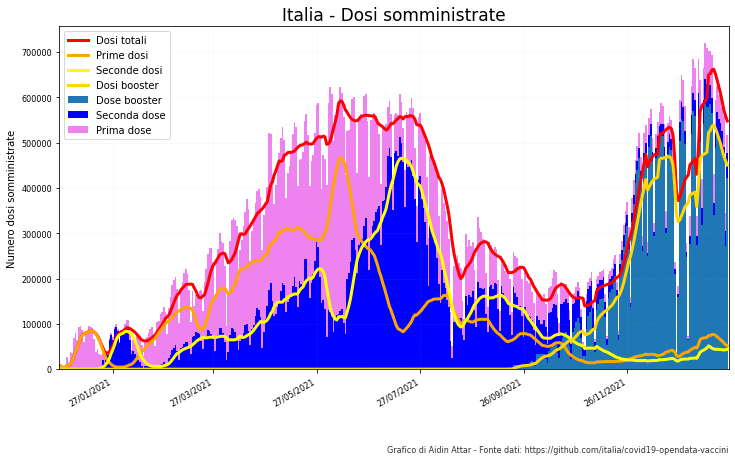

In [8]:
fig, ax = plt.subplots(figsize=(12,7))
label   = ['Dosi totali','Prime dosi','Seconde dosi','Dosi booster','Dose booster', 'Seconda dose','Prima dose' ]
italia[['dose_addizionale_booster','seconda_dose','prima_dose']].plot.bar(ax = ax, stacked = True, color = ['C0','blue','violet'], width = 1)
italia.plot(y='media_totale',                   kind = 'line', color =    'red', ax = ax, lw = 3)
italia.plot(y='media_prima_dose',               kind = 'line', color = 'orange', ax = ax, lw = 3)
italia.plot(y='media_seconda_dose',             kind = 'line', color = 'yellow', ax = ax, lw = 3)
italia.plot(y='media_dose_addizionale_booster', kind = 'line', color =   'gold', ax = ax, lw = 3)

ax.legend(label,loc="upper left")
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))

ax.set_title('Italia - Dosi somministrate', fontsize=17)
plt.rcParams['font.size'] = '8'
ax.tick_params(axis='both', labelsize=8)
ax.grid(alpha = 0.2,linestyle='dotted')
ax.set_ylabel('Numero dosi somministrate')
ax.set_xlabel("")
fig.autofmt_xdate()

plt.text(0.9, 0.05, 'Grafico di Aidin Attar - Fonte dati: https://github.com/italia/covid19-opendata-vaccini',
         transform=plt.gcf().transFigure,
         fontsize=8, color='black', alpha=0.8,
         ha='right', va='top', rotation='0')

plt.show()

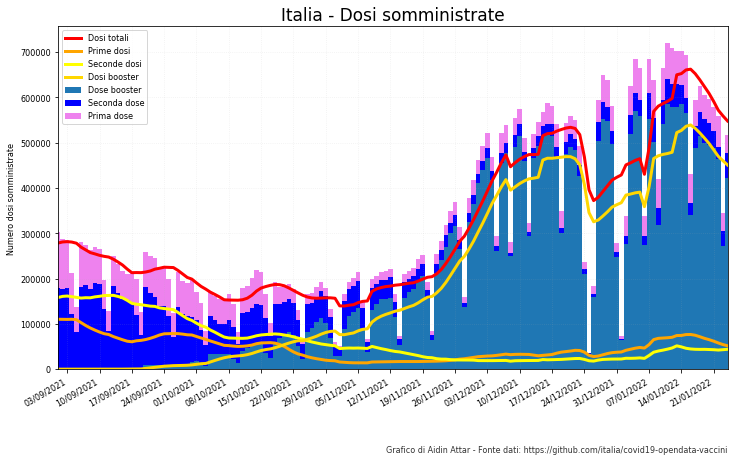

In [9]:
fig, ax = plt.subplots(figsize=(12,7))

label   = ['Dosi totali','Prime dosi','Seconde dosi','Dosi booster','Dose booster', 'Seconda dose','Prima dose' ]
italia[['dose_addizionale_booster','seconda_dose','prima_dose']].plot.bar(ax = ax, stacked = True, color = ['C0','blue','violet'], width = 1)
ax.plot(italia.index,                   italia.media_totale, color =    'red', lw = 3)
ax.plot(italia.index,               italia.media_prima_dose, color = 'orange', lw = 3)
ax.plot(italia.index,             italia.media_seconda_dose, color = 'yellow', lw = 3)
ax.plot(italia.index, italia.media_dose_addizionale_booster, color =   'gold', lw = 3)

ax.set_xlim([date(2021, 9, 1).strftime('%d/%m/%Y'), yesterday.strftime('%d/%m/%Y')])

ax.legend(label,loc="upper left")
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))

ax.set_title('Italia - Dosi somministrate', fontsize=17)
plt.rcParams['font.size'] = '8'
ax.tick_params(axis='both', labelsize=8)
ax.grid(alpha = 0.2,linestyle='dotted')
ax.set_ylabel('Numero dosi somministrate')
ax.set_xlabel("")
fig.autofmt_xdate()


plt.text(0.9, 0.05, 'Grafico di Aidin Attar - Fonte dati: https://github.com/italia/covid19-opendata-vaccini',
         transform=plt.gcf().transFigure,
         fontsize=8, color='black', alpha=0.8,
         ha='right', va='top', rotation='0')

plt.show()

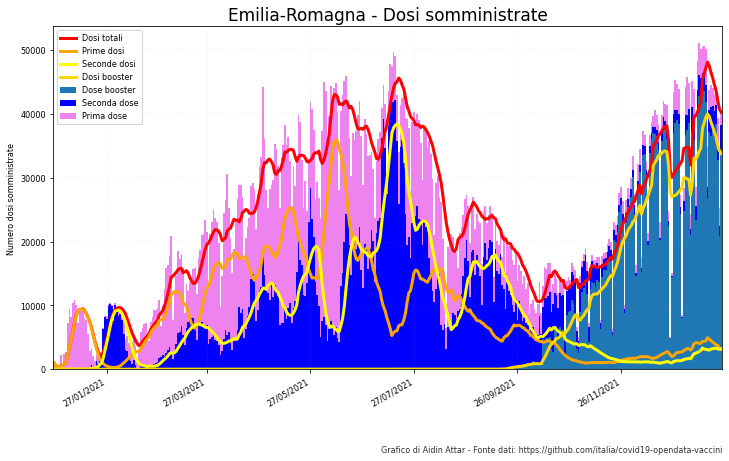

In [10]:
fig, ax = plt.subplots(figsize=(12,7))
label   = ['Dosi totali','Prime dosi','Seconde dosi','Dosi booster','Dose booster', 'Seconda dose','Prima dose' ]
somministrazioni_l['Emilia-Romagna'][['dose_addizionale_booster','seconda_dose','prima_dose']].plot.bar(label = label ,ax = ax,
                                                                                             stacked = True, xlabel = '', color = ['C0','blue','violet'], width = 1)
ax.plot(somministrazioni_l['Emilia-Romagna'].index,                   somministrazioni_l['Emilia-Romagna'].media_totale, color =    'red', lw=3)
ax.plot(somministrazioni_l['Emilia-Romagna'].index,               somministrazioni_l['Emilia-Romagna'].media_prima_dose, color = 'orange', lw=3)
ax.plot(somministrazioni_l['Emilia-Romagna'].index,             somministrazioni_l['Emilia-Romagna'].media_seconda_dose, color = 'yellow', lw=3)
ax.plot(somministrazioni_l['Emilia-Romagna'].index, somministrazioni_l['Emilia-Romagna'].media_dose_addizionale_booster, color =   'gold', lw=3)

ax.legend(label,loc="upper left")
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))

ax.set_title('Emilia-Romagna - Dosi somministrate', fontsize=17)
plt.rcParams['font.size'] = '8'
ax.tick_params(axis='both', labelsize=8)
ax.grid(alpha = 0.2,linestyle='dotted')
ax.set_ylabel('Numero dosi somministrate')
ax.set_xlabel("")
fig.autofmt_xdate()

plt.text(0.9, 0.05, 'Grafico di Aidin Attar - Fonte dati: https://github.com/italia/covid19-opendata-vaccini',
         transform=plt.gcf().transFigure,
         fontsize=8, color='black', alpha=0.8,
         ha='right', va='top', rotation='0')

plt.show()

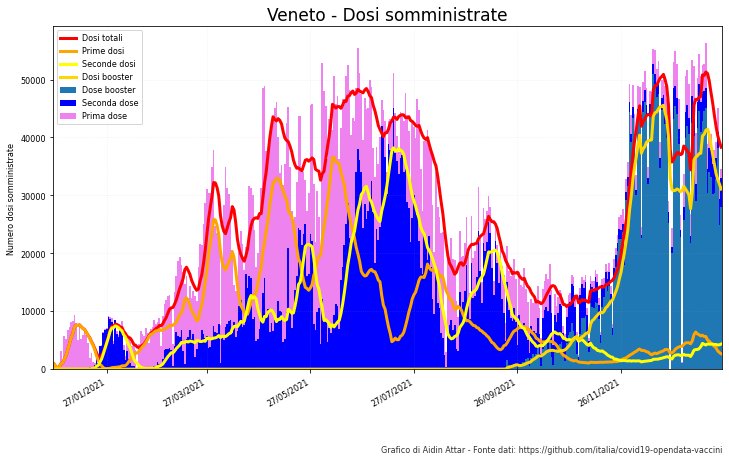

In [11]:
fig, ax = plt.subplots(figsize=(12,7))
label   = ['Dosi totali','Prime dosi','Seconde dosi','Dosi booster','Dose booster', 'Seconda dose','Prima dose' ]
somministrazioni_l['Veneto'][['dose_addizionale_booster','seconda_dose','prima_dose']].plot.bar(label = label ,ax = ax,
                                                                          stacked = True, xlabel = '', color = ['C0','blue','violet'], width = 1)
ax.plot(somministrazioni_l['Veneto'].index,                  somministrazioni_l['Veneto'].media_totale, color =    'red', lw=3)
ax.plot(somministrazioni_l['Veneto'].index,              somministrazioni_l['Veneto'].media_prima_dose, color = 'orange', lw=3)
ax.plot(somministrazioni_l['Veneto'].index,            somministrazioni_l['Veneto'].media_seconda_dose, color = 'yellow', lw=3)
ax.plot(somministrazioni_l['Veneto'].index, somministrazioni_l['Veneto'].media_dose_addizionale_booster, color =  'gold', lw=3)

ax.legend(label,loc="upper left")
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))

ax.set_title('Veneto - Dosi somministrate', fontsize=17)
plt.rcParams['font.size'] = '8'
ax.tick_params(axis='both', labelsize=8)
ax.grid(alpha = 0.2,linestyle='dotted')
ax.set_ylabel('Numero dosi somministrate')
ax.set_xlabel("")
fig.autofmt_xdate()

plt.text(0.9, 0.05, 'Grafico di Aidin Attar - Fonte dati: https://github.com/italia/covid19-opendata-vaccini',
         transform=plt.gcf().transFigure,
         fontsize=8, color='black', alpha=0.8,
         ha='right', va='top', rotation='0')

plt.show()

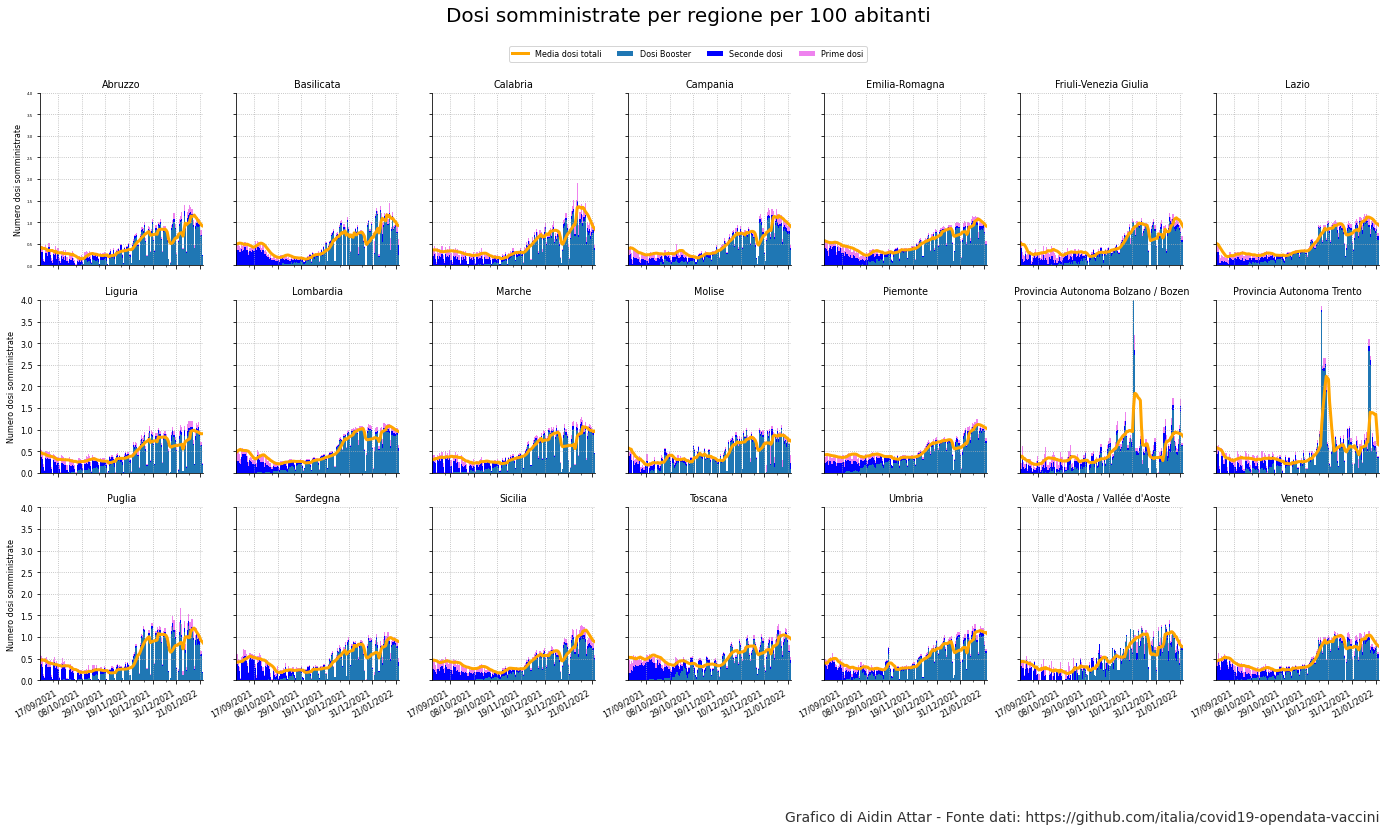

In [12]:
fig, ax = plt.subplots(nrows=3,ncols=7,figsize=(24,12), sharey=True, sharex=True)
x=0
y=0
for key in somministrazioni_l.keys():
    somministrazioni_l[key][['dose_addizionale_booster_per100',
                             'seconda_dose_per100',
                             'prima_dose_per100']].plot.bar(ax = ax[y,x],legend=False,
                                                             stacked = True, color = ['C0','blue','violet'],
                                                             width = 1, title=str(key))
    ax[y,x].plot(somministrazioni_l[key].index,somministrazioni_l[key]['media_totale_per100'], color='orange', lw=3)
    ax[y,x].grid(alpha = 1,linestyle='dotted')
    ax[y,x].spines['right'].set_visible(False)
    ax[y,x].spines['top'].set_visible(False)
    x+=1
    if x==7:
        x=0
        y+=1
ax[0,0].set_ylim([0,4])
ax[0,0].set_xlim([date(2021, 9, 1).strftime('%d/%m/%Y'), yesterday.strftime('%d/%m/%Y')])
ax[0,0].xaxis.set_major_locator(mdates.WeekdayLocator(interval=3))

fig.suptitle("Dosi somministrate per regione per 100 abitanti", fontsize=20)
plt.rcParams['font.size'] = '8'
ax[0,0].tick_params(axis='both', labelsize=4)
ax[0,0].set_ylabel('Numero dosi somministrate')
ax[1,0].set_ylabel('Numero dosi somministrate')
ax[2,0].set_ylabel('Numero dosi somministrate')
ax[0,0].set_xlabel("")
fig.autofmt_xdate()

labels = ['Media dosi totali','Dosi Booster', 'Seconde dosi', 'Prime dosi']
fig.legend(labels, loc='center',bbox_to_anchor=(.5,.925), ncol=len(labels), bbox_transform=fig.transFigure)

plt.text(0.9, 0.05, 'Grafico di Aidin Attar - Fonte dati: https://github.com/italia/covid19-opendata-vaccini',
         transform=plt.gcf().transFigure,
         fontsize=14, color='black', alpha=0.8,
         ha='right', va='top', rotation='0')

plt.show()

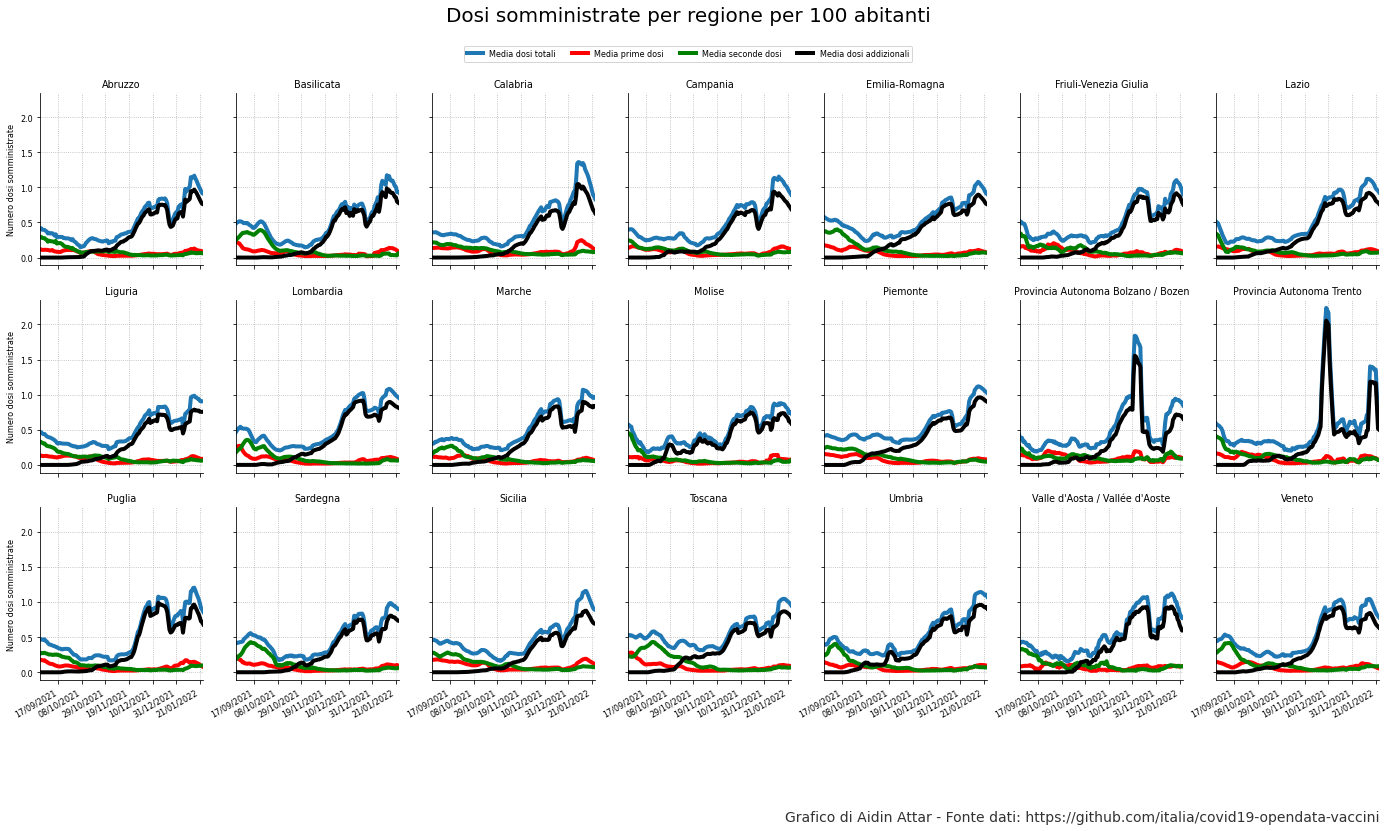

In [13]:
fig, ax = plt.subplots(nrows=3,ncols=7,figsize=(24,12), sharey=True, sharex=True)
x=0
y=0
for key in somministrazioni_l.keys():
    ax[y,x].plot(somministrazioni_l[key].index,                   somministrazioni_l[key].media_totale_per100, color=   'C0',lw=4)
    ax[y,x].plot(somministrazioni_l[key].index,               somministrazioni_l[key].media_prima_dose_per100, color=  'red',lw=4)
    ax[y,x].plot(somministrazioni_l[key].index,             somministrazioni_l[key].media_seconda_dose_per100, color='green',lw=4)
    ax[y,x].plot(somministrazioni_l[key].index, somministrazioni_l[key].media_dose_addizionale_booster_per100, color='black',lw=4)
    ax[y,x].set_title(key)
    ax[y,x].grid(linestyle='dotted')
    ax[y,x].spines['right'].set_visible(False)
    ax[y,x].spines['top'].set_visible(False)
    x+=1
    if x==7:
        x=0
        y+=1
#ax[0,0].set_ylim([0,40])
ax[0,0].set_xlim([date(2021, 9, 1).strftime('%d/%m/%Y'), yesterday.strftime('%d/%m/%Y')])
ax[0,0].xaxis.set_major_locator(mdates.WeekdayLocator(interval=3))

fig.suptitle("Dosi somministrate per regione per 100 abitanti", fontsize=20)
plt.rcParams['font.size'] = '8'
ax[0,0].tick_params(axis='both', labelsize=8)
ax[0,0].set_ylabel('Numero dosi somministrate')
ax[1,0].set_ylabel('Numero dosi somministrate')
ax[2,0].set_ylabel('Numero dosi somministrate')
ax[0,0].set_xlabel("")
fig.autofmt_xdate()
labels = ['Media dosi totali', 'Media prime dosi', 'Media seconde dosi', 'Media dosi addizionali']
fig.legend(labels, loc='center',bbox_to_anchor=(.5,.925), ncol=len(labels), bbox_transform=fig.transFigure)

plt.text(0.9, 0.05, 'Grafico di Aidin Attar - Fonte dati: https://github.com/italia/covid19-opendata-vaccini',
         transform=plt.gcf().transFigure,
         fontsize=14, color='black', alpha=0.8,
         ha='right', va='top', rotation='0')

plt.show()

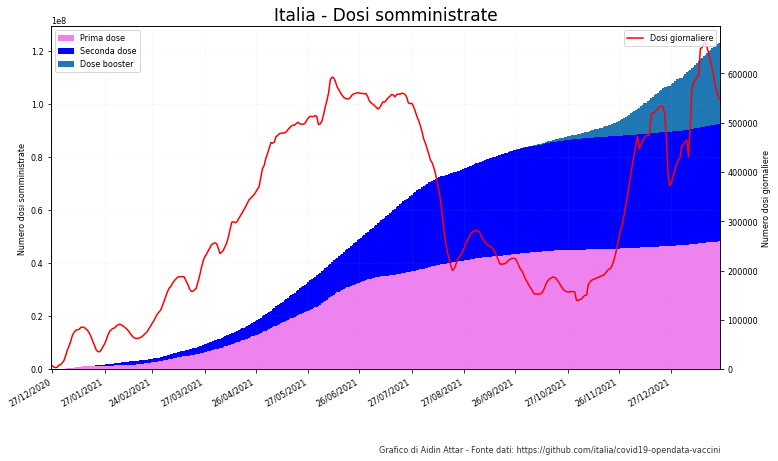

In [14]:
fig, ax = plt.subplots(figsize=(12,7))

label   = ['Prima dose','Seconda dose','Dose booster']
italia[['cumulativa_prima_dose','cumulativa_seconda_dose','cumulativa_dose_addizionale_booster']].plot.bar(ax = ax, stacked = True, color = ['violet','blue','C0'], width = 1)


#ax.set_xlim([date(2021, 9, 1).strftime('%d/%m/%Y'), yesterday.strftime('%d/%m/%Y')])

ax.legend(label,loc="upper left")
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))

ax.set_title('Italia - Dosi somministrate', fontsize=17)
plt.rcParams['font.size'] = '8'
ax.tick_params(axis='both', labelsize=8)
ax.grid(alpha = 0.2,linestyle='dotted')
ax.set_ylabel('Numero dosi somministrate')
ax.set_xlabel("")
fig.autofmt_xdate()

ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
ax2.plot(italia.index,                   italia.media_totale, color =    'red', label='Dosi giornaliere')
ax2.set_ylabel('Numero dosi giornaliere')
ax2.legend(loc='upper right')
ax2.tick_params(axis='both', labelsize=8)

ax.set_ylim(bottom=0)
ax2.set_ylim(bottom=0)

plt.text(0.9, 0.05, 'Grafico di Aidin Attar - Fonte dati: https://github.com/italia/covid19-opendata-vaccini',
         transform=plt.gcf().transFigure,
         fontsize=8, color='black', alpha=0.8,
         ha='right', va='top', rotation='0')

plt.show()

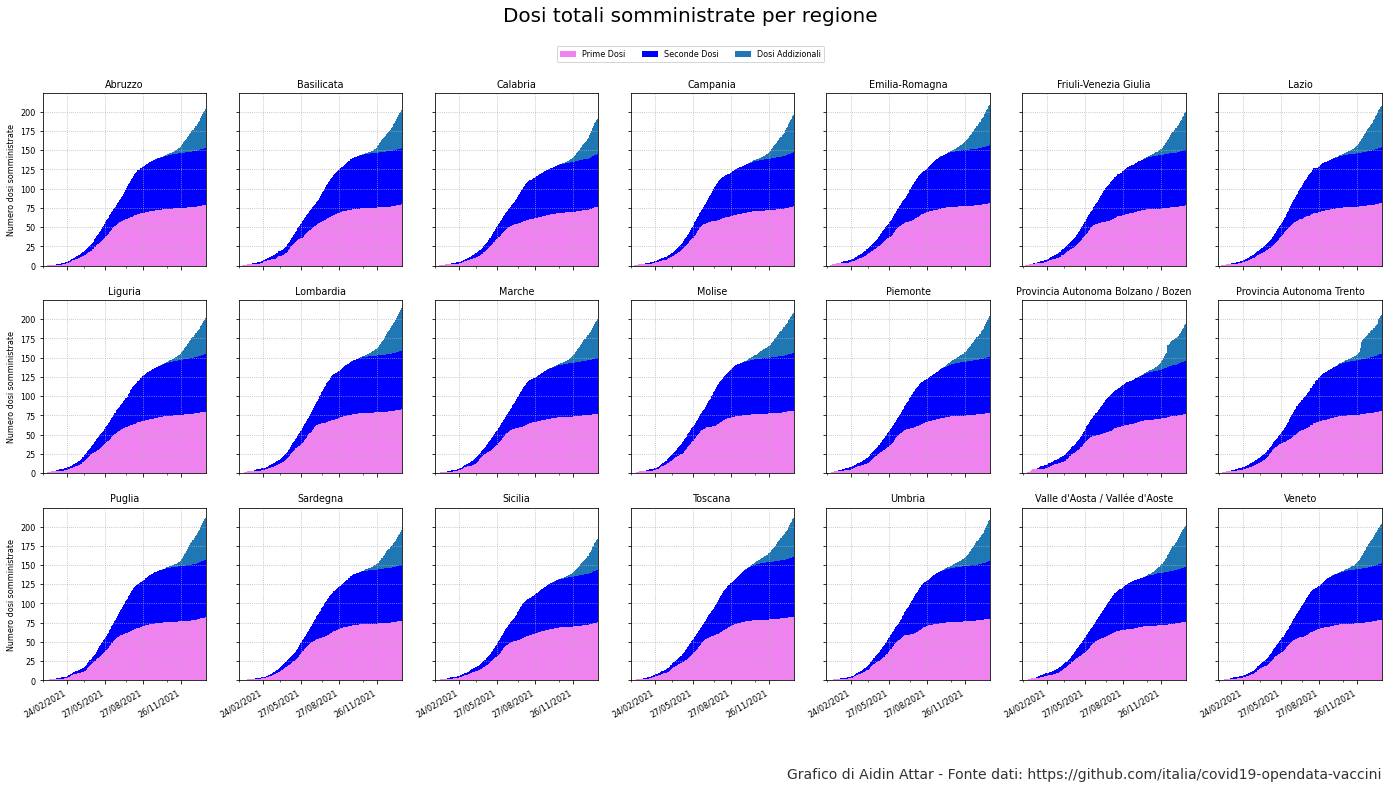

In [15]:
fig, ax = plt.subplots(nrows=3,ncols=7,figsize=(24,12), sharey=True, sharex=True)
x=0
y=0
for key in somministrazioni_l.keys():
    somministrazioni_l[key][['cumulativa_prima_dose_per100','cumulativa_seconda_dose_per100','cumulativa_dose_addizionale_booster_per100']].plot.bar(ax = ax[y,x], stacked = True, color = ['violet','blue','C0'],legend=False,width = 1)
    ax[y,x].set_title(str(key))
    ax[y,x].grid(linestyle='dotted')
    x+=1
    if x==7:
        x=0
        y+=1
ax[0,0].xaxis.set_major_locator(mdates.MonthLocator(interval=3))

fig.suptitle("Dosi totali somministrate per regione", fontsize=20)
plt.rcParams['font.size'] = '8'
ax[0,0].tick_params(axis='both', labelsize=8)
#ax.grid(alpha = 0.2,linestyle='dotted')
ax[0,0].set_ylabel('Numero dosi somministrate')
ax[1,0].set_ylabel('Numero dosi somministrate')
ax[2,0].set_ylabel('Numero dosi somministrate')
ax[0,0].set_xlabel("")
fig.autofmt_xdate()
labels = ['Prime Dosi','Seconde Dosi','Dosi Addizionali']
fig.legend(labels, loc='center',bbox_to_anchor=(.5,.925), ncol=len(labels), bbox_transform=fig.transFigure)

plt.text(0.9, 0.1, 'Grafico di Aidin Attar - Fonte dati: https://github.com/italia/covid19-opendata-vaccini',
         transform=plt.gcf().transFigure,
         fontsize=14, color='black', alpha=0.8,
         ha='right', va='top', rotation='0')

plt.show()

Text(1, 0, 'Grafico di Aidin Attar - Fonte dati: https://github.com/italia/covid19-opendata-vaccini')

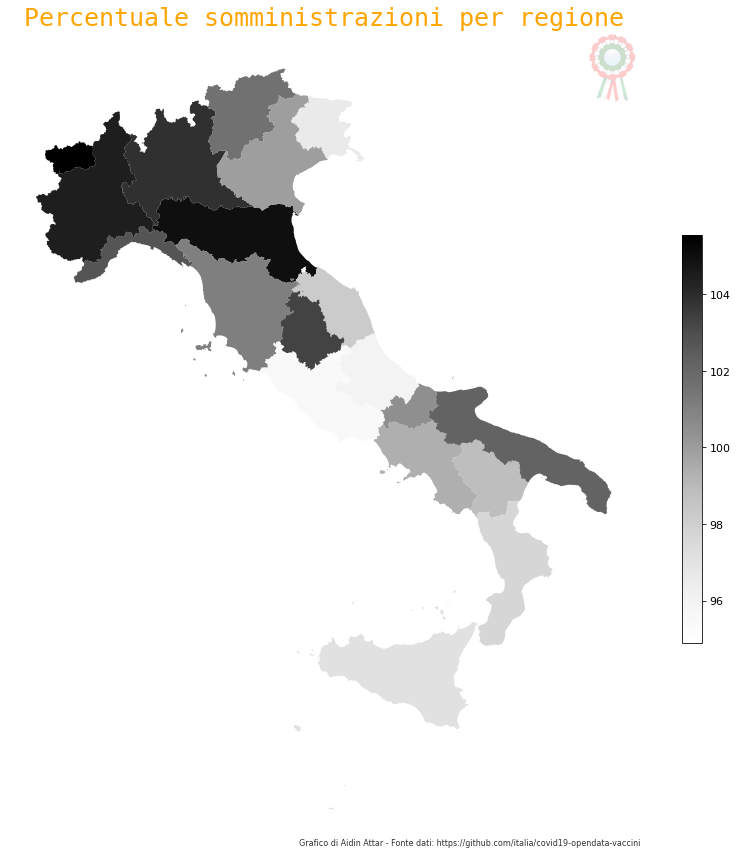

In [16]:
italy      = gpd.read_file('italy-with-regions/reg2011_g.shp')

vaccini1 = vaccini.set_index('area')
sum_ = vaccini1.loc[['PAT', 'PAB']].sum().to_frame().transpose()
sum_ = sum_.rename(index={0: 'TRE'})

vaccini1.drop(['PAT', 'PAB'],inplace=True)
vaccini1 = vaccini1.append(sum_)
vaccini1 = vaccini1.sort_index()

italy.sort_values(by = 'NOME_REG', inplace = True)
italy.reset_index(drop=True,       inplace = True)
italy.index = vaccini1.index

italy = italy.merge(vaccini1,left_index=True, right_index=True, how='right')
italy['percentuale_somministrazione'] = italy['dosi_somministrate'] / italy['dosi_consegnate'] * 100

fig, ax = plt.subplots(1, figsize=(15, 15))
col = 'percentuale_somministrazione'
ax.set_title('Percentuale somministrazioni per regione',
             fontdict={'fontsize':'25', 'fontweight':'3'},
             color='Orange',
             fontfamily='monospace')

normalize = mcolors.Normalize(vmin=italy['percentuale_somministrazione'].min(), vmax=italy['percentuale_somministrazione'].max())
scalarmappaple = cm.ScalarMappable(norm=normalize, cmap="Greys")
#scalarmappaple.set_array(italy.percentuale_somministrazione)
italy.plot(ax=ax,
           column=col,
           cmap='Greys')

plt.axis('off')
cbar = plt.colorbar(scalarmappaple, shrink=0.5)
cbar.ax.tick_params(labelsize=11)
watermark2()
ax.text(1, 0, 'Grafico di Aidin Attar - Fonte dati: https://github.com/italia/covid19-opendata-vaccini', transform=ax.transAxes,
        fontsize=8, color='black', alpha=0.8,
        ha='right', va='bottom', rotation='0')

In [17]:
oggi = [somministrazioni_l[key].iloc[-1] for key in somministrazioni_l.keys()]
cum = pd.DataFrame(oggi)
cum

data_somministrazione area   totale  sesso_maschile  \
24/01/2022            2022-01-24  ABR  11988.0          6000.0   
24/01/2022            2022-01-24  BAS   4575.0          2298.0   
24/01/2022            2022-01-24  CAL  14429.0          6928.0   
24/01/2022            2022-01-24  CAM  48782.0         23381.0   
24/01/2022            2022-01-24  EMR  40546.0         21018.0   
24/01/2022            2022-01-24  FVG   8633.0          4381.0   
24/01/2022            2022-01-24  LAZ  50675.0         25302.0   
24/01/2022            2022-01-24  LIG  14814.0          7503.0   
24/01/2022            2022-01-24  LOM  95903.0         49813.0   
24/01/2022            2022-01-24  MAR  12933.0          6613.0   
24/01/2022            2022-01-24  MOL   2295.0          1136.0   
24/01/2022            2022-01-24  PIE  41284.0         21376.0   
24/01/2022            2022-01-24  PAB   2600.0          1385.0   
24/01/2022            2022-01-24  PAT   2334.0          1219.0   
24/01/2022            2022-01-24  PUG  32376.0         16154.0   
24/01/2022            2022-01-24  SAR  14688.0          7383.0   
24/01/2022            2022-01-24  SIC  43900.0         21271.0   
24/01/2022            2022-01-24  TOS  30451.0         15799.0   
24/01/2022            2022-01-24  UMB   8802.0          4511.0   
24/01/2022            2022-01-24  VDA    860.0           426.0   
24/01/2022            2022-01-24  VEN  34729.0         17880.0   

            sesso_femminile  prima_dose  seconda_dose  pregressa_infezione  \
24/01/2022           5988.0       684.0         881.0                 21.0   
24/01/2022           2277.0       153.0         275.0                  5.0   
24/01/2022           7501.0      1617.0        2016.0                 51.0   
24/01/2022          25401.0      5374.0        7775.0                108.0   
24/01/2022          19528.0      2082.0        4024.0                154.0   
24/01/2022           4252.0       766.0         840.0                 20.0   
24/01/2022          25373.0      4136.0        5008.0                140.0   
24/01/2022           7311.0      1236.0        1462.0                 12.0   
24/01/2022          46090.0      5543.0        8265.0                165.0   
24/01/2022           6320.0       791.0         941.0                 27.0   
24/01/2022           1159.0       108.0         140.0                  1.0   
24/01/2022          19908.0      2750.0        2006.0                 60.0   
24/01/2022           1215.0       380.0         444.0                  1.0   
24/01/2022           1115.0       153.0         159.0                  2.0   
24/01/2022          16222.0      2481.0        5444.0                 54.0   
24/01/2022           7305.0      1044.0        1375.0                105.0   
24/01/2022          22629.0      4582.0        5272.0                222.0   
24/01/2022          14652.0      2216.0        3674.0                158.0   
24/01/2022           4291.0       801.0         717.0                 37.0   
24/01/2022            434.0        77.0         101.0                  0.0   
24/01/2022          16849.0      1527.0        4997.0                185.0   

            dose_addizionale_booster codice_NUTS1  ... cumulativa_totale  \
24/01/2022                   10402.0          ITF  ...         2703464.0   
24/01/2022                    4142.0          ITF  ...         1151813.0   
24/01/2022                   10745.0          ITF  ...         3741971.0   
24/01/2022                   35525.0          ITF  ...        11506749.0   
24/01/2022                   34286.0          ITH  ...         9442029.0   
24/01/2022                    7007.0          ITH  ...         2468306.0   
24/01/2022                   41391.0          ITI  ...        12387863.0   
24/01/2022                   12104.0          ITC  ...         3147746.0   
24/01/2022                   81930.0          ITC  ...        21817515.0   
24/01/2022                   11174.0          ITI  ...         3100068.0   
24/01

/tmp/ipykernel_48802/4227701064.py:4: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  sum_ = cum1.reindex(['PAT', 'PAB']).sum().to_frame().transpose()


Text(1, 0, 'Grafico di Aidin Attar - Fonte dati: https://github.com/italia/covid19-opendata-vaccini')

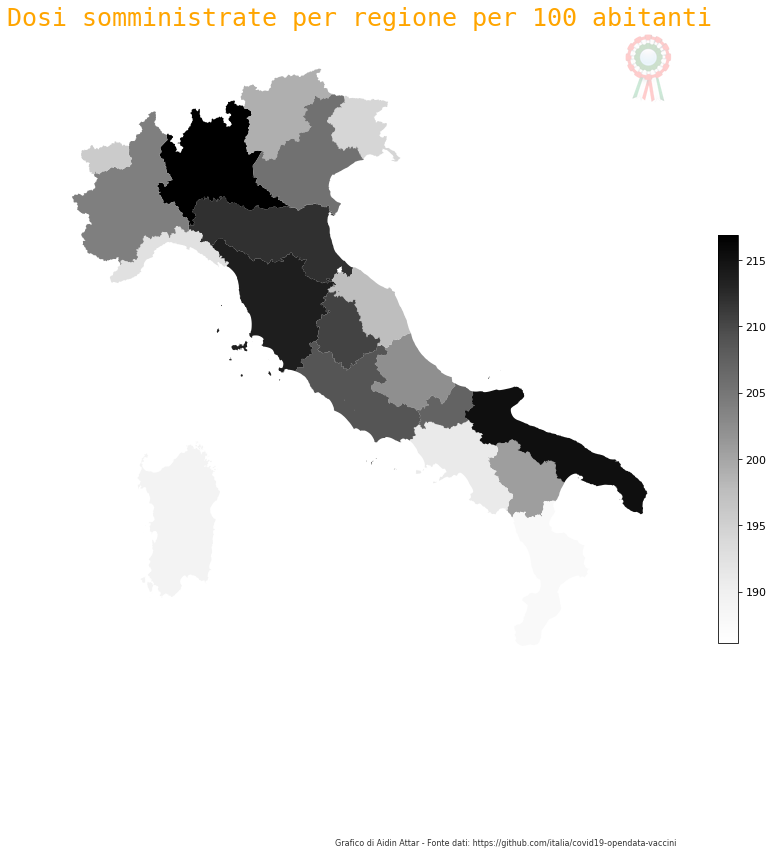

In [18]:
italy = gpd.read_file('italy-with-regions//reg2011_g.shp')

cum1 = cum.set_index('area')
sum_ = cum1.reindex(['PAT', 'PAB']).sum().to_frame().transpose()
sum_ = sum_.rename(index={0: 'TRE'})
cum1.drop(['PAT', 'PAB'],inplace=True)
cum1 = cum1.append(sum_)
cum1 = cum1.sort_index()
italy.sort_values(by = 'NOME_REG', inplace = True)
italy.reset_index(drop=True,       inplace = True)
italy.index = cum1.index

italy = italy.merge(cum1,left_index=True, right_index=True, how='right')
italy.at['TRE',                  'cumulativa_totale_per100'] = italy.at['TRE',                  'cumulativa_totale'] / (DictRegioni['Provincia Autonoma Bolzano / Bozen']+DictRegioni['Provincia Autonoma Trento'])*100
italy.at['TRE',              'cumulativa_prima_dose_per100'] = italy.at['TRE',              'cumulativa_prima_dose'] / (DictRegioni['Provincia Autonoma Bolzano / Bozen']+DictRegioni['Provincia Autonoma Trento'])*100
italy.at['TRE',            'cumulativa_seconda_dose_per100'] = italy.at['TRE',            'cumulativa_seconda_dose'] / (DictRegioni['Provincia Autonoma Bolzano / Bozen']+DictRegioni['Provincia Autonoma Trento'])*100
italy.at['TRE',     'cumulativa_pregressa_infezione_per100'] = italy.at['TRE',     'cumulativa_pregressa_infezione'] / (DictRegioni['Provincia Autonoma Bolzano / Bozen']+DictRegioni['Provincia Autonoma Trento'])*100
italy.at['TRE','cumulativa_dose_addizionale_booster_per100'] = italy.at['TRE','cumulativa_dose_addizionale_booster'] / (DictRegioni['Provincia Autonoma Bolzano / Bozen']+DictRegioni['Provincia Autonoma Trento'])*100

fig, ax = plt.subplots(1, figsize=(15, 15))
col = 'cumulativa_totale_per100'
ax.set_title('Dosi somministrate per regione per 100 abitanti', 
             fontdict={'fontsize':'25', 'fontweight':'3'}, 
             color='Orange', 
             fontfamily='monospace')


normalize = mcolors.Normalize(vmin=italy['cumulativa_totale_per100'].min(), vmax=italy['cumulativa_totale_per100'].max())
scalarmappaple = cm.ScalarMappable(norm=normalize, cmap="Greys")
#scalarmappaple.set_array(italy['cumulativa_totale_per100'])

italy.plot(ax=ax,
           column=col,
           cmap="Greys")
plt.axis('off')
cbar = plt.colorbar(scalarmappaple, shrink=0.5)
cbar.ax.tick_params(labelsize=11)
watermark2()
ax.text(1, 0, 'Grafico di Aidin Attar - Fonte dati: https://github.com/italia/covid19-opendata-vaccini', transform=ax.transAxes,
        fontsize=8, color='black', alpha=0.8,
        ha='right', va='bottom', rotation='0')

Text(0.9, 0.25, 'Grafico di Aidin Attar - Fonte dati: https://github.com/italia/covid19-opendata-vaccini')

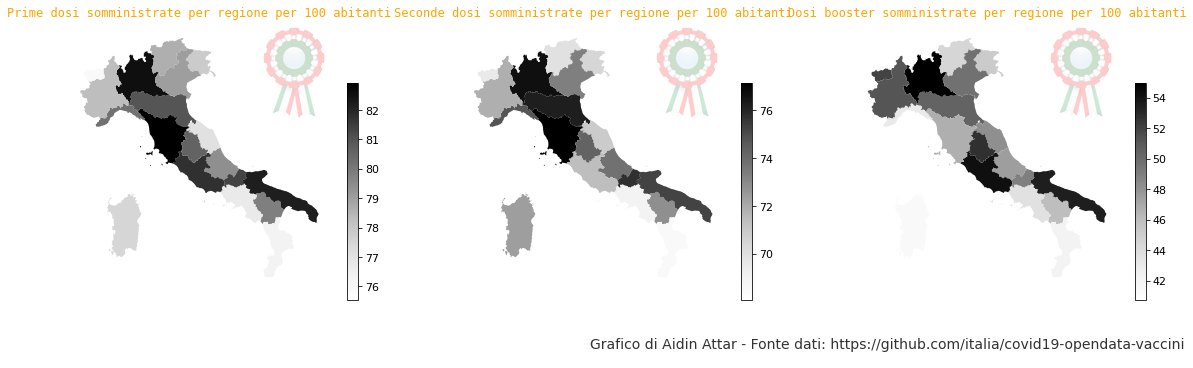

In [19]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 8))
col1 = 'cumulativa_prima_dose_per100'
ax[0].set_title('Prime dosi somministrate per regione per 100 abitanti',
             fontdict={'fontsize':'12', 'fontweight':'3'},
             color='Orange',
             fontfamily='monospace')


normalize1 = mcolors.Normalize(vmin=italy['cumulativa_prima_dose_per100'].min(), vmax=italy['cumulativa_prima_dose_per100'].max())
scalarmappaple1 = cm.ScalarMappable(norm=normalize1, cmap="Greys")
#scalarmappaple.set_array(italy['cumulativa_totale_per100'])

italy.plot(ax=ax[0],
           column=col1,
           cmap="Greys")
plt.axis('off')
cbar = plt.colorbar(scalarmappaple1, ax=ax[0],shrink=0.5)
cbar.ax.tick_params(labelsize=11)

col2 = 'cumulativa_seconda_dose_per100'
ax[1].set_title('Seconde dosi somministrate per regione per 100 abitanti',
             fontdict={'fontsize':'12', 'fontweight':'3'},
             color='Orange',
             fontfamily='monospace')


normalize2 = mcolors.Normalize(vmin=italy['cumulativa_seconda_dose_per100'].min(), vmax=italy['cumulativa_seconda_dose_per100'].max())
scalarmappaple2 = cm.ScalarMappable(norm=normalize2, cmap="Greys")
#scalarmappaple.set_array(italy['cumulativa_totale_per100'])

italy.plot(ax=ax[1],
           column=col2,
           cmap="Greys")
cbar = plt.colorbar(scalarmappaple2, ax=ax[1],shrink=0.5)
cbar.ax.tick_params(labelsize=11)

col3 = 'cumulativa_dose_addizionale_booster_per100'
ax[2].set_title('Dosi booster somministrate per regione per 100 abitanti',
             fontdict={'fontsize':'12', 'fontweight':'3'},
             color='Orange',
             fontfamily='monospace')


normalize3 = mcolors.Normalize(vmin=italy['cumulativa_dose_addizionale_booster_per100'].min(), vmax=italy['cumulativa_dose_addizionale_booster_per100'].max())
scalarmappaple3 = cm.ScalarMappable(norm=normalize3, cmap="Greys")
#scalarmappaple.set_array(italy['cumulativa_totale_per100'])

italy.plot(ax=ax[2],
           column=col3,
           cmap="Greys")
ax[0].axis('off')
ax[1].axis('off')
ax[2].axis('off')
cbar = plt.colorbar(scalarmappaple3, ax=ax[2],shrink=0.5)
cbar.ax.tick_params(labelsize=11)

watermark2(ax=ax[0])
watermark2(ax=ax[1])
watermark2(ax=ax[2])
plt.text(0.9, 0.25, 'Grafico di Aidin Attar - Fonte dati: https://github.com/italia/covid19-opendata-vaccini',
         transform=plt.gcf().transFigure,
         fontsize=14, color='black', alpha=0.8,
         ha='right', va='top', rotation='0')

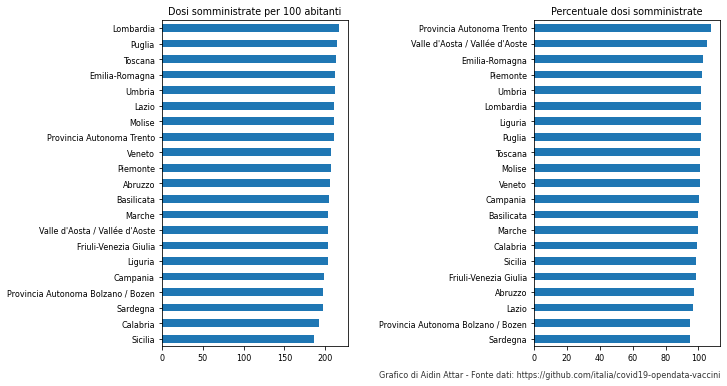

In [20]:
cum = cum.sort_values(by = 'cumulativa_totale_per100')
vaccinisort = vaccini.sort_values(by = 'percentuale_somministrazione')
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,6), gridspec_kw={ 'wspace': 1})

plt.rcParams['font.size'] = '8'
cum.plot(        ax=axes[0],x = 'nome_area', y='cumulativa_totale_per100', kind = 'barh', legend = False, xlabel = '', title = "Dosi somministrate per 100 abitanti")
vaccinisort.plot(ax=axes[1],x = 'nome_area', y='percentuale_somministrazione', kind = 'barh', legend = False, xlabel = '', title = "Percentuale dosi somministrate")
plt.text(0.9, 0.05, 'Grafico di Aidin Attar - Fonte dati: https://github.com/italia/covid19-opendata-vaccini', transform=plt.gcf().transFigure,
        fontsize=8, color='black', alpha=0.8,
        ha='right', va='bottom', rotation='0')
plt.show()

In [21]:
# Need to clone the repository https://github.com/pcm-dpc/COVID-19.git #

province        = pd.read_csv('../../COVID-19/dati-province/dpc-covid19-ita-province.csv')
regioni         = pd.read_csv('../../COVID-19/dati-regioni/dpc-covid19-ita-regioni.csv')
italia_contagio = pd.read_csv('../../COVID-19/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv')
Popolazione     = pd.read_csv('../../COVID-19/grafici/Popolazione_Regioni.csv', names=('provincia','sigla', 'popolazione'))
italia_contagio

data stato  ricoverati_con_sintomi  terapia_intensiva  \
0    2020-02-24T18:00:00   ITA                     101                 26   
1    2020-02-25T18:00:00   ITA                     114                 35   
2    2020-02-26T18:00:00   ITA                     128                 36   
3    2020-02-27T18:00:00   ITA                     248                 56   
4    2020-02-28T18:00:00   ITA                     345                 64   
..                   ...   ...                     ...                ...   
696  2022-01-20T17:00:00   ITA                   19659               1698   
697  2022-01-21T17:00:00   ITA                   19485               1707   
698  2022-01-22T17:00:00   ITA                   19442               1676   
699  2022-01-23T17:00:00   ITA                   19627               1685   
700  2022-01-24T17:00:00   ITA                   19862               1685   

     totale_ospedalizzati  isolamento_domiciliare  totale_positivi  \
0                     127                      94              221   
1                     150                     162              311   
2                     164                     221              385   
3                     304                     284              588   
4                     409                     412              821   
..                    ...                     ...              ...   
696                 21357                 2660684          2682041   
697                 21192                 2674511          2695703   
698                 21118                 2702831          2723949   
699                 21312                 2713594          2734906   
700                 21547                 2688310          2709857   

     variazione_totale_positivi  nuovi_positivi  dimessi_guariti  ...  \
0                             0             221                1  ...   
1                            90              93                1  ...   
2                            74              78                3  ...   
3                           203             250               45  ...   
4                           233             238               46  ...   
..                          ...             ...              ...  ...   
696                       55451          188797          6593625  ...   
697                       13662          179106          6765190  ...   
698                       28246          171263          6913946  ...   
699                       10957          138860          7045249  ...   
700                      -25049           77696          7147612  ...   

       tamponi  casi_testati  note  ingressi_terapia_intensiva  note_test  \
0         4324           NaN   NaN                         NaN        NaN   
1         8623           NaN   NaN                         NaN        NaN   
2         9587           NaN   NaN                         NaN        NaN   
3        12014           NaN   NaN                         NaN        NaN   
4        15695           NaN   NaN                         NaN        NaN   
..         ...           ...   ...                         ...        ...   
696  160111999    46726531.0   NaN                       155.0        NaN   
697  161229552    46930178.0   NaN                       148.0        NaN   
698  162273201    47126726.0   NaN                       121.0        NaN   
699  163206585    47287113.0   NaN                       132.0        NaN   
700  163725878    47388265.0   NaN                       101.0        NaN   

     note_casi totale_positivi_test_molecolare  \
0          NaN                             NaN   
1          NaN                             NaN   
2          NaN                             NaN   
3          NaN                             NaN   
4          NaN                             NaN   
..         ...                             ...   
696        NaN                       6904080.0   
697        NaN                       6977045.0   
69

In [22]:
idx = pd.date_range('2020-02-24', yesterday)
italia_contagio['data']                             = pd.to_datetime(italia_contagio['data'],format='%Y-%m-%dT%H:%M:%S',yearfirst=True, dayfirst=True)
italia_contagio['new_date'] = italia_contagio['data'].dt.date
#italia_contagio.sort_values(by='new_date',inplace=True)
italia_contagio                                     = italia_contagio.set_index('new_date')
italia_contagio.sort_index(inplace=True)
italia_contagio                                     = italia_contagio.reindex(idx)
italia_contagio.index                               = italia_contagio.index.strftime('%d/%m/%Y')
italia_contagio.fillna(method='ffill',inplace=True)
italia_contagio['casi_giornalieri']                 = italia_contagio['totale_casi'] - italia_contagio['totale_casi'].shift(1)
italia_contagio['media_casi_giorn']                 = italia_contagio['casi_giornalieri'].rolling(window=7, min_periods=1).mean()
italia_contagio['morti_giornalieri']                = italia_contagio['deceduti'] - italia_contagio['deceduti'].shift(1)
italia_contagio['media_morti_giorn']                = italia_contagio['morti_giornalieri'].rolling(window=7, min_periods=1).mean()
italia_contagio['media_ingressi_terapia_intensiva'] = italia_contagio['ingressi_terapia_intensiva'].rolling(window=7, min_periods=1).mean()

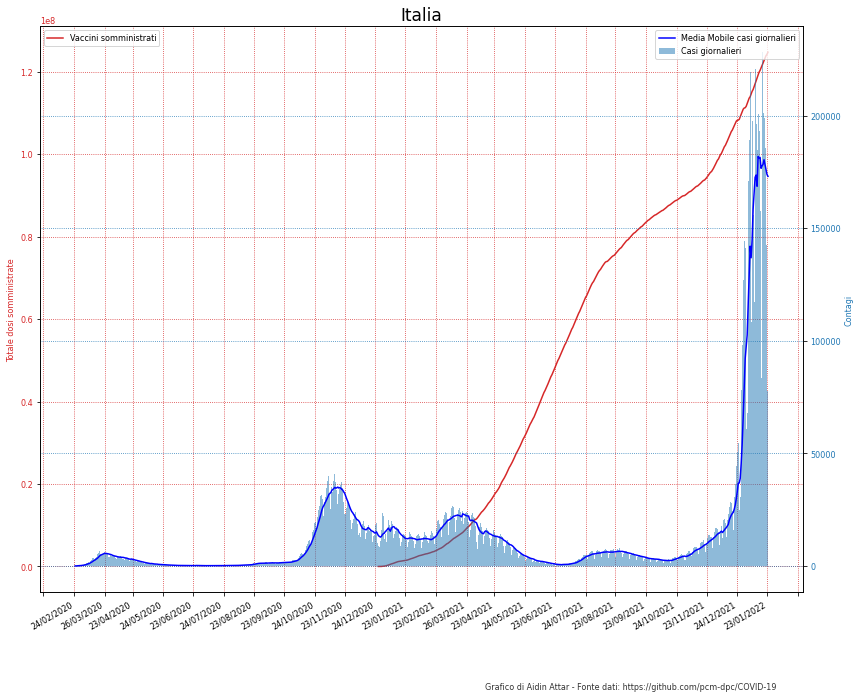

In [23]:
fig, ax1 = plt.subplots(figsize=(12, 10))

color = 'tab:red'
ax1.set_xlabel('')
ax1.set_ylabel('Totale dosi somministrate', color=color)
ax1.plot(italia.index, italia.cumulativa_totale, color=color, label='Vaccini somministrati',zorder=3)

ax1.legend(loc='upper left')
fig.autofmt_xdate()

ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(linestyle='dotted',color=color)
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=1))

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('Contagi', color=color)

ax2.bar(italia_contagio.index, italia_contagio.casi_giornalieri, color=color, width=1, alpha=0.5,label='Casi giornalieri', zorder=1)
ax2.plot(italia_contagio.index, italia_contagio['media_casi_giorn'],
        color = 'blue', label = 'Media Mobile casi giornalieri',zorder=2)
ax1.set_title('Italia', fontsize=17)
plt.rcParams['font.size'] = '8'

ax2.set_xlabel('')
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(loc='upper right')

ax2.grid(linestyle='dotted', color=color)

plt.text(0.9, 0.05, 'Grafico di Aidin Attar - Fonte dati: https://github.com/pcm-dpc/COVID-19',
         transform=plt.gcf().transFigure,
         fontsize=8, color='black', alpha=0.8,
         ha='right', va='top', rotation='0')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()


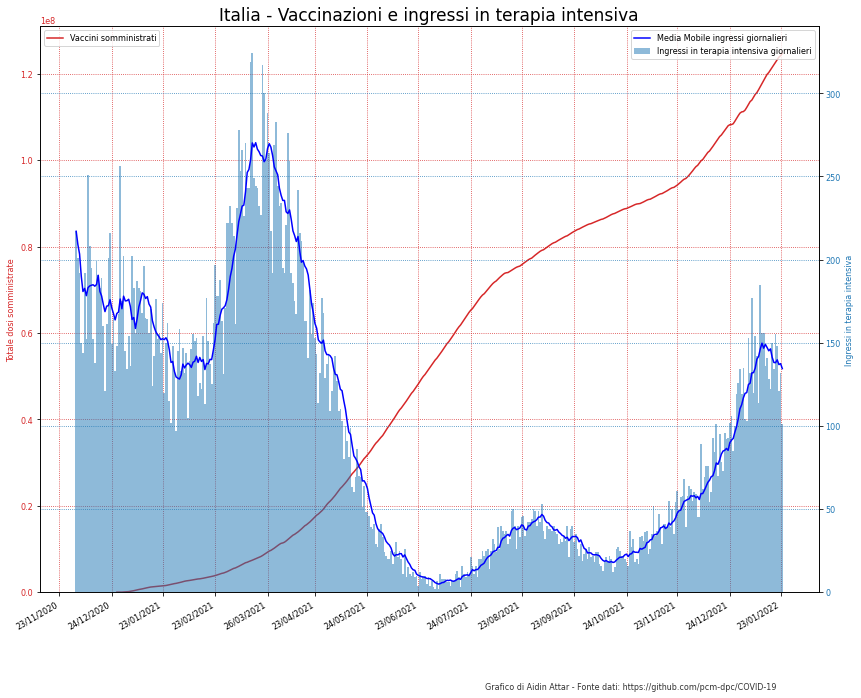

In [24]:
fig, ax1 = plt.subplots(figsize=(12, 10))

color = 'tab:red'
ax1.set_xlabel('')
ax1.set_ylabel('Totale dosi somministrate', color=color)
ax1.plot(italia.index, italia.cumulativa_totale, color=color, label='Vaccini somministrati',zorder=3)
ax1.set_ylim(bottom=0)
ax1.legend(loc='upper left')
fig.autofmt_xdate()

ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(linestyle='dotted',color=color)
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=1))

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('Ingressi in terapia intensiva', color=color)

ax2.bar(italia_contagio.index, italia_contagio.ingressi_terapia_intensiva, color=color, width=1, alpha=0.5,label='Ingressi in terapia intensiva giornalieri', zorder=1)
ax2.plot(italia_contagio.index, italia_contagio['media_ingressi_terapia_intensiva'],
        color = 'blue', label = 'Media Mobile ingressi giornalieri',zorder=2)
ax1.set_title('Italia - Vaccinazioni e ingressi in terapia intensiva', fontsize=17)
plt.rcParams['font.size'] = '8'
ax2.set_ylim(bottom=0)
ax2.set_xlabel('')
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(loc='upper right')

ax2.grid(linestyle='dotted', color=color)

plt.text(0.9, 0.05, 'Grafico di Aidin Attar - Fonte dati: https://github.com/pcm-dpc/COVID-19',
         transform=plt.gcf().transFigure,
         fontsize=8, color='black', alpha=0.8,
         ha='right', va='top', rotation='0')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()


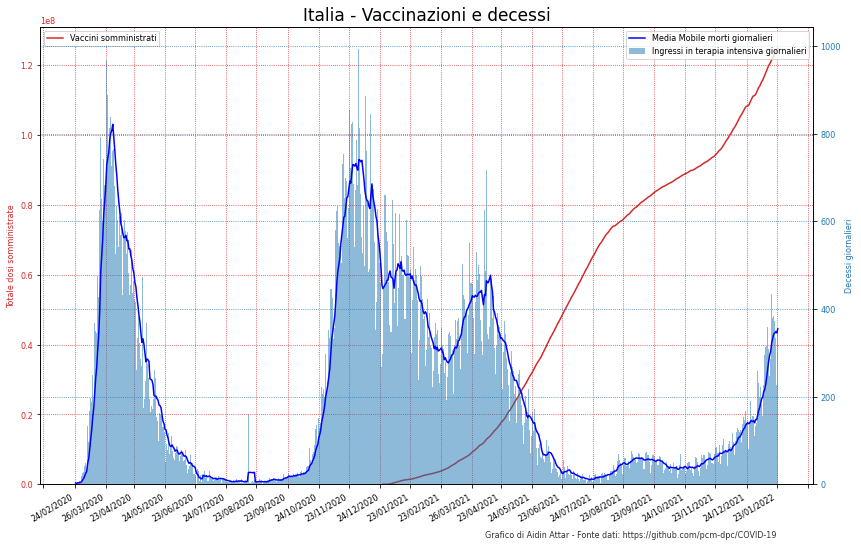

In [25]:
fig, ax1 = plt.subplots(figsize=(12, 8))

color = 'tab:red'
ax1.set_xlabel('')
ax1.set_ylabel('Totale dosi somministrate', color=color)
ax1.plot(italia.index, italia.cumulativa_totale, color=color, label='Vaccini somministrati',zorder=3)
ax1.set_ylim(bottom=0)
ax1.legend(loc='upper left')
fig.autofmt_xdate()

ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(linestyle='dotted',color=color)
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=1))

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('Decessi giornalieri', color=color)

ax2.bar(italia_contagio.index, italia_contagio.morti_giornalieri, color=color, width=1, alpha=0.5,label='Ingressi in terapia intensiva giornalieri', zorder=1)
ax2.plot(italia_contagio.index, italia_contagio['media_morti_giorn'],
        color = 'blue', label = 'Media Mobile morti giornalieri',zorder=2)
ax1.set_title('Italia - Vaccinazioni e decessi', fontsize=17)
plt.rcParams['font.size'] = '8'
ax2.set_ylim(bottom=0)
ax2.set_xlabel('')
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(loc='upper right')

ax2.grid(linestyle='dotted', color=color)

plt.text(0.9, 0.075, 'Grafico di Aidin Attar - Fonte dati: https://github.com/pcm-dpc/COVID-19',
         transform=plt.gcf().transFigure,
         fontsize=8, color='black', alpha=0.8,
         ha='right', va='top', rotation='0')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()


In [26]:
idx = pd.date_range('27/12/2020', yesterday)
NomiFornitori=somm1.fornitore.unique()
FasceAnagrafiche=somm1.fascia_anagrafica.unique()
somministrazioni_fornitori_età={elem1:{elem2:{elem3:pd.DataFrame for elem3 in FasceAnagrafiche} for elem2 in NomiFornitori} for elem1 in NomiRegioni}

for key1 in somministrazioni_fornitori_età.keys():
    for key2 in somministrazioni_fornitori_età[key1].keys():
        for key3 in somministrazioni_fornitori_età[key1][key2].keys():
            somministrazioni_fornitori_età[key1][key2][key3]                          = somm1[:][somm1.nome_area==key1][somm1.fornitore==key2][somm1.fascia_anagrafica==key3]
            somministrazioni_fornitori_età[key1][key2][key3]['totale']                = somministrazioni_fornitori_età[key1][key2][key3]['sesso_maschile'] + somministrazioni_fornitori_età[key1][key2][key3]['sesso_femminile']             
            somministrazioni_fornitori_età[key1][key2][key3]['data_somministrazione'] = pd.to_datetime(somministrazioni_fornitori_età[key1][key2][key3]['data_somministrazione'], format='%Y-%m-%d', yearfirst=True)
            somministrazioni_fornitori_età[key1][key2][key3]                          = somministrazioni_fornitori_età[key1][key2][key3].set_index('data_somministrazione')
            somministrazioni_fornitori_età[key1][key2][key3].index                    = pd.DatetimeIndex(somministrazioni_fornitori_età[key1][key2][key3].index)
            somministrazioni_fornitori_età[key1][key2][key3].sort_index(inplace=True)
            somministrazioni_fornitori_età[key1][key2][key3]                          = somministrazioni_fornitori_età[key1][key2][key3].reindex(idx)
            somministrazioni_fornitori_età[key1][key2][key3].index                    = somministrazioni_fornitori_età[key1][key2][key3].index.strftime('%d/%m/%Y')
            somministrazioni_fornitori_età[key1][key2][key3].area.fillna(method='bfill',inplace=True)
            somministrazioni_fornitori_età[key1][key2][key3].codice_NUTS1.fillna(method='bfill',inplace=True)
            somministrazioni_fornitori_età[key1][key2][key3].codice_NUTS2.fillna(method='bfill',inplace=True)
            somministrazioni_fornitori_età[key1][key2][key3].codice_regione_ISTAT.fillna(method='bfill',inplace=True)
            somministrazioni_fornitori_età[key1][key2][key3].nome_area.fillna(key1,inplace=True)
            somministrazioni_fornitori_età[key1][key2][key3].fascia_anagrafica.fillna(key3,inplace=True)
            somministrazioni_fornitori_età[key1][key2][key3].fornitore.fillna(key2,inplace=True)
            somministrazioni_fornitori_età[key1][key2][key3].fillna(0,inplace=True)

italia_fornitori_età = copy.deepcopy(somministrazioni_fornitori_età['Emilia-Romagna'])

for key1 in italia_fornitori_età.keys():
    for key2 in italia_fornitori_età[key1].keys():
        italia_fornitori_età[key1][key2][                  'totale'] = sum(somministrazioni_fornitori_età[key][key1][key2][                  'totale'].fillna(0) for key in somministrazioni_fornitori_età.keys())
        italia_fornitori_età[key1][key2][          'sesso_maschile'] = sum(somministrazioni_fornitori_età[key][key1][key2][          'sesso_maschile'].fillna(0) for key in somministrazioni_fornitori_età.keys())
        italia_fornitori_età[key1][key2][         'sesso_femminile'] = sum(somministrazioni_fornitori_età[key][key1][key2][         'sesso_femminile'].fillna(0) for key in somministrazioni_fornitori_età.keys())
        italia_fornitori_età[key1][key2][              'prima_dose'] = sum(somministrazioni_fornitori_età[key][key1][key2][              'prima_dose'].fillna(0) for key in somministrazioni_fornitori_età.keys())
        italia_fornitori_età[key1][key2][            'seconda_dose'] = sum(somministrazioni_fornitori_età[key][key1][key2][            'seconda_dose'].fillna(0) for key in somministrazioni_fornitori_età.keys())
        italia_fornitori_età[key1][key2][     'pregressa_infezione'] = sum(somministrazioni_fornitori_età[key][key1][key2][     'pregressa_infezione'].fillna(0) for key in somministrazioni_fornitori_età.keys())
        italia_fornitori_età[key1][key2]['dose_addizionale_booster'] = sum(somministrazioni_fornitori_età[key][key1][key2]['dose_addizionale_booster'].fillna(0) for key in somministrazioni_fornitori_età.keys())

for key1 in italia_fornitori_età.keys():
    for key2 in italia_fornitori_età[key1].keys():
        italia_fornitori_età[key1][key2].drop(columns=['codice_NUTS1','codice_NUTS2','codice_regione_ISTAT'], axis=1, inplace = True)
        italia_fornitori_età[key1][key2]['area'] = 'ITA'
        italia_fornitori_età[key1][key2]['nome_area'] = 'italia'


italia_fornitori = copy.deepcopy(italia_fornitori_età['Pfizer/BioNTech'])

for key1 in italia_fornitori.keys():
    italia_fornitori[key1][                  'totale'] = sum(italia_fornitori_età[key][key1][                  'totale'].fillna(0) for key in italia_fornitori_età.keys())
    italia_fornitori[key1][          'sesso_maschile'] = sum(italia_fornitori_età[key][key1][          'sesso_maschile'].fillna(0) for key in italia_fornitori_età.keys())
    italia_fornitori[key1][         'sesso_femminile'] = sum(italia_fornitori_età[key][key1][         'sesso_femminile'].fillna(0) for key in italia_fornitori_età.keys())
    italia_fornitori[key1][              'prima_dose'] = sum(italia_fornitori_età[key][key1][              'prima_dose'].fillna(0) for key in italia_fornitori_età.keys())
    italia_fornitori[key1][            'seconda_dose'] = sum(italia_fornitori_età[key][key1][            'seconda_dose'].fillna(0) for key in italia_fornitori_età.keys())
    italia_fornitori[key1][     'pregressa_infezione'] = sum(italia_fornitori_età[key][key1][     'pregressa_infezione'].fillna(0) for key in italia_fornitori_età.keys())
    italia_fornitori[key1]['dose_addizionale_booster'] = sum(italia_fornitori_età[key][key1]['dose_addizionale_booster'].fillna(0) for key in italia_fornitori_età.keys())
    italia_fornitori[key1].drop(columns=['fascia_anagrafica'], axis=1, inplace=True)
    italia_fornitori[key1][                  'media_totale'] = italia_fornitori[key1]['totale'].rolling(window=7, min_periods=1).mean()
    italia_fornitori[key1][          'media_sesso_maschile'] = italia_fornitori[key1]['sesso_maschile'].rolling(window=7, min_periods=1).mean()
    italia_fornitori[key1][         'media_sesso_femminile'] = italia_fornitori[key1]['sesso_femminile'].rolling(window=7, min_periods=1).mean()
    italia_fornitori[key1][              'media_prima_dose'] = italia_fornitori[key1]['prima_dose'].rolling(window=7, min_periods=1).mean()
    italia_fornitori[key1][            'media_seconda_dose'] = italia_fornitori[key1]['seconda_dose'].rolling(window=7, min_periods=1).mean()
    italia_fornitori[key1][     'media_pregressa_infezione'] = italia_fornitori[key1]['pregressa_infezione'].rolling(window=7, min_periods=1).mean()
    italia_fornitori[key1]['media_dose_addizionale_booster'] = italia_fornitori[key1]['dose_addizionale_booster'].rolling(window=7, min_periods=1).mean()
    italia_fornitori[key1][                  'cumulativa_totale'] = italia_fornitori[key1][                  'totale'].cumsum()
    italia_fornitori[key1][          'cumulativa_sesso_maschile'] = italia_fornitori[key1][          'sesso_maschile'].cumsum()
    italia_fornitori[key1][         'cumulativa_sesso_femminile'] = italia_fornitori[key1][         'sesso_femminile'].cumsum()
    italia_fornitori[key1][              'cumulativa_prima_dose'] = italia_fornitori[key1][              'prima_dose'].cumsum()
    italia_fornitori[key1][            'cumulativa_seconda_dose'] = italia_fornitori[key1][            'seconda_dose'].cumsum()
    italia_fornitori[key1][     'cumulativa_pregressa_infezione'] = italia_fornitori[key1][     'pregressa_infezione'].cumsum()
    italia_fornitori[key1]['cumulativa_dose_addizionale_booster'] = italia_fornitori[key1]['dose_addizionale_booster'].cumsum()

/tmp/ipykernel_48802/1648259735.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  somministrazioni_fornitori_età[key1][key2][key3]                          = somm1[:][somm1.nome_area==key1][somm1.fornitore==key2][somm1.fascia_anagrafica==key3]


In [27]:
somministrazioni_età_fornitori={elem1:{elem2:{elem3:pd.DataFrame for elem3 in NomiFornitori} for elem2 in FasceAnagrafiche} for elem1 in NomiRegioni}

for key1 in somministrazioni_età_fornitori.keys():
    for key2 in somministrazioni_età_fornitori[key1].keys():
        for key3 in somministrazioni_età_fornitori[key1][key2].keys():
            somministrazioni_età_fornitori[key1][key2][key3]                          = somm1[:][somm1.nome_area==key1][somm1.fascia_anagrafica==key2][somm1.fornitore==key3]
            somministrazioni_età_fornitori[key1][key2][key3]['totale']                = somministrazioni_età_fornitori[key1][key2][key3]['sesso_maschile'] + somministrazioni_età_fornitori[key1][key2][key3]['sesso_femminile']             
            somministrazioni_età_fornitori[key1][key2][key3]['data_somministrazione'] = pd.to_datetime(somministrazioni_età_fornitori[key1][key2][key3]['data_somministrazione'], format='%Y-%m-%d', yearfirst=True)
            somministrazioni_età_fornitori[key1][key2][key3]                          = somministrazioni_età_fornitori[key1][key2][key3].set_index('data_somministrazione')
            somministrazioni_età_fornitori[key1][key2][key3].index                    = pd.DatetimeIndex(somministrazioni_età_fornitori[key1][key2][key3].index)
            somministrazioni_età_fornitori[key1][key2][key3].sort_index(inplace=True)
            somministrazioni_età_fornitori[key1][key2][key3]                          = somministrazioni_età_fornitori[key1][key2][key3].reindex(idx)
            somministrazioni_età_fornitori[key1][key2][key3].index                    = somministrazioni_età_fornitori[key1][key2][key3].index.strftime('%d/%m/%Y')
            somministrazioni_età_fornitori[key1][key2][key3].area.fillna(method='bfill',inplace=True)
            somministrazioni_età_fornitori[key1][key2][key3].codice_NUTS1.fillna(method='bfill',inplace=True)
            somministrazioni_età_fornitori[key1][key2][key3].codice_NUTS2.fillna(method='bfill',inplace=True)
            somministrazioni_età_fornitori[key1][key2][key3].codice_regione_ISTAT.fillna(method='bfill',inplace=True)
            somministrazioni_età_fornitori[key1][key2][key3].nome_area.fillna(key1,inplace=True)
            somministrazioni_età_fornitori[key1][key2][key3].fascia_anagrafica.fillna(key2,inplace=True)
            somministrazioni_età_fornitori[key1][key2][key3].fornitore.fillna(key3,inplace=True)
            somministrazioni_età_fornitori[key1][key2][key3].fillna(0,inplace=True)

italia_età_fornitori = copy.deepcopy(somministrazioni_età_fornitori['Emilia-Romagna'])

for key1 in italia_età_fornitori.keys():
    for key2 in italia_età_fornitori[key1].keys():
        italia_età_fornitori[key1][key2][                  'totale'] = sum(somministrazioni_età_fornitori[key][key1][key2][                  'totale'].fillna(0) for key in somministrazioni_età_fornitori.keys())
        italia_età_fornitori[key1][key2][          'sesso_maschile'] = sum(somministrazioni_età_fornitori[key][key1][key2][          'sesso_maschile'].fillna(0) for key in somministrazioni_età_fornitori.keys())
        italia_età_fornitori[key1][key2][         'sesso_femminile'] = sum(somministrazioni_età_fornitori[key][key1][key2][         'sesso_femminile'].fillna(0) for key in somministrazioni_età_fornitori.keys())
        italia_età_fornitori[key1][key2][              'prima_dose'] = sum(somministrazioni_età_fornitori[key][key1][key2][              'prima_dose'].fillna(0) for key in somministrazioni_età_fornitori.keys())
        italia_età_fornitori[key1][key2][            'seconda_dose'] = sum(somministrazioni_età_fornitori[key][key1][key2][            'seconda_dose'].fillna(0) for key in somministrazioni_età_fornitori.keys())
        italia_età_fornitori[key1][key2][     'pregressa_infezione'] = sum(somministrazioni_età_fornitori[key][key1][key2][     'pregressa_infezione'].fillna(0) for key in somministrazioni_età_fornitori.keys())
        italia_età_fornitori[key1][key2]['dose_addizionale_booster'] = sum(somministrazioni_età_fornitori[key][key1][key2]['dose_addizionale_booster'].fillna(0) for key in somministrazioni_età_fornitori.keys())

for key1 in italia_età_fornitori.keys():
    for key2 in italia_età_fornitori[key1].keys():
        italia_età_fornitori[key1][key2].drop(columns=['codice_NUTS1','codice_NUTS2','codice_regione_ISTAT'], axis=1, inplace = True)
        italia_età_fornitori[key1][key2]['area'] = 'ITA'
        italia_età_fornitori[key1][key2]['nome_area'] = 'italia'

italia_età = copy.deepcopy(italia_età_fornitori['20-29'])

for key1 in italia_età.keys():
    italia_età[key1][                  'totale'] = sum(italia_età_fornitori[key][key1][                  'totale'].fillna(0) for key in italia_età_fornitori.keys())
    italia_età[key1][          'sesso_maschile'] = sum(italia_età_fornitori[key][key1][          'sesso_maschile'].fillna(0) for key in italia_età_fornitori.keys())
    italia_età[key1][         'sesso_femminile'] = sum(italia_età_fornitori[key][key1][         'sesso_femminile'].fillna(0) for key in italia_età_fornitori.keys())
    italia_età[key1][              'prima_dose'] = sum(italia_età_fornitori[key][key1][              'prima_dose'].fillna(0) for key in italia_età_fornitori.keys())
    italia_età[key1][            'seconda_dose'] = sum(italia_età_fornitori[key][key1][            'seconda_dose'].fillna(0) for key in italia_età_fornitori.keys())
    italia_età[key1][     'pregressa_infezione'] = sum(italia_età_fornitori[key][key1][     'pregressa_infezione'].fillna(0) for key in italia_età_fornitori.keys())
    italia_età[key1]['dose_addizionale_booster'] = sum(italia_età_fornitori[key][key1]['dose_addizionale_booster'].fillna(0) for key in italia_età_fornitori.keys())
    italia_età[key1].drop(columns=['fornitore'], axis=1, inplace=True)
    italia_età[key1][                  'media_totale'] = italia_età[key1]['totale'].rolling(window=7, min_periods=1).mean()
    italia_età[key1][          'media_sesso_maschile'] = italia_età[key1]['sesso_maschile'].rolling(window=7, min_periods=1).mean()
    italia_età[key1][         'media_sesso_femminile'] = italia_età[key1]['sesso_femminile'].rolling(window=7, min_periods=1).mean()
    italia_età[key1][              'media_prima_dose'] = italia_età[key1]['prima_dose'].rolling(window=7, min_periods=1).mean()
    italia_età[key1][            'media_seconda_dose'] = italia_età[key1]['seconda_dose'].rolling(window=7, min_periods=1).mean()
    italia_età[key1][     'media_pregressa_infezione'] = italia_età[key1]['pregressa_infezione'].rolling(window=7, min_periods=1).mean()
    italia_età[key1]['media_dose_addizionale_booster'] = italia_età[key1]['dose_addizionale_booster'].rolling(window=7, min_periods=1).mean()
    italia_età[key1][                  'cumulativa_totale'] = italia_età[key1][                  'totale'].cumsum()
    italia_età[key1][          'cumulativa_sesso_maschile'] = italia_età[key1][          'sesso_maschile'].cumsum()
    italia_età[key1][         'cumulativa_sesso_femminile'] = italia_età[key1][         'sesso_femminile'].cumsum()
    italia_età[key1][              'cumulativa_prima_dose'] = italia_età[key1][              'prima_dose'].cumsum()
    italia_età[key1][            'cumulativa_seconda_dose'] = italia_età[key1][            'seconda_dose'].cumsum()
    italia_età[key1][     'cumulativa_pregressa_infezione'] = italia_età[key1][     'pregressa_infezione'].cumsum()
    italia_età[key1]['cumulativa_dose_addizionale_booster'] = italia_età[key1]['dose_addizionale_booster'].cumsum()

/tmp/ipykernel_48802/3227443672.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  somministrazioni_età_fornitori[key1][key2][key3]                          = somm1[:][somm1.nome_area==key1][somm1.fascia_anagrafica==key2][somm1.fornitore==key3]


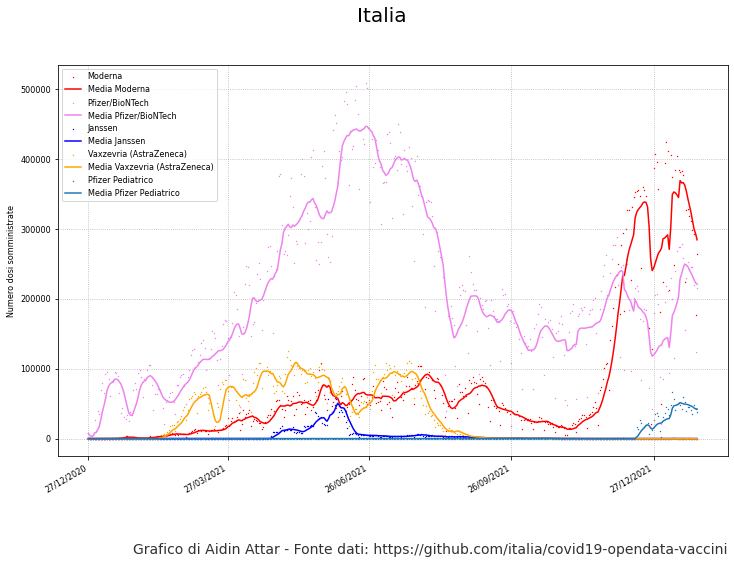

In [28]:
fig, ax = plt.subplots(figsize=(12,8))

colors=['red','violet','blue','orange','C0','violet','brown','black','plasma']
i=0
for key in italia_età.keys():
    ax.scatter(italia_età[key].index,italia_età[key]['totale'], color=colors[i],label=str(key),marker='x', s=0.2)
    italia_età[key]['media_totale'].plot(ax = ax,color=colors[i],label='Media '+str(key))
    i+=1

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
ax.legend(loc='best')
fig.suptitle("Italia", fontsize=20)
plt.rcParams['font.size'] = '8'
ax.tick_params(axis='both', labelsize=8)
ax.grid(alpha = 1,linestyle='dotted')
ax.set_ylabel('Numero dosi somministrate')
ax.set_xlabel("")
fig.autofmt_xdate()

plt.text(0.9, 0.05, 'Grafico di Aidin Attar - Fonte dati: https://github.com/italia/covid19-opendata-vaccini',
         transform=plt.gcf().transFigure,
         fontsize=14, color='black', alpha=0.8,
         ha='right', va='top', rotation='0')

plt.show()

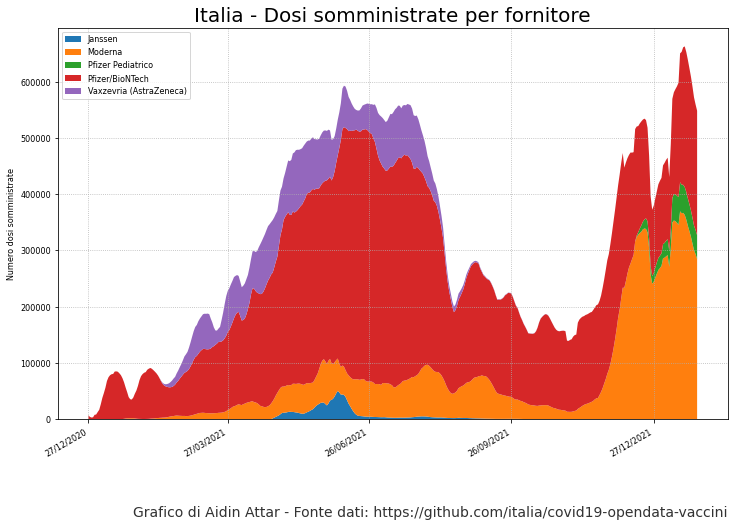

In [29]:
fig, ax = plt.subplots(figsize=(12,8))

colors=['red','violet','blue','orange','C0','violet','brown','yellow','green','black','purple']
ax.stackplot(italia_età['Pfizer/BioNTech'].index,[italia_età[key]['media_totale'] for key in sorted(italia_età.keys())])

label=[key for key in sorted(italia_età.keys())]
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
ax.legend(label,loc='upper left')
ax.set_title("Italia - Dosi somministrate per fornitore", fontsize=20)
plt.rcParams['font.size'] = '8'
ax.tick_params(axis='both', labelsize=8)
ax.grid(alpha = 1,linestyle='dotted')
ax.set_ylabel('Numero dosi somministrate')
ax.set_xlabel("")
fig.autofmt_xdate()

plt.text(0.9, 0.05, 'Grafico di Aidin Attar - Fonte dati: https://github.com/italia/covid19-opendata-vaccini',
         transform=plt.gcf().transFigure,
         fontsize=14, color='black', alpha=0.8,
         ha='right', va='top', rotation='0')

plt.show()

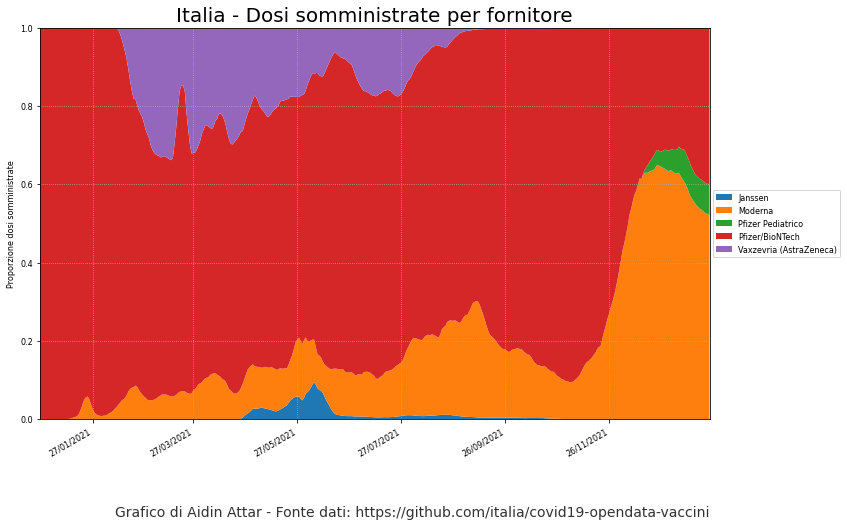

In [30]:
fig, ax = plt.subplots(figsize=(12,8))

colors=['red','violet','blue','orange','C0','violet','brown','yellow','green','black','purple']
ax.stackplot(italia_età['Pfizer/BioNTech'].index,[italia_età[key]['media_totale']/sum(italia_età[key1]['media_totale'] for key1 in italia_età.keys()) for key in sorted(italia_età.keys())])

label=[key for key in sorted(italia_età.keys())]
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax.set_title("Italia - Dosi somministrate per fornitore", fontsize=20)
plt.rcParams['font.size'] = '8'
ax.tick_params(axis='both', labelsize=8)
ax.grid(alpha = 1,linestyle='dotted')
ax.set_ylabel('Proporzione dosi somministrate')
ax.set_xlabel("")
fig.autofmt_xdate()
ax.set_ylim(top=1)
ax.set_xlim([date(2020, 12, 27).strftime('%d/%m/%Y'), yesterday.strftime('%d/%m/%Y')])
ax.legend(label, loc = 'center', bbox_to_anchor=(1.1, 0.5))

plt.text(0.9, 0.05, 'Grafico di Aidin Attar - Fonte dati: https://github.com/italia/covid19-opendata-vaccini',
         transform=plt.gcf().transFigure,
         fontsize=14, color='black', alpha=0.8,
         ha='right', va='top', rotation='0')

plt.show()

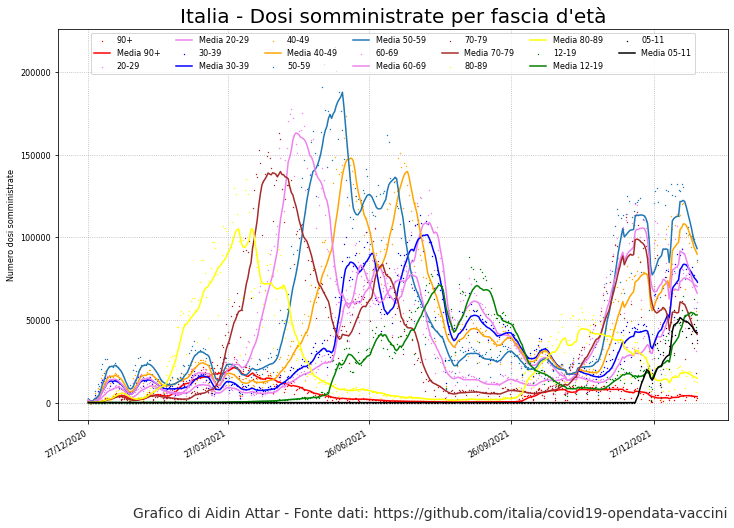

In [31]:
fig, ax = plt.subplots(figsize=(12,8))

colors=['red','violet','blue','orange','C0','violet','brown','yellow','green','black','purple']
i=0
for key in italia_fornitori.keys():
    ax.scatter(italia_fornitori[key].index,italia_fornitori[key]['totale'], c=colors[i],label=str(key),marker='x', s=0.2)
    italia_fornitori[key]['media_totale'].plot(ax = ax,color=colors[i],label='Media '+str(key))
    i+=1

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
ax.legend(loc='upper center', ncol=7)
ax.set_title("Italia - Dosi somministrate per fascia d'età", fontsize=20)
plt.rcParams['font.size'] = '8'
ax.tick_params(axis='both', labelsize=8)
ax.grid(alpha = 1,linestyle='dotted')
ax.set_ylabel('Numero dosi somministrate')
ax.set_xlabel("")
fig.autofmt_xdate()

plt.text(0.9, 0.05, 'Grafico di Aidin Attar - Fonte dati: https://github.com/italia/covid19-opendata-vaccini',
         transform=plt.gcf().transFigure,
         fontsize=14, color='black', alpha=0.8,
         ha='right', va='top', rotation='0')

plt.show()

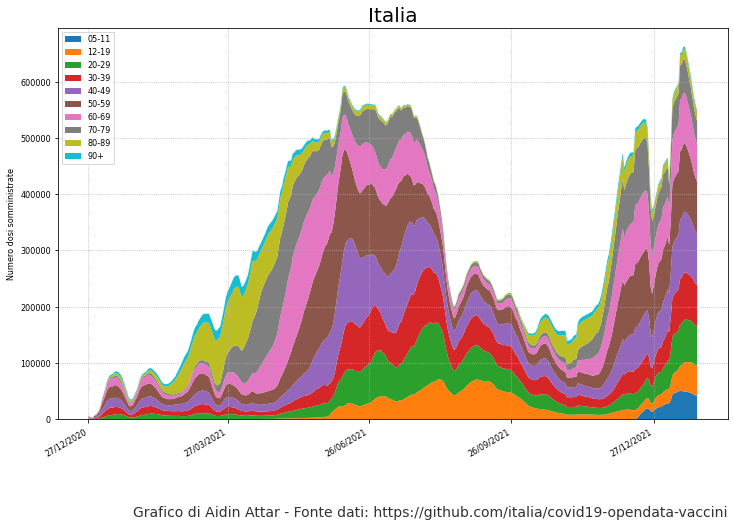

In [32]:
fig, ax = plt.subplots(figsize=(12,8))

colors=['red','violet','blue','orange','C0','violet','brown','yellow','green','black','purple']
ax.stackplot(italia_fornitori['50-59'].index,[italia_fornitori[key]['media_totale'] for key in sorted(italia_fornitori.keys())])

label=[key for key in sorted(italia_fornitori.keys())]
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
ax.legend(label,loc='upper left')
ax.set_title("Italia", fontsize=20)
plt.rcParams['font.size'] = '8'
ax.tick_params(axis='both', labelsize=8)
ax.grid(alpha = 1,linestyle='dotted')
ax.set_ylabel('Numero dosi somministrate')
ax.set_xlabel("")
fig.autofmt_xdate()

plt.text(0.9, 0.05, 'Grafico di Aidin Attar - Fonte dati: https://github.com/italia/covid19-opendata-vaccini',
         transform=plt.gcf().transFigure,
         fontsize=14, color='black', alpha=0.8,
         ha='right', va='top', rotation='0')

plt.show()

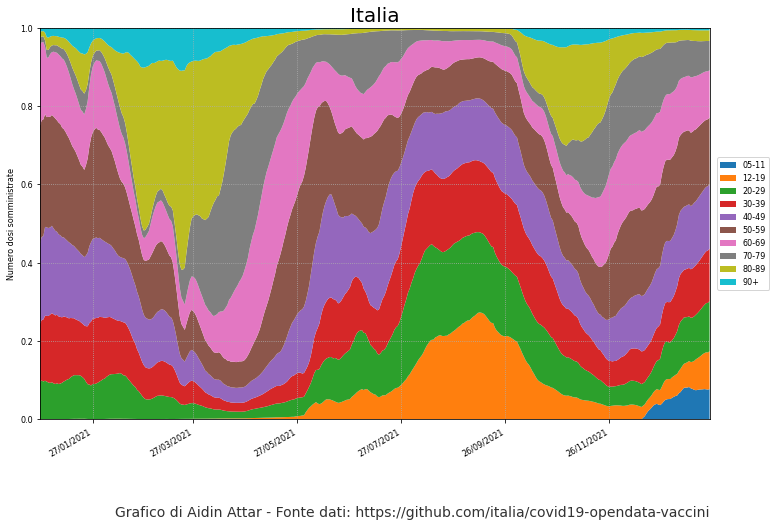

In [33]:
fig, ax = plt.subplots(figsize=(12,8))

colors=['red','violet','blue','orange','C0','violet','brown','yellow','green','black','purple']
ax.stackplot(italia_fornitori['50-59'].index,[italia_fornitori[key]['media_totale']/sum(italia_fornitori[key1]['media_totale'] for key1 in italia_fornitori.keys()) for key in sorted(italia_fornitori.keys())])

label=[key for key in sorted(italia_fornitori.keys())]
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax.set_title("Italia", fontsize=20)
plt.rcParams['font.size'] = '8'
ax.tick_params(axis='both', labelsize=8)
ax.grid(alpha = 1,linestyle='dotted')
ax.set_ylabel('Numero dosi somministrate')
ax.set_xlabel("")
fig.autofmt_xdate()
ax.set_ylim(top=1)
ax.set_xlim([date(2020, 12, 27).strftime('%d/%m/%Y'), yesterday.strftime('%d/%m/%Y')])
ax.legend(label, loc = 'center', bbox_to_anchor=(1.05, 0.5))

plt.text(0.9, 0.05, 'Grafico di Aidin Attar - Fonte dati: https://github.com/italia/covid19-opendata-vaccini',
         transform=plt.gcf().transFigure,
         fontsize=14, color='black', alpha=0.8,
         ha='right', va='top', rotation='0')

plt.show()

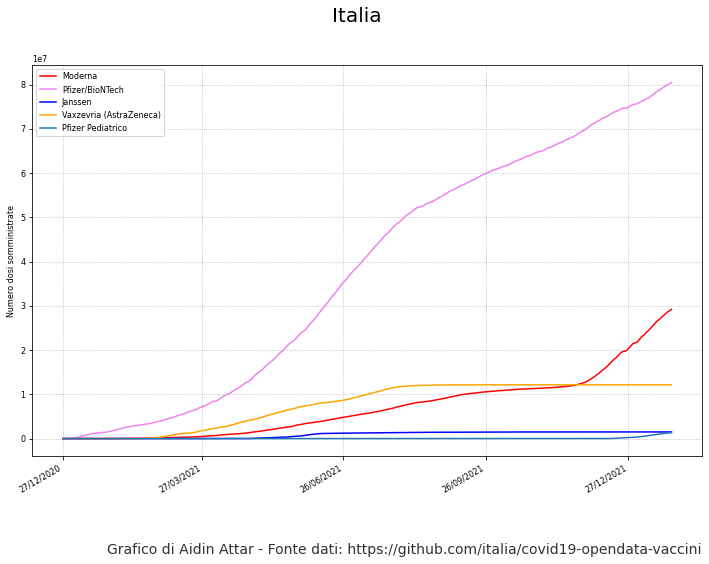

In [34]:
fig, ax = plt.subplots(figsize=(12,8))

colors=['red','violet','blue','orange','C0','violet','brown','black','plasma']
i=0
for key in italia_età.keys():
    ax.plot(italia_età[key].index,italia_età[key]['cumulativa_totale'], color=colors[i],label=str(key))
    #italia_età[key]['media_totale'].plot(ax = ax,color=colors[i],label='Media '+str(key))
    i+=1

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
ax.legend(loc='best')
fig.suptitle("Italia", fontsize=20)
plt.rcParams['font.size'] = '8'
ax.tick_params(axis='both', labelsize=8)
ax.grid(alpha = 1,linestyle='dotted')
ax.set_ylabel('Numero dosi somministrate')
ax.set_xlabel("")
fig.autofmt_xdate()

plt.text(0.9, 0.05, 'Grafico di Aidin Attar - Fonte dati: https://github.com/italia/covid19-opendata-vaccini',
         transform=plt.gcf().transFigure,
         fontsize=14, color='black', alpha=0.8,
         ha='right', va='top', rotation='0')

plt.show()

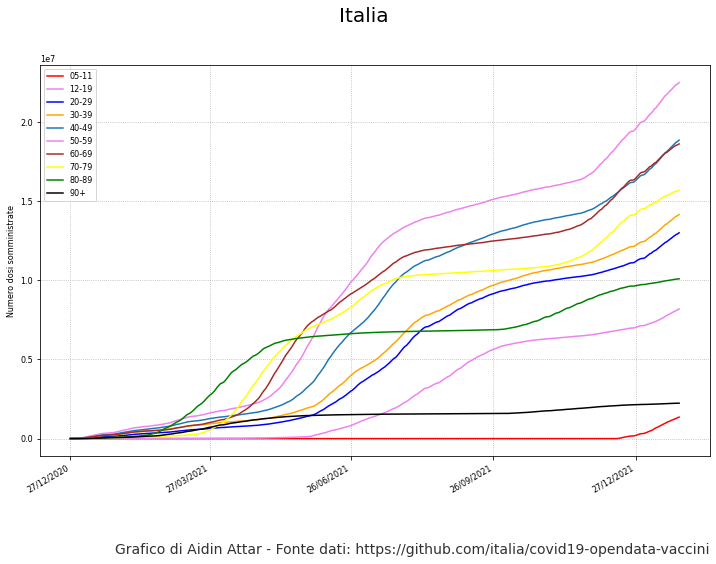

In [35]:
fig, ax = plt.subplots(figsize=(12,8))

colors=['red','violet','blue','orange','C0','violet','brown','yellow','green','black','purple']
i=0
for key in sorted(italia_fornitori.keys()):
    ax.plot(italia_fornitori[key].index,italia_fornitori[key]['cumulativa_totale'], color=colors[i],label=str(key))
    i+=1
    #.plot(ax = ax,color=colors,label='Media '+str(key))

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
ax.legend(loc='best')
fig.suptitle("Italia", fontsize=20)
plt.rcParams['font.size'] = '8'
ax.tick_params(axis='both', labelsize=8)
ax.grid(alpha = 1,linestyle='dotted')
ax.set_ylabel('Numero dosi somministrate')
ax.set_xlabel("")
fig.autofmt_xdate()

plt.text(0.9, 0.05, 'Grafico di Aidin Attar - Fonte dati: https://github.com/italia/covid19-opendata-vaccini',
         transform=plt.gcf().transFigure,
         fontsize=14, color='black', alpha=0.8,
         ha='right', va='top', rotation='0')

plt.show()

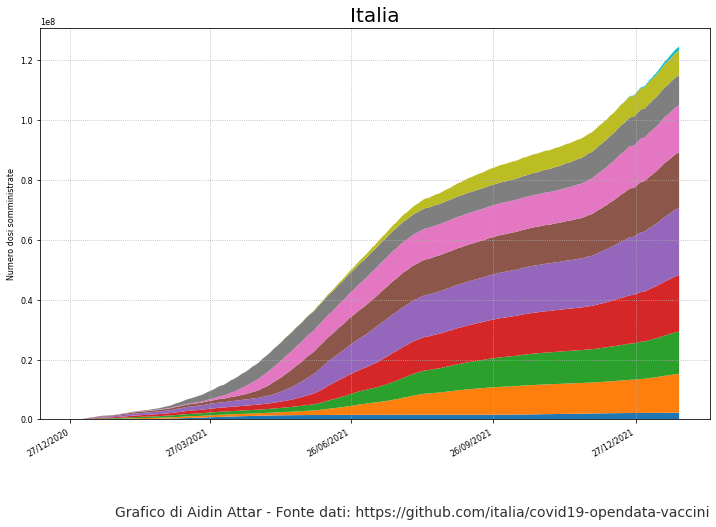

In [36]:
fig, ax = plt.subplots(figsize=(12,8))

colors=['red','violet','blue','orange','C0','violet','brown','yellow','green','black','purple']
ax.stackplot(italia_fornitori['50-59'].index,[italia_fornitori[key]['cumulativa_totale'] for key in italia_fornitori.keys()])

label=[key for key in sorted(italia_fornitori.keys())]
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
ax.set_title("Italia", fontsize=20)
plt.rcParams['font.size'] = '8'
ax.tick_params(axis='both', labelsize=8)
ax.grid(alpha = 1,linestyle='dotted')
ax.set_ylabel('Numero dosi somministrate')
ax.set_xlabel("")
fig.autofmt_xdate()

plt.text(0.9, 0.05, 'Grafico di Aidin Attar - Fonte dati: https://github.com/italia/covid19-opendata-vaccini',
         transform=plt.gcf().transFigure,
         fontsize=14, color='black', alpha=0.8,
         ha='right', va='top', rotation='0')

plt.show()

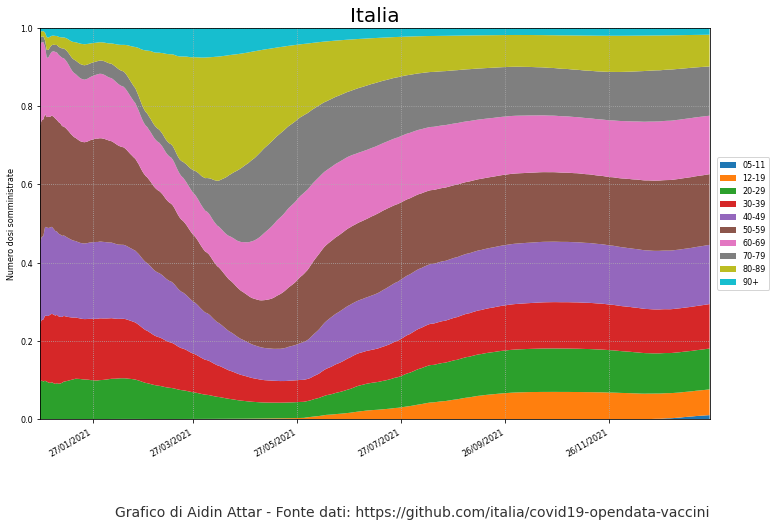

In [37]:
fig, ax = plt.subplots(figsize=(12,8))

colors=['red','violet','blue','orange','C0','violet','brown','yellow','green','black','purple']
ax.stackplot(italia_fornitori['50-59'].index,[italia_fornitori[key]['cumulativa_totale']/sum(italia_fornitori[key1]['cumulativa_totale'] for key1 in italia_fornitori.keys()) for key in sorted(italia_fornitori.keys())])

label=[key for key in sorted(italia_fornitori.keys())]
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax.set_title("Italia", fontsize=20)
plt.rcParams['font.size'] = '8'
ax.tick_params(axis='both', labelsize=8)
ax.grid(alpha = 1,linestyle='dotted')
ax.set_ylabel('Numero dosi somministrate')
ax.set_xlabel("")
fig.autofmt_xdate()
ax.set_ylim(top=1)
ax.set_xlim([date(2020, 12, 27).strftime('%d/%m/%Y'), yesterday.strftime('%d/%m/%Y')])
ax.legend(label, loc = 'center', bbox_to_anchor=(1.05, 0.5))

plt.text(0.9, 0.05, 'Grafico di Aidin Attar - Fonte dati: https://github.com/italia/covid19-opendata-vaccini',
         transform=plt.gcf().transFigure,
         fontsize=14, color='black', alpha=0.8,
         ha='right', va='top', rotation='0')

plt.show()

In [38]:
PlateaFasce=sorted(platea.fascia_anagrafica.unique())
Platea_Italia=dict()

for f in PlateaFasce:
    Platea_Italia[f]=platea.groupby('fascia_anagrafica').get_group(f)['totale_popolazione'].sum()
Platea_Italia

{'05-11': 3656069,
 '12-19': 4620379,
 '20-29': 6010545,
 '30-39': 6794108,
 '40-49': 8782667,
 '50-59': 9645613,
 '60-69': 7552718,
 '70-79': 6016425,
 '80+': 4587490}

In [39]:
new_italia_fornitori = copy.deepcopy(italia_fornitori)
new_italia_fornitori['80+'] = copy.deepcopy(italia_fornitori['90+'])
new_italia_fornitori['80+'][                  'totale'] = italia_fornitori['80-89'][                  'totale']+italia_fornitori['90+'][                  'totale']
new_italia_fornitori['80+'][          'sesso_maschile'] = italia_fornitori['80-89'][          'sesso_maschile']+italia_fornitori['90+'][          'sesso_maschile']
new_italia_fornitori['80+'][         'sesso_femminile'] = italia_fornitori['80-89'][         'sesso_femminile']+italia_fornitori['90+'][         'sesso_femminile']
new_italia_fornitori['80+'][              'prima_dose'] = italia_fornitori['80-89'][              'prima_dose']+italia_fornitori['90+'][              'prima_dose']
new_italia_fornitori['80+'][            'seconda_dose'] = italia_fornitori['80-89'][            'seconda_dose']+italia_fornitori['90+'][            'seconda_dose']
new_italia_fornitori['80+'][     'pregressa_infezione'] = italia_fornitori['80-89'][     'pregressa_infezione']+italia_fornitori['90+'][     'pregressa_infezione']
new_italia_fornitori['80+']['dose_addizionale_booster'] = italia_fornitori['80-89']['dose_addizionale_booster']+italia_fornitori['90+']['dose_addizionale_booster']
new_italia_fornitori.pop('80-89')
new_italia_fornitori.pop('90+')

for key1 in new_italia_fornitori.keys():
    new_italia_fornitori[key1][                  'media_totale'] = new_italia_fornitori[key1]['totale'].rolling(window=7, min_periods=1).mean()
    new_italia_fornitori[key1][          'media_sesso_maschile'] = new_italia_fornitori[key1]['sesso_maschile'].rolling(window=7, min_periods=1).mean()
    new_italia_fornitori[key1][         'media_sesso_femminile'] = new_italia_fornitori[key1]['sesso_femminile'].rolling(window=7, min_periods=1).mean()
    new_italia_fornitori[key1][              'media_prima_dose'] = new_italia_fornitori[key1]['prima_dose'].rolling(window=7, min_periods=1).mean()
    new_italia_fornitori[key1][            'media_seconda_dose'] = new_italia_fornitori[key1]['seconda_dose'].rolling(window=7, min_periods=1).mean()
    new_italia_fornitori[key1][     'media_pregressa_infezione'] = new_italia_fornitori[key1]['pregressa_infezione'].rolling(window=7, min_periods=1).mean()
    new_italia_fornitori[key1]['media_dose_addizionale_booster'] = new_italia_fornitori[key1]['dose_addizionale_booster'].rolling(window=7, min_periods=1).mean()
    new_italia_fornitori[key1][                  'cumulativa_totale'] = new_italia_fornitori[key1][                  'totale'].cumsum()
    new_italia_fornitori[key1][          'cumulativa_sesso_maschile'] = new_italia_fornitori[key1][          'sesso_maschile'].cumsum()
    new_italia_fornitori[key1][         'cumulativa_sesso_femminile'] = new_italia_fornitori[key1][         'sesso_femminile'].cumsum()
    new_italia_fornitori[key1][              'cumulativa_prima_dose'] = new_italia_fornitori[key1][              'prima_dose'].cumsum()
    new_italia_fornitori[key1][            'cumulativa_seconda_dose'] = new_italia_fornitori[key1][            'seconda_dose'].cumsum()
    new_italia_fornitori[key1][     'cumulativa_pregressa_infezione'] = new_italia_fornitori[key1][     'pregressa_infezione'].cumsum()
    new_italia_fornitori[key1]['cumulativa_dose_addizionale_booster'] = new_italia_fornitori[key1]['dose_addizionale_booster'].cumsum()

    new_italia_fornitori[key1][                  'perc_cumulativa_totale'] = new_italia_fornitori[key1][                  'cumulativa_totale'] / Platea_Italia[key1] * 100
    new_italia_fornitori[key1][          'perc_cumulativa_sesso_maschile'] = new_italia_fornitori[key1][          'cumulativa_sesso_maschile'] / Platea_Italia[key1] * 100
    new_italia_fornitori[key1][         'perc_cumulativa_sesso_femminile'] = new_italia_fornitori[key1][         'cumulativa_sesso_femminile'] / Platea_Italia[key1] * 100
    new_italia_fornitori[key1][              'perc_cumulativa_prima_dose'] = new_italia_fornitori[key1][              'cumulativa_prima_dose'] / Platea_Italia[key1] * 100
    new_italia_fornitori[key1][            'perc_cumulativa_seconda_dose'] = new_italia_fornitori[key1][            'cumulativa_seconda_dose'] / Platea_Italia[key1] * 100
    new_italia_fornitori[key1][     'perc_cumulativa_pregressa_infezione'] = new_italia_fornitori[key1][     'cumulativa_pregressa_infezione'] / Platea_Italia[key1] * 100
    new_italia_fornitori[key1]['perc_cumulativa_dose_addizionale_booster'] = new_italia_fornitori[key1]['cumulativa_dose_addizionale_booster'] / Platea_Italia[key1] * 100

    new_italia_fornitori[key1][                  'rimasti_cumulativa_totale'] = Platea_Italia[key1] - new_italia_fornitori[key1][                  'cumulativa_totale']
    new_italia_fornitori[key1][          'rimasti_cumulativa_sesso_maschile'] = Platea_Italia[key1] - new_italia_fornitori[key1][          'cumulativa_sesso_maschile']
    new_italia_fornitori[key1][         'rimasti_cumulativa_sesso_femminile'] = Platea_Italia[key1] - new_italia_fornitori[key1][         'cumulativa_sesso_femminile']
    new_italia_fornitori[key1][              'rimasti_cumulativa_prima_dose'] = Platea_Italia[key1] - new_italia_fornitori[key1][              'cumulativa_prima_dose']
    new_italia_fornitori[key1][            'rimasti_cumulativa_seconda_dose'] = Platea_Italia[key1] - new_italia_fornitori[key1][            'cumulativa_seconda_dose']
    new_italia_fornitori[key1][     'rimasti_cumulativa_pregressa_infezione'] = Platea_Italia[key1] - new_italia_fornitori[key1][     'cumulativa_pregressa_infezione']
    new_italia_fornitori[key1]['rimasti_cumulativa_dose_addizionale_booster'] = Platea_Italia[key1] - new_italia_fornitori[key1]['cumulativa_dose_addizionale_booster']

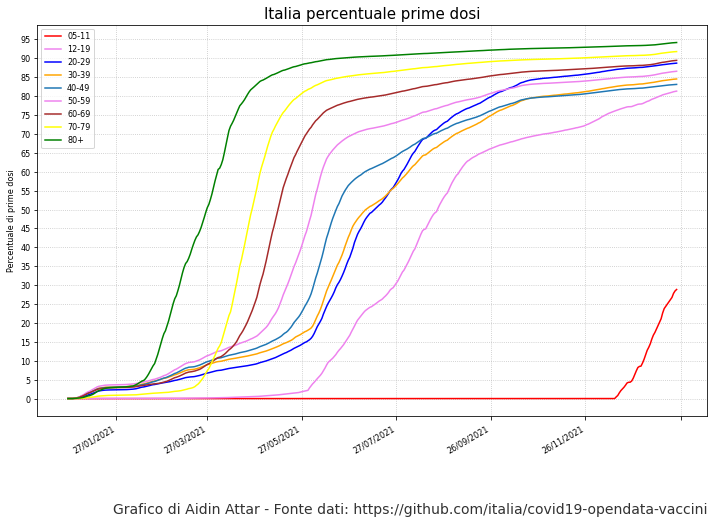

In [40]:
fig, ax = plt.subplots(figsize=(12,8))

colors=['red','violet','blue','orange','C0','violet','brown','yellow','green','black','purple']
i=0
for key in sorted(new_italia_fornitori.keys()):
    ax.plot(new_italia_fornitori[key].index,new_italia_fornitori[key]['perc_cumulativa_prima_dose'], color=colors[i],label=str(key))
    i+=1

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax.legend(loc='best')
ax.set_title("Italia percentuale prime dosi", fontsize=15)
plt.rcParams['font.size'] = '8'
ax.yaxis.set_major_locator(MultipleLocator(5))
ax.tick_params(axis='both', labelsize=8)
ax.grid(alpha = 0.8,linestyle='dotted')
ax.set_ylabel('Percentuale di prime dosi')
ax.set_xlabel("")
fig.autofmt_xdate()

plt.text(0.9, 0.05, 'Grafico di Aidin Attar - Fonte dati: https://github.com/italia/covid19-opendata-vaccini',
         transform=plt.gcf().transFigure,
         fontsize=14, color='black', alpha=0.8,
         ha='right', va='top', rotation='0')

plt.show()

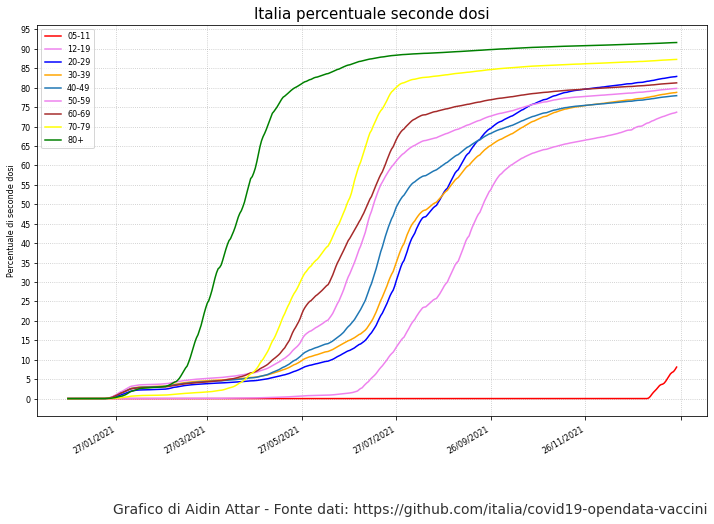

In [41]:
fig, ax = plt.subplots(figsize=(12,8))

colors=['red','violet','blue','orange','C0','violet','brown','yellow','green','black','purple']
i=0
for key in sorted(new_italia_fornitori.keys()):
    ax.plot(new_italia_fornitori[key].index,new_italia_fornitori[key]['perc_cumulativa_seconda_dose'], color=colors[i],label=str(key))
    i+=1
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax.legend(loc='best')
ax.set_title("Italia percentuale seconde dosi", fontsize=15)
ax.yaxis.set_major_locator(MultipleLocator(5))
plt.rcParams['font.size'] = '8'
ax.tick_params(axis='both', labelsize=8)
ax.grid(alpha = 0.8,linestyle='dotted')
ax.set_ylabel('Percentuale di seconde dosi')
ax.set_xlabel("")
fig.autofmt_xdate()

plt.text(0.9, 0.05, 'Grafico di Aidin Attar - Fonte dati: https://github.com/italia/covid19-opendata-vaccini',
         transform=plt.gcf().transFigure,
         fontsize=14, color='black', alpha=0.8,
         ha='right', va='top', rotation='0')

plt.show()

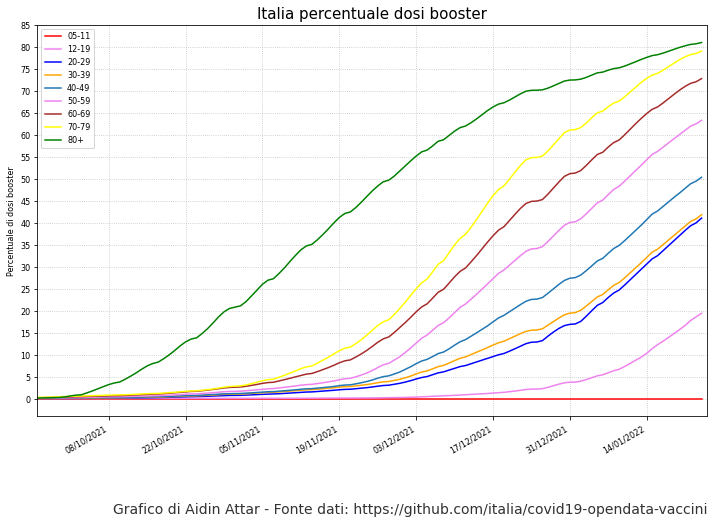

In [42]:
fig, ax = plt.subplots(figsize=(12,8))

colors=['red','violet','blue','orange','C0','violet','brown','yellow','green','black','purple']
i=0
for key in sorted(new_italia_fornitori.keys()):
    ax.plot(new_italia_fornitori[key].index,new_italia_fornitori[key]['perc_cumulativa_dose_addizionale_booster'], color=colors[i],label=str(key))
    i+=1
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
ax.set_xlim([date(2021, 9, 25).strftime('%d/%m/%Y'), today.strftime('%d/%m/%Y')])
ax.legend(loc='best')
ax.set_title("Italia percentuale dosi booster", fontsize=15)
ax.yaxis.set_major_locator(MultipleLocator(5))
plt.rcParams['font.size'] = '8'
ax.tick_params(axis='both', labelsize=8)
ax.grid(alpha = 0.8,linestyle='dotted')
ax.set_ylabel('Percentuale di dosi booster')
ax.set_xlabel("")
fig.autofmt_xdate()

plt.text(0.9, 0.05, 'Grafico di Aidin Attar - Fonte dati: https://github.com/italia/covid19-opendata-vaccini',
         transform=plt.gcf().transFigure,
         fontsize=14, color='black', alpha=0.8,
         ha='right', va='top', rotation='0')

plt.show()

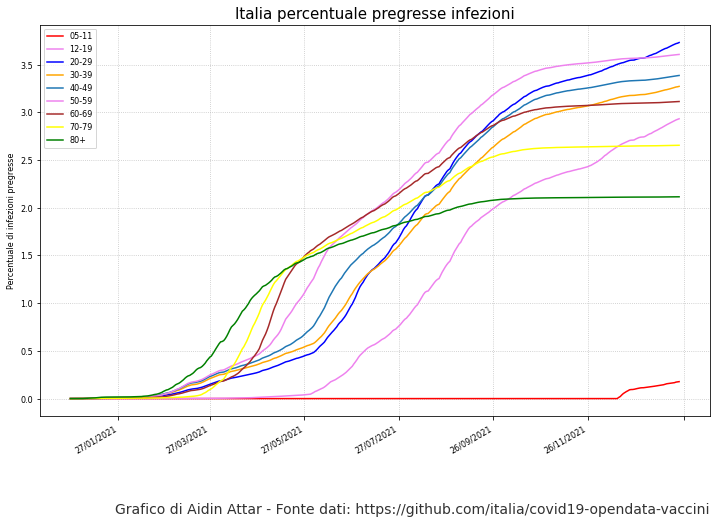

In [43]:
fig, ax = plt.subplots(figsize=(12,8))

colors=['red','violet','blue','orange','C0','violet','brown','yellow','green','black','purple']
i=0
for key in sorted(new_italia_fornitori.keys()):
    ax.plot(new_italia_fornitori[key].index,new_italia_fornitori[key]['perc_cumulativa_pregressa_infezione'], color=colors[i],label=str(key))
    i+=1
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
#ax.set_xlim([date(2021, 9, 25).strftime('%d/%m/%Y'), yesterday.strftime('%d/%m/%Y')])
ax.legend(loc='best')
ax.set_title("Italia percentuale pregresse infezioni", fontsize=15)
#ax.yaxis.set_major_locator(MultipleLocator(5))
plt.rcParams['font.size'] = '8'
ax.tick_params(axis='both', labelsize=8)
ax.grid(alpha = 0.8,linestyle='dotted')
ax.set_ylabel('Percentuale di infezioni pregresse')
ax.set_xlabel("")
fig.autofmt_xdate()

plt.text(0.9, 0.05, 'Grafico di Aidin Attar - Fonte dati: https://github.com/italia/covid19-opendata-vaccini',
         transform=plt.gcf().transFigure,
         fontsize=14, color='black', alpha=0.8,
         ha='right', va='top', rotation='0')

plt.show()

In [44]:
somministrazioni_età={elem1:{elem2:pd.DataFrame for elem2 in NomiFornitori} for elem1 in NomiRegioni}
for key in somministrazioni_età.keys():
    somministrazioni_età[key] = copy.deepcopy(somministrazioni_età_fornitori[key]['20-29'])

for key1 in somministrazioni_età.keys():
    for key2 in somministrazioni_età[key1].keys():
        somministrazioni_età[key1][key2][                         'totale'] = sum(somministrazioni_età_fornitori[key1][key][key2][                  'totale'].fillna(0) for key in somministrazioni_età_fornitori[key1].keys())
        somministrazioni_età[key1][key2][                 'sesso_maschile'] = sum(somministrazioni_età_fornitori[key1][key][key2][          'sesso_maschile'].fillna(0) for key in somministrazioni_età_fornitori[key1].keys())
        somministrazioni_età[key1][key2][                'sesso_femminile'] = sum(somministrazioni_età_fornitori[key1][key][key2][         'sesso_femminile'].fillna(0) for key in somministrazioni_età_fornitori[key1].keys())
        somministrazioni_età[key1][key2][                     'prima_dose'] = sum(somministrazioni_età_fornitori[key1][key][key2][              'prima_dose'].fillna(0) for key in somministrazioni_età_fornitori[key1].keys())
        somministrazioni_età[key1][key2][                   'seconda_dose'] = sum(somministrazioni_età_fornitori[key1][key][key2][            'seconda_dose'].fillna(0) for key in somministrazioni_età_fornitori[key1].keys())
        somministrazioni_età[key1][key2][            'pregressa_infezione'] = sum(somministrazioni_età_fornitori[key1][key][key2][     'pregressa_infezione'].fillna(0) for key in somministrazioni_età_fornitori[key1].keys())
        somministrazioni_età[key1][key2][       'dose_addizionale_booster'] = sum(somministrazioni_età_fornitori[key1][key][key2]['dose_addizionale_booster'].fillna(0) for key in somministrazioni_età_fornitori[key1].keys())

        somministrazioni_età[key1][key2][                  'totale_per100'] = somministrazioni_età[key1][key2][                  'totale'] / DictRegioni[key1] * 100
        somministrazioni_età[key1][key2][          'sesso_maschile_per100'] = somministrazioni_età[key1][key2][          'sesso_maschile'] / DictRegioni[key1] * 100
        somministrazioni_età[key1][key2][         'sesso_femminile_per100'] = somministrazioni_età[key1][key2][         'sesso_femminile'] / DictRegioni[key1] * 100
        somministrazioni_età[key1][key2][              'prima_dose_per100'] = somministrazioni_età[key1][key2][              'prima_dose'] / DictRegioni[key1] * 100
        somministrazioni_età[key1][key2][            'seconda_dose_per100'] = somministrazioni_età[key1][key2][            'seconda_dose'] / DictRegioni[key1] * 100
        somministrazioni_età[key1][key2][     'pregressa_infezione_per100'] = somministrazioni_età[key1][key2][     'pregressa_infezione'] / DictRegioni[key1] * 100
        somministrazioni_età[key1][key2]['dose_addizionale_booster_per100'] = somministrazioni_età[key1][key2]['dose_addizionale_booster'] / DictRegioni[key1] * 100

for key1 in somministrazioni_età.keys():
    for key2 in somministrazioni_età[key1].keys():
        somministrazioni_età[key1][key2][                              'media_totale'] = somministrazioni_età[key1][key2][                                'totale'].rolling(window=7, min_periods=1).mean()
        somministrazioni_età[key1][key2][                      'media_sesso_maschile'] = somministrazioni_età[key1][key2][                        'sesso_maschile'].rolling(window=7, min_periods=1).mean()
        somministrazioni_età[key1][key2][                     'media_sesso_femminile'] = somministrazioni_età[key1][key2][                       'sesso_femminile'].rolling(window=7, min_periods=1).mean()
        somministrazioni_età[key1][key2][                          'media_prima_dose'] = somministrazioni_età[key1][key2][                            'prima_dose'].rolling(window=7, min_periods=1).mean()
        somministrazioni_età[key1][key2][                        'media_seconda_dose'] = somministrazioni_età[key1][key2][                          'seconda_dose'].rolling(window=7, min_periods=1).mean()
        somministrazioni_età[key1][key2][                 'media_pregressa_infezione'] = somministrazioni_età[key1][key2][                   'pregressa_infezione'].rolling(window=7, min_periods=1).mean()
        somministrazioni_età[key1][key2][            'media_dose_addizionale_booster'] = somministrazioni_età[key1][key2][              'dose_addizionale_booster'].rolling(window=7, min_periods=1).mean()
        somministrazioni_età[key1][key2][                       'media_totale_per100'] = somministrazioni_età[key1][key2][                         'totale_per100'].rolling(window=7, min_periods=1).mean()
        somministrazioni_età[key1][key2][               'media_sesso_maschile_per100'] = somministrazioni_età[key1][key2][                 'sesso_maschile_per100'].rolling(window=7, min_periods=1).mean()
        somministrazioni_età[key1][key2][              'media_sesso_femminile_per100'] = somministrazioni_età[key1][key2][                'sesso_femminile_per100'].rolling(window=7, min_periods=1).mean()
        somministrazioni_età[key1][key2][                   'media_prima_dose_per100'] = somministrazioni_età[key1][key2][                     'prima_dose_per100'].rolling(window=7, min_periods=1).mean()
        somministrazioni_età[key1][key2][                 'media_seconda_dose_per100'] = somministrazioni_età[key1][key2][                   'seconda_dose_per100'].rolling(window=7, min_periods=1).mean()
        somministrazioni_età[key1][key2][          'media_pregressa_infezione_per100'] = somministrazioni_età[key1][key2][            'pregressa_infezione_per100'].rolling(window=7, min_periods=1).mean()
        somministrazioni_età[key1][key2][     'media_dose_addizionale_booster_per100'] = somministrazioni_età[key1][key2][       'dose_addizionale_booster_per100'].rolling(window=7, min_periods=1).mean()
        somministrazioni_età[key1][key2][                         'cumulativa_totale'] = somministrazioni_età[key1][key2][                                'totale'].cumsum()
        somministrazioni_età[key1][key2][                 'cumulativa_sesso_maschile'] = somministrazioni_età[key1][key2][                        'sesso_maschile'].cumsum()
        somministrazioni_età[key1][key2][                'cumulativa_sesso_femminile'] = somministrazioni_età[key1][key2][                       'sesso_femminile'].cumsum()
        somministrazioni_età[key1][key2][                     'cumulativa_prima_dose'] = somministrazioni_età[key1][key2][                            'prima_dose'].cumsum()
        somministrazioni_età[key1][key2][                   'cumulativa_seconda_dose'] = somministrazioni_età[key1][key2][                          'seconda_dose'].cumsum()
        somministrazioni_età[key1][key2][            'cumulativa_pregressa_infezione'] = somministrazioni_età[key1][key2][                   'pregressa_infezione'].cumsum()
        somministrazioni_età[key1][key2][       'cumulativa_dose_addizionale_booster'] = somministrazioni_età[key1][key2][              'dose_addizionale_booster'].cumsum()
        somministrazioni_età[key1][key2][                  'cumulativa_totale_per100'] = somministrazioni_età[key1][key2][                         'totale_per100'].cumsum()
        somministrazioni_età[key1][key2][          'cumulativa_sesso_maschile_per100'] = somministrazioni_età[key1][key2][                 'sesso_maschile_per100'].cumsum()
        somministrazioni_età[key1][key2][         'cumulativa_sesso_femminile_per100'] = somministrazioni_età[key1][key2][                'sesso_femminile_per100'].cumsum()
        somministrazioni_età[key1][key2][              'cumulativa_prima_dose_per100'] = somministrazioni_età[key1][key2][                     'prima_dose_per100'].cumsum()
        somministrazioni_età[key1][key2][            'cumulativa_seconda_dose_per100'] = somministrazioni_età[key1][key2][                   'seconda_dose_per100'].cumsum()
        somministrazioni_età[key1][key2][     'cumulativa_pregressa_infezione_per100'] = somministrazioni_età[key1][key2][            'pregressa_infezione_per100'].cumsum()
        somministrazioni_età[key1][key2]['cumulativa_dose_addizionale_booster_per100'] = somministrazioni_età[key1][key2][       'dose_addizionale_booster_per100'].cumsum()

In [45]:
somministrazioni_fornitori={elem1:{elem2:pd.DataFrame for elem2 in FasceAnagrafiche} for elem1 in NomiRegioni}

for key in somministrazioni_fornitori.keys():
    somministrazioni_fornitori[key] = copy.deepcopy(somministrazioni_fornitori_età[key]['Pfizer/BioNTech'])

for key1 in somministrazioni_fornitori.keys():
    for key2 in somministrazioni_fornitori[key1].keys():
        somministrazioni_fornitori[key1][key2][                                    'totale'] = sum(somministrazioni_fornitori_età[key1][key][key2][                  'totale'].fillna(0) for key in somministrazioni_fornitori_età[key1].keys())
        somministrazioni_fornitori[key1][key2][                            'sesso_maschile'] = sum(somministrazioni_fornitori_età[key1][key][key2][          'sesso_maschile'].fillna(0) for key in somministrazioni_fornitori_età[key1].keys())
        somministrazioni_fornitori[key1][key2][                           'sesso_femminile'] = sum(somministrazioni_fornitori_età[key1][key][key2][         'sesso_femminile'].fillna(0) for key in somministrazioni_fornitori_età[key1].keys())
        somministrazioni_fornitori[key1][key2][                                'prima_dose'] = sum(somministrazioni_fornitori_età[key1][key][key2][              'prima_dose'].fillna(0) for key in somministrazioni_fornitori_età[key1].keys())
        somministrazioni_fornitori[key1][key2][                              'seconda_dose'] = sum(somministrazioni_fornitori_età[key1][key][key2][            'seconda_dose'].fillna(0) for key in somministrazioni_fornitori_età[key1].keys())
        somministrazioni_fornitori[key1][key2][                       'pregressa_infezione'] = sum(somministrazioni_fornitori_età[key1][key][key2][     'pregressa_infezione'].fillna(0) for key in somministrazioni_fornitori_età[key1].keys())
        somministrazioni_fornitori[key1][key2][                  'dose_addizionale_booster'] = sum(somministrazioni_fornitori_età[key1][key][key2]['dose_addizionale_booster'].fillna(0) for key in somministrazioni_fornitori_età[key1].keys())

        somministrazioni_fornitori[key1][key2][                             'totale_per100'] = somministrazioni_fornitori[key1][key2][                  'totale'] / DictRegioni[key1] * 100
        somministrazioni_fornitori[key1][key2][                     'sesso_maschile_per100'] = somministrazioni_fornitori[key1][key2][          'sesso_maschile'] / DictRegioni[key1] * 100
        somministrazioni_fornitori[key1][key2][                    'sesso_femminile_per100'] = somministrazioni_fornitori[key1][key2][         'sesso_femminile'] / DictRegioni[key1] * 100
        somministrazioni_fornitori[key1][key2][                         'prima_dose_per100'] = somministrazioni_fornitori[key1][key2][              'prima_dose'] / DictRegioni[key1] * 100
        somministrazioni_fornitori[key1][key2][                       'seconda_dose_per100'] = somministrazioni_fornitori[key1][key2][            'seconda_dose'] / DictRegioni[key1] * 100
        somministrazioni_fornitori[key1][key2][                'pregressa_infezione_per100'] = somministrazioni_fornitori[key1][key2][     'pregressa_infezione'] / DictRegioni[key1] * 100
        somministrazioni_fornitori[key1][key2][           'dose_addizionale_booster_per100'] = somministrazioni_fornitori[key1][key2]['dose_addizionale_booster'] / DictRegioni[key1] * 100

for key1 in somministrazioni_fornitori.keys():
    for key2 in somministrazioni_fornitori[key1].keys():
        somministrazioni_fornitori[key1][key2][                              'media_totale'] = somministrazioni_fornitori[key1][key2][                         'totale'].rolling(window=7, min_periods=1).mean()
        somministrazioni_fornitori[key1][key2][                      'media_sesso_maschile'] = somministrazioni_fornitori[key1][key2][                 'sesso_maschile'].rolling(window=7, min_periods=1).mean()
        somministrazioni_fornitori[key1][key2][                     'media_sesso_femminile'] = somministrazioni_fornitori[key1][key2][                'sesso_femminile'].rolling(window=7, min_periods=1).mean()
        somministrazioni_fornitori[key1][key2][                          'media_prima_dose'] = somministrazioni_fornitori[key1][key2][                     'prima_dose'].rolling(window=7, min_periods=1).mean()
        somministrazioni_fornitori[key1][key2][                        'media_seconda_dose'] = somministrazioni_fornitori[key1][key2][                   'seconda_dose'].rolling(window=7, min_periods=1).mean()
        somministrazioni_fornitori[key1][key2][                 'media_pregressa_infezione'] = somministrazioni_fornitori[key1][key2][            'pregressa_infezione'].rolling(window=7, min_periods=1).mean()
        somministrazioni_fornitori[key1][key2][            'media_dose_addizionale_booster'] = somministrazioni_fornitori[key1][key2][       'dose_addizionale_booster'].rolling(window=7, min_periods=1).mean()
        somministrazioni_fornitori[key1][key2][                       'media_totale_per100'] = somministrazioni_fornitori[key1][key2][                  'totale_per100'].rolling(window=7, min_periods=1).mean()
        somministrazioni_fornitori[key1][key2][               'media_sesso_maschile_per100'] = somministrazioni_fornitori[key1][key2][          'sesso_maschile_per100'].rolling(window=7, min_periods=1).mean()
        somministrazioni_fornitori[key1][key2][              'media_sesso_femminile_per100'] = somministrazioni_fornitori[key1][key2][         'sesso_femminile_per100'].rolling(window=7, min_periods=1).mean()
        somministrazioni_fornitori[key1][key2][                   'media_prima_dose_per100'] = somministrazioni_fornitori[key1][key2][              'prima_dose_per100'].rolling(window=7, min_periods=1).mean()
        somministrazioni_fornitori[key1][key2][                 'media_seconda_dose_per100'] = somministrazioni_fornitori[key1][key2][            'seconda_dose_per100'].rolling(window=7, min_periods=1).mean()
        somministrazioni_fornitori[key1][key2][          'media_pregressa_infezione_per100'] = somministrazioni_fornitori[key1][key2][     'pregressa_infezione_per100'].rolling(window=7, min_periods=1).mean()
        somministrazioni_fornitori[key1][key2][     'media_dose_addizionale_booster_per100'] = somministrazioni_fornitori[key1][key2]['dose_addizionale_booster_per100'].rolling(window=7, min_periods=1).mean()

        somministrazioni_fornitori[key1][key2][                         'cumulativa_totale'] = somministrazioni_fornitori[key1][key2][                         'totale'].cumsum()
        somministrazioni_fornitori[key1][key2][                 'cumulativa_sesso_maschile'] = somministrazioni_fornitori[key1][key2][                 'sesso_maschile'].cumsum()
        somministrazioni_fornitori[key1][key2][                'cumulativa_sesso_femminile'] = somministrazioni_fornitori[key1][key2][                'sesso_femminile'].cumsum()
        somministrazioni_fornitori[key1][key2][                     'cumulativa_prima_dose'] = somministrazioni_fornitori[key1][key2][                     'prima_dose'].cumsum()
        somministrazioni_fornitori[key1][key2][                   'cumulativa_seconda_dose'] = somministrazioni_fornitori[key1][key2][                   'seconda_dose'].cumsum()
        somministrazioni_fornitori[key1][key2][            'cumulativa_pregressa_infezione'] = somministrazioni_fornitori[key1][key2][            'pregressa_infezione'].cumsum()
        somministrazioni_fornitori[key1][key2][       'cumulativa_dose_addizionale_booster'] = somministrazioni_fornitori[key1][key2][       'dose_addizionale_booster'].cumsum()
        somministrazioni_fornitori[key1][key2][                  'cumulativa_totale_per100'] = somministrazioni_fornitori[key1][key2][                  'totale_per100'].cumsum()
        somministrazioni_fornitori[key1][key2][          'cumulativa_sesso_maschile_per100'] = somministrazioni_fornitori[key1][key2][          'sesso_maschile_per100'].cumsum()
        somministrazioni_fornitori[key1][key2][         'cumulativa_sesso_femminile_per100'] = somministrazioni_fornitori[key1][key2][         'sesso_femminile_per100'].cumsum()
        somministrazioni_fornitori[key1][key2][              'cumulativa_prima_dose_per100'] = somministrazioni_fornitori[key1][key2][              'prima_dose_per100'].cumsum()
        somministrazioni_fornitori[key1][key2][            'cumulativa_seconda_dose_per100'] = somministrazioni_fornitori[key1][key2][            'seconda_dose_per100'].cumsum()
        somministrazioni_fornitori[key1][key2][     'cumulativa_pregressa_infezione_per100'] = somministrazioni_fornitori[key1][key2][     'pregressa_infezione_per100'].cumsum()
        somministrazioni_fornitori[key1][key2]['cumulativa_dose_addizionale_booster_per100'] = somministrazioni_fornitori[key1][key2]['dose_addizionale_booster_per100'].cumsum()

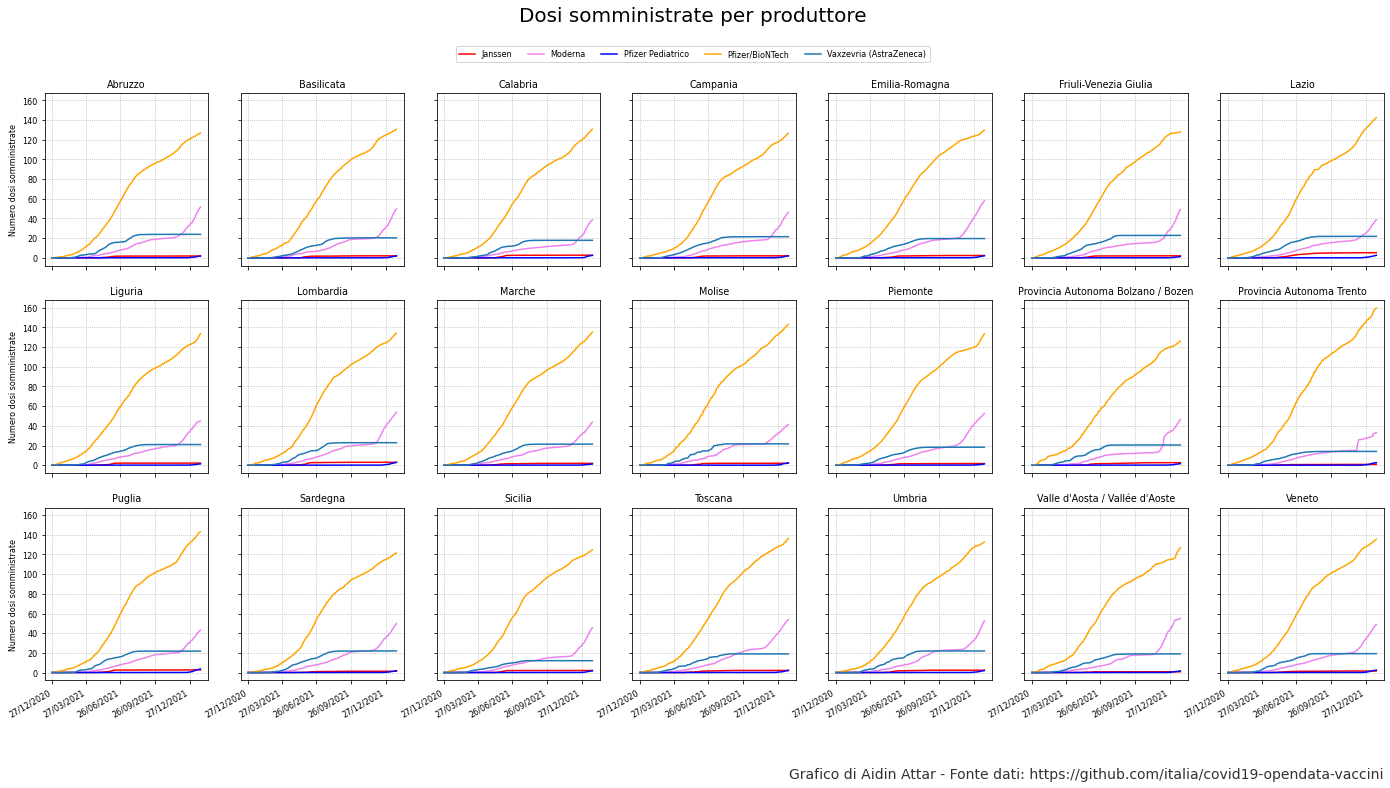

In [46]:
fig, ax = plt.subplots(nrows=3,ncols=7,figsize=(24,12), sharey=True, sharex=True)

colors=['red','violet','blue','orange','C0','violet','brown','black','plasma']
x=0
y=0
for key1 in somministrazioni_età.keys():
    i=0
    for key2 in sorted(somministrazioni_età[key1].keys()):
        ax[y,x].plot(somministrazioni_età[key1][key2].index,somministrazioni_età[key1][key2]['cumulativa_totale_per100'], color=colors[i])
        i+=1
    ax[y,x].set_title(str(key1))
    ax[y,x].grid(linestyle='dotted')
    x+=1
    if x==7:
        x=0
        y+=1
ax[0,0].xaxis.set_major_locator(mdates.MonthLocator(interval=3))

fig.suptitle("Dosi somministrate per produttore", fontsize=20)
plt.rcParams['font.size'] = '8'
ax[0,0].tick_params(axis='both', labelsize=8)
#ax.grid(alpha = 0.2,linestyle='dotted')
ax[0,0].set_ylabel('Numero dosi somministrate')
ax[1,0].set_ylabel('Numero dosi somministrate')
ax[2,0].set_ylabel('Numero dosi somministrate')
ax[0,0].set_xlabel("")
fig.autofmt_xdate()
labels = [key for key in sorted(somministrazioni_età['Emilia-Romagna'].keys())]
fig.legend(labels, loc='center',bbox_to_anchor=(.5,.925), ncol=len(labels), bbox_transform=fig.transFigure)

plt.text(0.9, 0.1, 'Grafico di Aidin Attar - Fonte dati: https://github.com/italia/covid19-opendata-vaccini',
         transform=plt.gcf().transFigure,
         fontsize=14, color='black', alpha=0.8,
         ha='right', va='top', rotation='0')

plt.show()

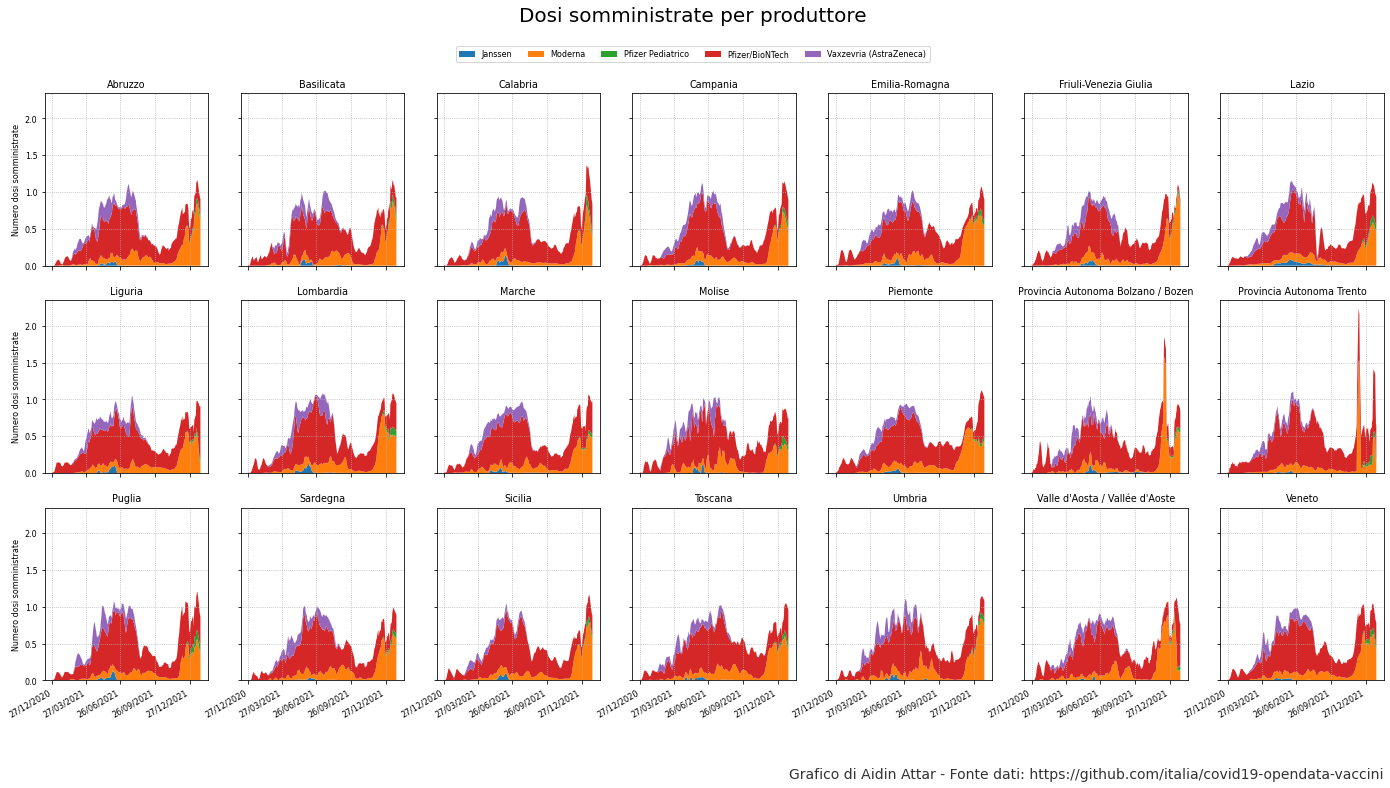

In [47]:
fig, ax = plt.subplots(nrows=3,ncols=7,figsize=(24,12), sharey=True, sharex=True)

colors=['red','violet','blue','orange','C0','violet','brown','black','plasma']
x=0
y=0
for key1 in somministrazioni_età.keys():
    ax[y,x].stackplot(somministrazioni_età[key1]['Pfizer/BioNTech'].index,[somministrazioni_età[key1][key]['media_totale_per100'] for key in sorted(somministrazioni_età[key1].keys())])
    ax[y,x].set_title(str(key1))
    ax[y,x].grid(linestyle='dotted')
    x+=1
    if x==7:
        x=0
        y+=1
ax[0,0].xaxis.set_major_locator(mdates.MonthLocator(interval=3))

fig.suptitle("Dosi somministrate per produttore", fontsize=20)
plt.rcParams['font.size'] = '8'
ax[0,0].tick_params(axis='both', labelsize=8)
#ax.grid(alpha = 0.2,linestyle='dotted')
ax[0,0].set_ylabel('Numero dosi somministrate')
ax[1,0].set_ylabel('Numero dosi somministrate')
ax[2,0].set_ylabel('Numero dosi somministrate')
ax[0,0].set_xlabel("")
labels = [key for key in sorted(somministrazioni_età['Emilia-Romagna'].keys())]
fig.legend(labels, loc='center',bbox_to_anchor=(.5,.925), ncol=len(labels), bbox_transform=fig.transFigure)

fig.autofmt_xdate()

plt.text(0.9, 0.1, 'Grafico di Aidin Attar - Fonte dati: https://github.com/italia/covid19-opendata-vaccini',
         transform=plt.gcf().transFigure,
         fontsize=14, color='black', alpha=0.8,
         ha='right', va='top', rotation='0')

plt.show()


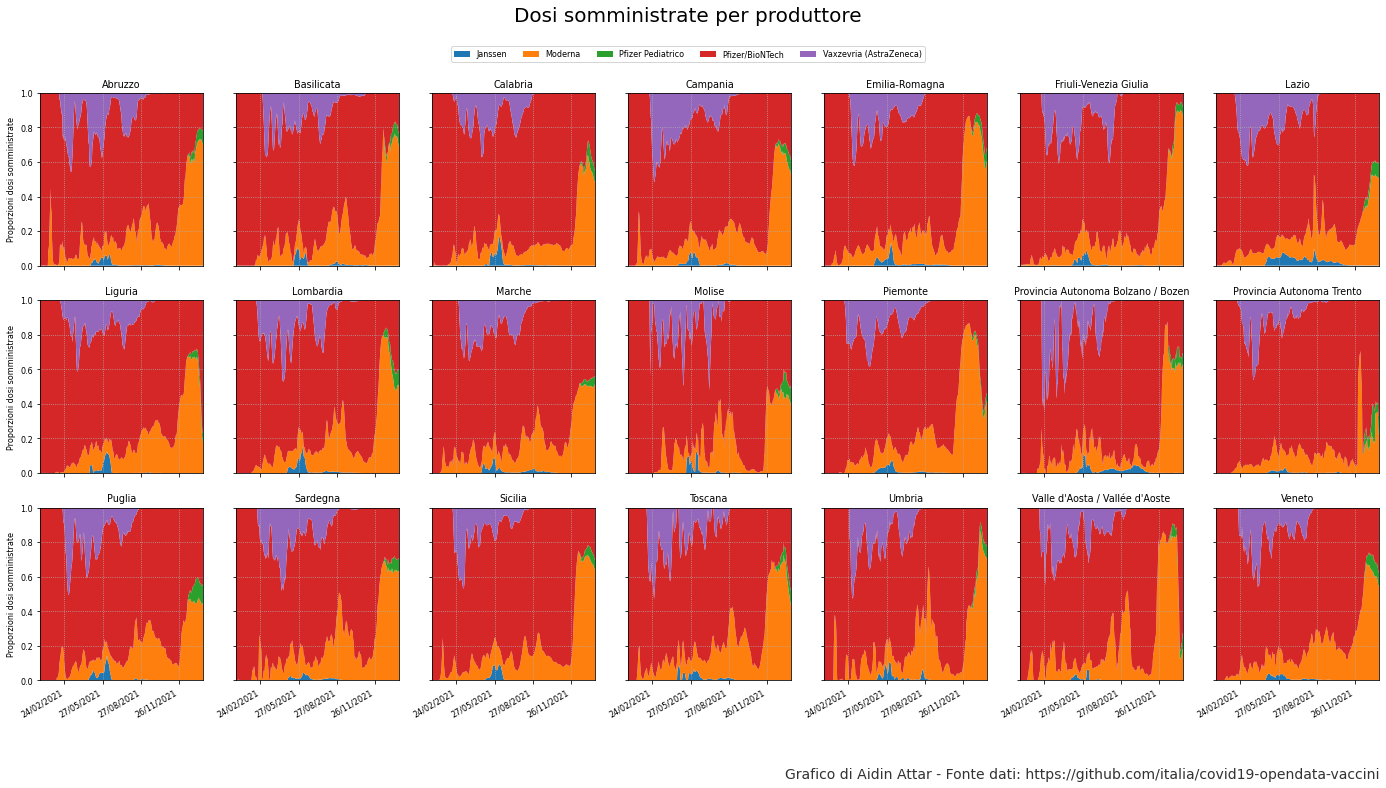

In [48]:
fig, ax = plt.subplots(nrows=3,ncols=7,figsize=(24,12), sharey=True, sharex=True)

colors=['red','violet','blue','orange','C0','violet','brown','black','plasma']
x=0
y=0
for key1 in somministrazioni_età.keys():
    ax[y,x].stackplot(somministrazioni_età[key1]['Pfizer/BioNTech'].index,[somministrazioni_età[key1][key]['media_totale_per100']/sum(somministrazioni_età[key1][key2]['media_totale_per100'] for key2 in somministrazioni_età[key1].keys()) for key in sorted(somministrazioni_età[key1].keys())])
    ax[y,x].set_title(str(key1))
    ax[y,x].grid(linestyle='dotted')
    x+=1
    if x==7:
        x=0
        y+=1
ax[0,0].xaxis.set_major_locator(mdates.MonthLocator(interval=3))

fig.suptitle("Dosi somministrate per produttore", fontsize=20)
plt.rcParams['font.size'] = '8'
ax[0,0].tick_params(axis='both', labelsize=8)
#ax.grid(alpha = 0.2,linestyle='dotted')
ax[0,0].set_ylabel('Proporzioni dosi somministrate')
ax[1,0].set_ylabel('Proporzioni dosi somministrate')
ax[2,0].set_ylabel('Proporzioni dosi somministrate')
ax[0,0].set_xlabel("")
ax[0,0].set_ylim(top=1)
ax[0,0].set_xlim([date(2020, 12, 27).strftime('%d/%m/%Y'), yesterday.strftime('%d/%m/%Y')])
labels = [key for key in sorted(somministrazioni_età['Emilia-Romagna'].keys())]
fig.legend(labels, loc='center',bbox_to_anchor=(.5,.925), ncol=len(labels), bbox_transform=fig.transFigure)

fig.autofmt_xdate()

plt.text(0.9, 0.1, 'Grafico di Aidin Attar - Fonte dati: https://github.com/italia/covid19-opendata-vaccini',
         transform=plt.gcf().transFigure,
         fontsize=14, color='black', alpha=0.8,
         ha='right', va='top', rotation='0')

plt.show()

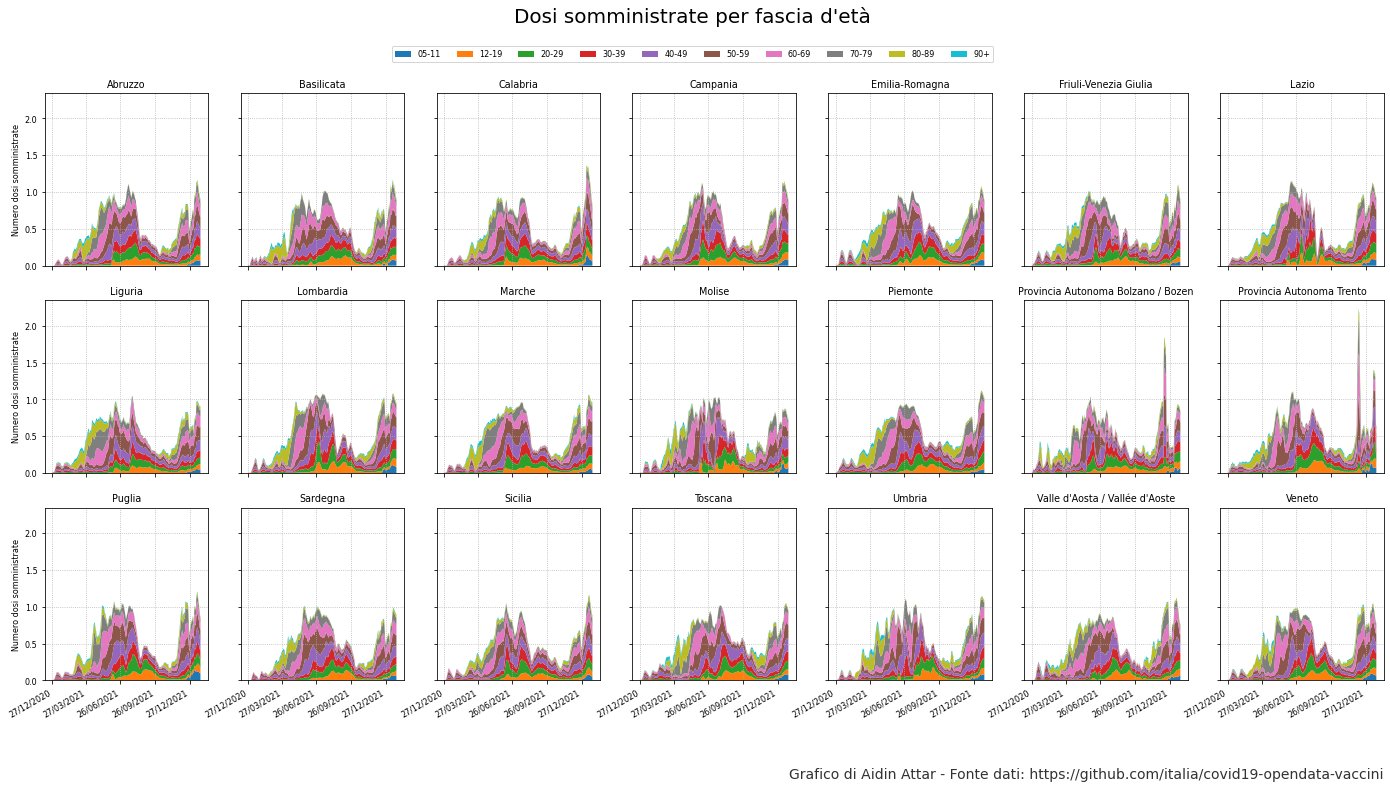

In [49]:
fig, ax = plt.subplots(nrows=3,ncols=7,figsize=(24,12), sharey=True, sharex=True)

colors=['red','violet','blue','orange','C0','violet','brown','black','plasma']
x=0
y=0
for key1 in somministrazioni_fornitori.keys():
    ax[y,x].stackplot(somministrazioni_fornitori[key1]['50-59'].index,[somministrazioni_fornitori[key1][key]['media_totale_per100'] for key in sorted(somministrazioni_fornitori[key1].keys())])
    ax[y,x].set_title(str(key1))
    ax[y,x].grid(linestyle='dotted')
    x+=1
    if x==7:
        x=0
        y+=1
ax[0,0].xaxis.set_major_locator(mdates.MonthLocator(interval=3))

fig.suptitle("Dosi somministrate per fascia d'età", fontsize=20)
plt.rcParams['font.size'] = '8'
ax[0,0].tick_params(axis='both', labelsize=8)
#ax.grid(alpha = 0.2,linestyle='dotted')
ax[0,0].set_ylabel('Numero dosi somministrate')
ax[1,0].set_ylabel('Numero dosi somministrate')
ax[2,0].set_ylabel('Numero dosi somministrate')
ax[0,0].set_xlabel("")

labels = [key for key in sorted(somministrazioni_fornitori['Emilia-Romagna'].keys())]
fig.legend(labels, loc='center',bbox_to_anchor=(.5,.925), ncol=len(labels), bbox_transform=fig.transFigure)

fig.autofmt_xdate()

plt.text(0.9, 0.1, 'Grafico di Aidin Attar - Fonte dati: https://github.com/italia/covid19-opendata-vaccini',
         transform=plt.gcf().transFigure,
         fontsize=14, color='black', alpha=0.8,
         ha='right', va='top', rotation='0')

plt.show()

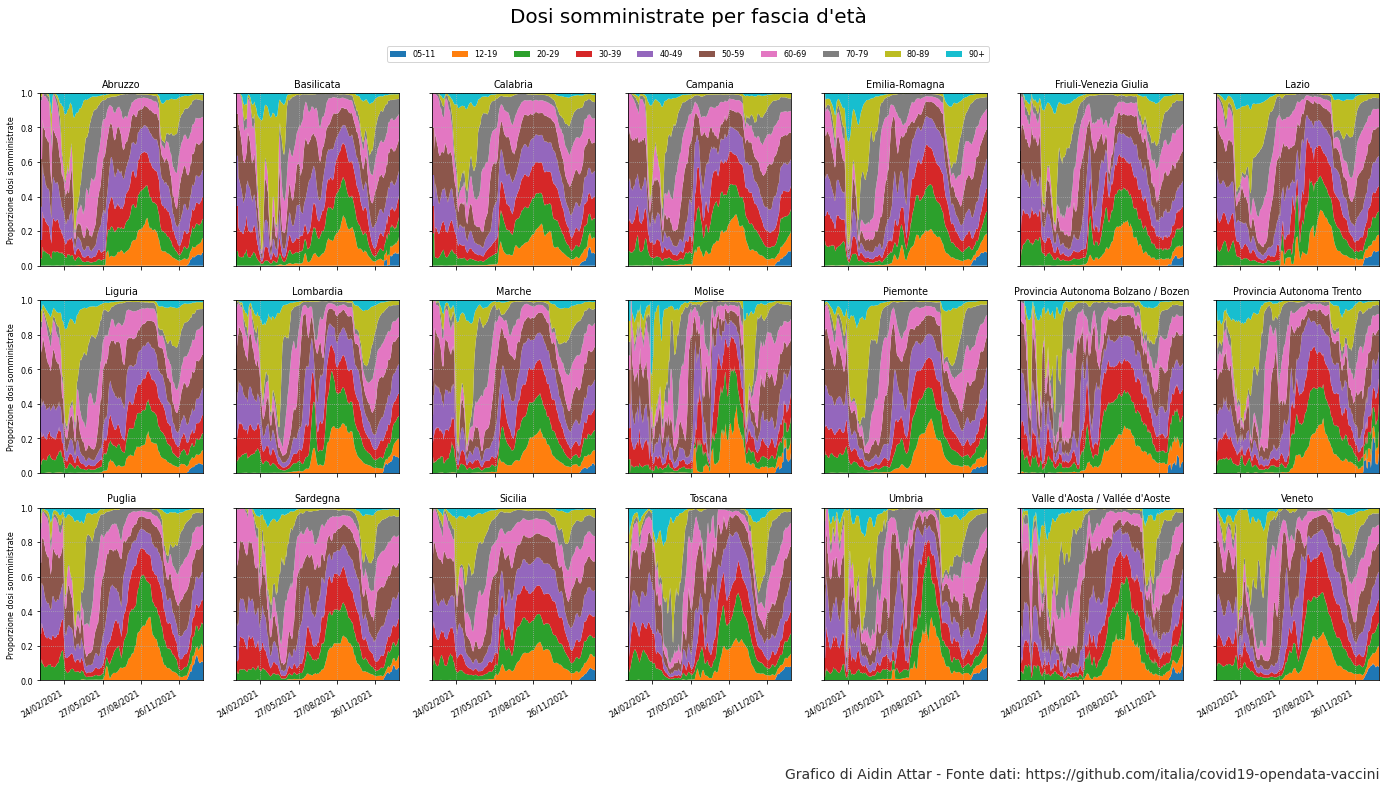

In [50]:
fig, ax = plt.subplots(nrows=3,ncols=7,figsize=(24,12), sharey=True, sharex=True)

colors=['red','violet','blue','orange','C0','violet','brown','black','plasma']
x=0
y=0
for key1 in somministrazioni_fornitori.keys():
    ax[y,x].stackplot(somministrazioni_fornitori[key1]['50-59'].index,[somministrazioni_fornitori[key1][key]['media_totale']/sum(somministrazioni_fornitori[key1][key2]['media_totale'] for key2 in somministrazioni_fornitori[key1].keys()) for key in sorted(somministrazioni_fornitori[key1].keys())])
    ax[y,x].set_title(str(key1))
    ax[y,x].grid(linestyle='dotted')
    x+=1
    if x==7:
        x=0
        y+=1
ax[0,0].xaxis.set_major_locator(mdates.MonthLocator(interval=3))

fig.suptitle("Dosi somministrate per fascia d'età", fontsize=20)
plt.rcParams['font.size'] = '8'
ax[0,0].tick_params(axis='both', labelsize=8)
#ax.grid(alpha = 0.2,linestyle='dotted')
ax[0,0].set_ylabel('Proporzione dosi somministrate')
ax[1,0].set_ylabel('Proporzione dosi somministrate')
ax[2,0].set_ylabel('Proporzione dosi somministrate')
ax[0,0].set_xlabel("")
ax[0,0].set_ylim(top=1)
ax[0,0].set_xlim([date(2020, 12, 27).strftime('%d/%m/%Y'), yesterday.strftime('%d/%m/%Y')])

labels = [key for key in sorted(somministrazioni_fornitori['Emilia-Romagna'].keys())]
fig.legend(labels, loc='center',bbox_to_anchor=(.5,.925), ncol=len(labels), bbox_transform=fig.transFigure)

fig.autofmt_xdate()

plt.text(0.9, 0.1, 'Grafico di Aidin Attar - Fonte dati: https://github.com/italia/covid19-opendata-vaccini',
         transform=plt.gcf().transFigure,
         fontsize=14, color='black', alpha=0.8,
         ha='right', va='top', rotation='0')

plt.show()

In [51]:
PlateaRegioni = sorted(platea.nome_area.unique())
PopolazioneRegioni={elem1:{elem2: int for elem2 in PlateaFasce} for elem1 in PlateaRegioni}
for key1 in PopolazioneRegioni.keys():
    for key2 in PopolazioneRegioni[key1].keys():
        PopolazioneRegioni[key1][key2]=platea.groupby('nome_area').get_group(key1).groupby('fascia_anagrafica').get_group(key2)['totale_popolazione'].values[0]

PopolazioneRegioni['Provincia Autonoma Bolzano / Bozen'] = PopolazioneRegioni[ 'P.A. Bolzano']
PopolazioneRegioni['Provincia Autonoma Trento'         ] = PopolazioneRegioni[ 'P.A. Trento' ]
PopolazioneRegioni["Valle d'Aosta / Vallée d'Aoste"    ] = PopolazioneRegioni["Valle d'Aosta"]
#for new_key, old_key in zip(NomiRegioni,PlateaRegioni):
#    PopolazioneRegioni[new_key] = PopolazioneRegioni.pop(old_key)

In [52]:
new_somministrazioni_fornitori = copy.deepcopy(somministrazioni_fornitori)

for key in somministrazioni_fornitori.keys():
    new_somministrazioni_fornitori[key]['80+'] = copy.deepcopy(somministrazioni_fornitori[key]['90+'])
    new_somministrazioni_fornitori[key]['80+'][                  'totale'] = somministrazioni_fornitori[key]['80-89'][                  'totale']+somministrazioni_fornitori[key]['90+'][                  'totale']
    new_somministrazioni_fornitori[key]['80+'][          'sesso_maschile'] = somministrazioni_fornitori[key]['80-89'][          'sesso_maschile']+somministrazioni_fornitori[key]['90+'][          'sesso_maschile']
    new_somministrazioni_fornitori[key]['80+'][         'sesso_femminile'] = somministrazioni_fornitori[key]['80-89'][         'sesso_femminile']+somministrazioni_fornitori[key]['90+'][         'sesso_femminile']
    new_somministrazioni_fornitori[key]['80+'][              'prima_dose'] = somministrazioni_fornitori[key]['80-89'][              'prima_dose']+somministrazioni_fornitori[key]['90+'][              'prima_dose']
    new_somministrazioni_fornitori[key]['80+'][            'seconda_dose'] = somministrazioni_fornitori[key]['80-89'][            'seconda_dose']+somministrazioni_fornitori[key]['90+'][            'seconda_dose']
    new_somministrazioni_fornitori[key]['80+'][     'pregressa_infezione'] = somministrazioni_fornitori[key]['80-89'][     'pregressa_infezione']+somministrazioni_fornitori[key]['90+'][     'pregressa_infezione']
    new_somministrazioni_fornitori[key]['80+']['dose_addizionale_booster'] = somministrazioni_fornitori[key]['80-89']['dose_addizionale_booster']+somministrazioni_fornitori[key]['90+']['dose_addizionale_booster']
    new_somministrazioni_fornitori[key]['80+']['fascia_anagrafica']='80+'
    new_somministrazioni_fornitori[key].pop('80-89')
    new_somministrazioni_fornitori[key].pop('90+')

for key in new_somministrazioni_fornitori.keys():
    for key1 in new_somministrazioni_fornitori[key].keys():
        new_somministrazioni_fornitori[key][key1][                               'media_totale'] = new_somministrazioni_fornitori[key][key1]['totale'].rolling(window=7, min_periods=1).mean()
        new_somministrazioni_fornitori[key][key1][                       'media_sesso_maschile'] = new_somministrazioni_fornitori[key][key1]['sesso_maschile'].rolling(window=7, min_periods=1).mean()
        new_somministrazioni_fornitori[key][key1][                      'media_sesso_femminile'] = new_somministrazioni_fornitori[key][key1]['sesso_femminile'].rolling(window=7, min_periods=1).mean()
        new_somministrazioni_fornitori[key][key1][                           'media_prima_dose'] = new_somministrazioni_fornitori[key][key1]['prima_dose'].rolling(window=7, min_periods=1).mean()
        new_somministrazioni_fornitori[key][key1][                         'media_seconda_dose'] = new_somministrazioni_fornitori[key][key1]['seconda_dose'].rolling(window=7, min_periods=1).mean()
        new_somministrazioni_fornitori[key][key1][                  'media_pregressa_infezione'] = new_somministrazioni_fornitori[key][key1]['pregressa_infezione'].rolling(window=7, min_periods=1).mean()
        new_somministrazioni_fornitori[key][key1][             'media_dose_addizionale_booster'] = new_somministrazioni_fornitori[key][key1]['dose_addizionale_booster'].rolling(window=7, min_periods=1).mean()
        new_somministrazioni_fornitori[key][key1][                          'cumulativa_totale'] = new_somministrazioni_fornitori[key][key1][                  'totale'].cumsum()
        new_somministrazioni_fornitori[key][key1][                  'cumulativa_sesso_maschile'] = new_somministrazioni_fornitori[key][key1][          'sesso_maschile'].cumsum()
        new_somministrazioni_fornitori[key][key1][                 'cumulativa_sesso_femminile'] = new_somministrazioni_fornitori[key][key1][         'sesso_femminile'].cumsum()
        new_somministrazioni_fornitori[key][key1][                      'cumulativa_prima_dose'] = new_somministrazioni_fornitori[key][key1][              'prima_dose'].cumsum()
        new_somministrazioni_fornitori[key][key1][                    'cumulativa_seconda_dose'] = new_somministrazioni_fornitori[key][key1][            'seconda_dose'].cumsum()
        new_somministrazioni_fornitori[key][key1][             'cumulativa_pregressa_infezione'] = new_somministrazioni_fornitori[key][key1][     'pregressa_infezione'].cumsum()
        new_somministrazioni_fornitori[key][key1][        'cumulativa_dose_addizionale_booster'] = new_somministrazioni_fornitori[key][key1]['dose_addizionale_booster'].cumsum()

        new_somministrazioni_fornitori[key][key1][                     'perc_cumulativa_totale'] = new_somministrazioni_fornitori[key][key1][                  'cumulativa_totale'] / PopolazioneRegioni[key][key1] * 100
        new_somministrazioni_fornitori[key][key1][             'perc_cumulativa_sesso_maschile'] = new_somministrazioni_fornitori[key][key1][          'cumulativa_sesso_maschile'] / PopolazioneRegioni[key][key1] * 100
        new_somministrazioni_fornitori[key][key1][            'perc_cumulativa_sesso_femminile'] = new_somministrazioni_fornitori[key][key1][         'cumulativa_sesso_femminile'] / PopolazioneRegioni[key][key1] * 100
        new_somministrazioni_fornitori[key][key1][                 'perc_cumulativa_prima_dose'] = new_somministrazioni_fornitori[key][key1][              'cumulativa_prima_dose'] / PopolazioneRegioni[key][key1] * 100
        new_somministrazioni_fornitori[key][key1][               'perc_cumulativa_seconda_dose'] = new_somministrazioni_fornitori[key][key1][            'cumulativa_seconda_dose'] / PopolazioneRegioni[key][key1] * 100
        new_somministrazioni_fornitori[key][key1][        'perc_cumulativa_pregressa_infezione'] = new_somministrazioni_fornitori[key][key1][     'cumulativa_pregressa_infezione'] / PopolazioneRegioni[key][key1] * 100
        new_somministrazioni_fornitori[key][key1][   'perc_cumulativa_dose_addizionale_booster'] = new_somministrazioni_fornitori[key][key1]['cumulativa_dose_addizionale_booster'] / PopolazioneRegioni[key][key1] * 100

        new_somministrazioni_fornitori[key][key1][                  'rimasti_cumulativa_totale'] = (PopolazioneRegioni[key][key1] - new_somministrazioni_fornitori[key][key1][                  'cumulativa_totale']) / DictRegioni[key] * 100
        new_somministrazioni_fornitori[key][key1][          'rimasti_cumulativa_sesso_maschile'] = (PopolazioneRegioni[key][key1] - new_somministrazioni_fornitori[key][key1][          'cumulativa_sesso_maschile']) / DictRegioni[key] * 100
        new_somministrazioni_fornitori[key][key1][         'rimasti_cumulativa_sesso_femminile'] = (PopolazioneRegioni[key][key1] - new_somministrazioni_fornitori[key][key1][         'cumulativa_sesso_femminile']) / DictRegioni[key] * 100
        new_somministrazioni_fornitori[key][key1][              'rimasti_cumulativa_prima_dose'] = (PopolazioneRegioni[key][key1] - new_somministrazioni_fornitori[key][key1][              'cumulativa_prima_dose']) / DictRegioni[key] * 100
        new_somministrazioni_fornitori[key][key1][            'rimasti_cumulativa_seconda_dose'] = (PopolazioneRegioni[key][key1] - new_somministrazioni_fornitori[key][key1][            'cumulativa_seconda_dose']) / DictRegioni[key] * 100
        new_somministrazioni_fornitori[key][key1][     'rimasti_cumulativa_pregressa_infezione'] = (PopolazioneRegioni[key][key1] - new_somministrazioni_fornitori[key][key1][     'cumulativa_pregressa_infezione']) / DictRegioni[key] * 100
        new_somministrazioni_fornitori[key][key1]['rimasti_cumulativa_dose_addizionale_booster'] = (PopolazioneRegioni[key][key1] - new_somministrazioni_fornitori[key][key1]['cumulativa_dose_addizionale_booster']) / DictRegioni[key] * 100

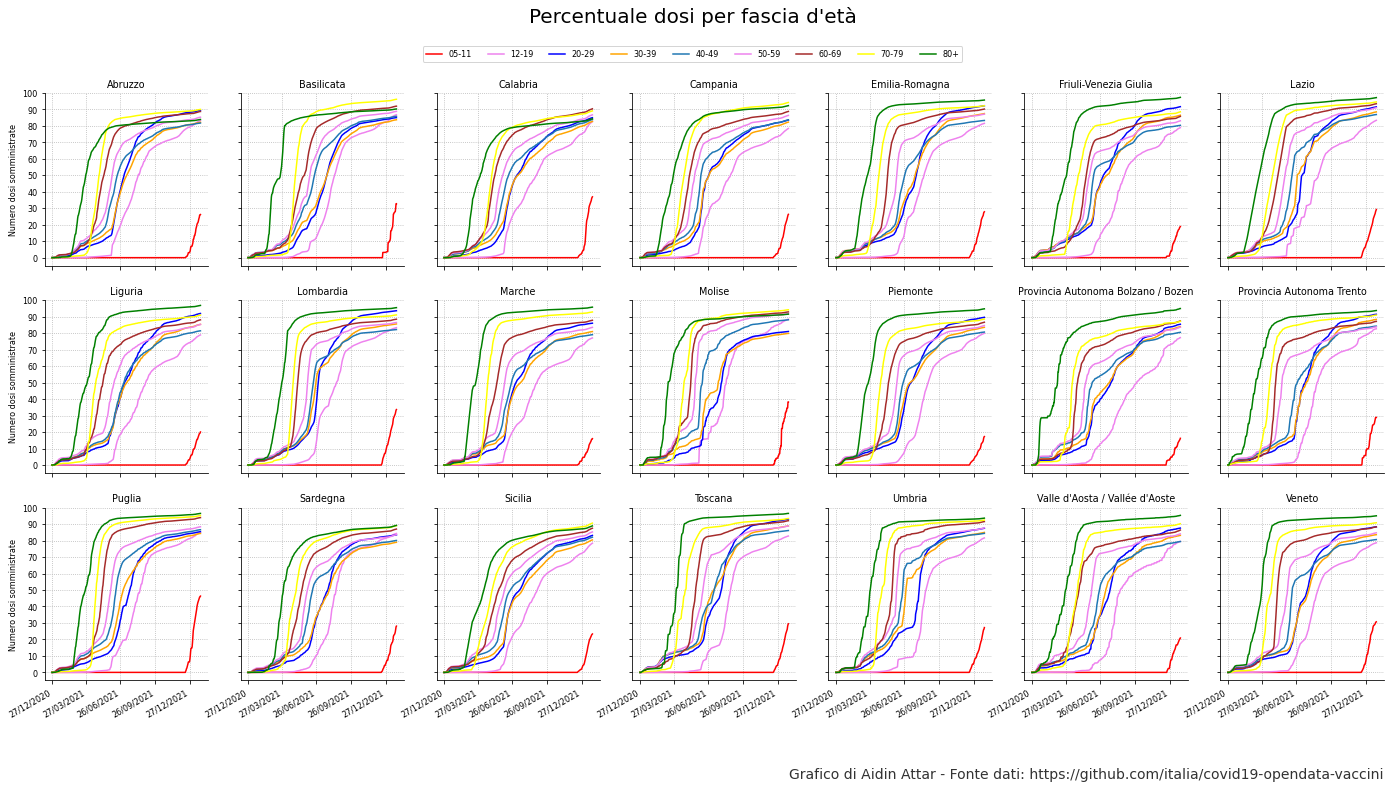

In [53]:
fig, ax = plt.subplots(nrows=3,ncols=7,figsize=(24,12), sharex=True, sharey=True)

colors=['red','violet','blue','orange','C0','violet','brown','yellow','green','black','purple']
x=0
y=0
for key1 in new_somministrazioni_fornitori.keys():
    i=0
    for key2 in sorted(new_somministrazioni_fornitori[key1].keys()):
        ax[y,x].plot(new_somministrazioni_fornitori[key1][key2].index,new_somministrazioni_fornitori[key1][key2]['perc_cumulativa_prima_dose'], color=colors[i])
        i+=1
    ax[y,x].set_title(str(key1))
    ax[y,x].grid(linestyle='dotted')
    ax[y,x].spines['right'].set_visible(False)
    ax[y,x].spines['top'].set_visible(False)
    x+=1
    if x==7:
        x=0
        y+=1
ax[0,0].xaxis.set_major_locator(mdates.MonthLocator(interval=3))
ax[0,0].yaxis.set_major_locator(MultipleLocator(10))
ax[0,0].set_ylim(top=100)
fig.suptitle("Percentuale dosi per fascia d'età", fontsize=20)
plt.rcParams['font.size'] = '8'
ax[0,0].tick_params(axis='both', labelsize=8)
#ax.grid(alpha = 0.2,linestyle='dotted')
ax[0,0].set_ylabel('Numero dosi somministrate')
ax[1,0].set_ylabel('Numero dosi somministrate')
ax[2,0].set_ylabel('Numero dosi somministrate')
ax[0,0].set_xlabel("")
fig.autofmt_xdate()

labels = [key for key in sorted(new_somministrazioni_fornitori['Emilia-Romagna'].keys())]
fig.legend(labels, loc='center',bbox_to_anchor=(.5,.925), ncol=len(labels), bbox_transform=fig.transFigure)

plt.text(0.9, 0.1, 'Grafico di Aidin Attar - Fonte dati: https://github.com/italia/covid19-opendata-vaccini',
         transform=plt.gcf().transFigure,
         fontsize=14, color='black', alpha=0.8,
         ha='right', va='top', rotation='0')

plt.show()

In [54]:
PercetualiPrimaDose          = [new_italia_fornitori[key][              'perc_cumulativa_prima_dose'].iloc[-1] for key in sorted(new_italia_fornitori.keys())]
PercetualiSecondaDose        = [new_italia_fornitori[key][            'perc_cumulativa_seconda_dose'].iloc[-1] for key in sorted(new_italia_fornitori.keys())]
PercetualiTerzaDose          = [new_italia_fornitori[key]['perc_cumulativa_dose_addizionale_booster'].iloc[-1] for key in sorted(new_italia_fornitori.keys())]
PercetualiPregressaInfezione = [new_italia_fornitori[key][     'perc_cumulativa_pregressa_infezione'].iloc[-1] for key in sorted(new_italia_fornitori.keys())]

PercentualiOggi = pd.DataFrame({'prima_dose': PercetualiPrimaDose,
                                'seconda_dose': PercetualiSecondaDose,
                                'dose_addizionale_booster': PercetualiTerzaDose,
                                'pregressa_infezione': PercetualiPregressaInfezione},
                               index=sorted(new_italia_fornitori.keys()))
PercentualiOggi

prima_dose  seconda_dose  dose_addizionale_booster  pregressa_infezione
05-11   28.853093      8.110925                  0.000000             0.177732
12-19   81.311144     73.698110                 19.409295             2.932725
20-29   88.712737     82.894962                 41.038209             3.731825
30-39   84.523472     78.789519                 41.804266             3.272218
40-49   83.087996     77.943682                 50.313988             3.386557
50-59   86.569231     79.810459                 63.266544             3.607142
60-69   89.445641     81.236516                 72.748274             3.113541
70-79   91.771193     87.272325                 79.008149             2.654916
80+     94.163933     91.616897                 80.954356             2.114969

In [55]:
PercentualiRegioni = {}
for key in NomiRegioni:
    PercetualiPrimaDose          = [new_somministrazioni_fornitori[key][key1][              'perc_cumulativa_prima_dose'].iloc[-1] for key1 in sorted(new_somministrazioni_fornitori[key].keys())]
    PercetualiSecondaDose        = [new_somministrazioni_fornitori[key][key1][            'perc_cumulativa_seconda_dose'].iloc[-1] for key1 in sorted(new_somministrazioni_fornitori[key].keys())]
    PercetualiTerzaDose          = [new_somministrazioni_fornitori[key][key1]['perc_cumulativa_dose_addizionale_booster'].iloc[-1] for key1 in sorted(new_somministrazioni_fornitori[key].keys())]
    PercetualiPregressaInfezione = [new_somministrazioni_fornitori[key][key1][     'perc_cumulativa_pregressa_infezione'].iloc[-1] for key1 in sorted(new_somministrazioni_fornitori[key].keys())]

    PercentualiRegioni[key] = pd.DataFrame({'prima_dose'              :          PercetualiPrimaDose,
                                            'seconda_dose'            :        PercetualiSecondaDose,
                                            'dose_addizionale_booster':          PercetualiTerzaDose,
                                            'pregressa_infezione'     : PercetualiPregressaInfezione},
                                           index=sorted(new_somministrazioni_fornitori[key].keys()))

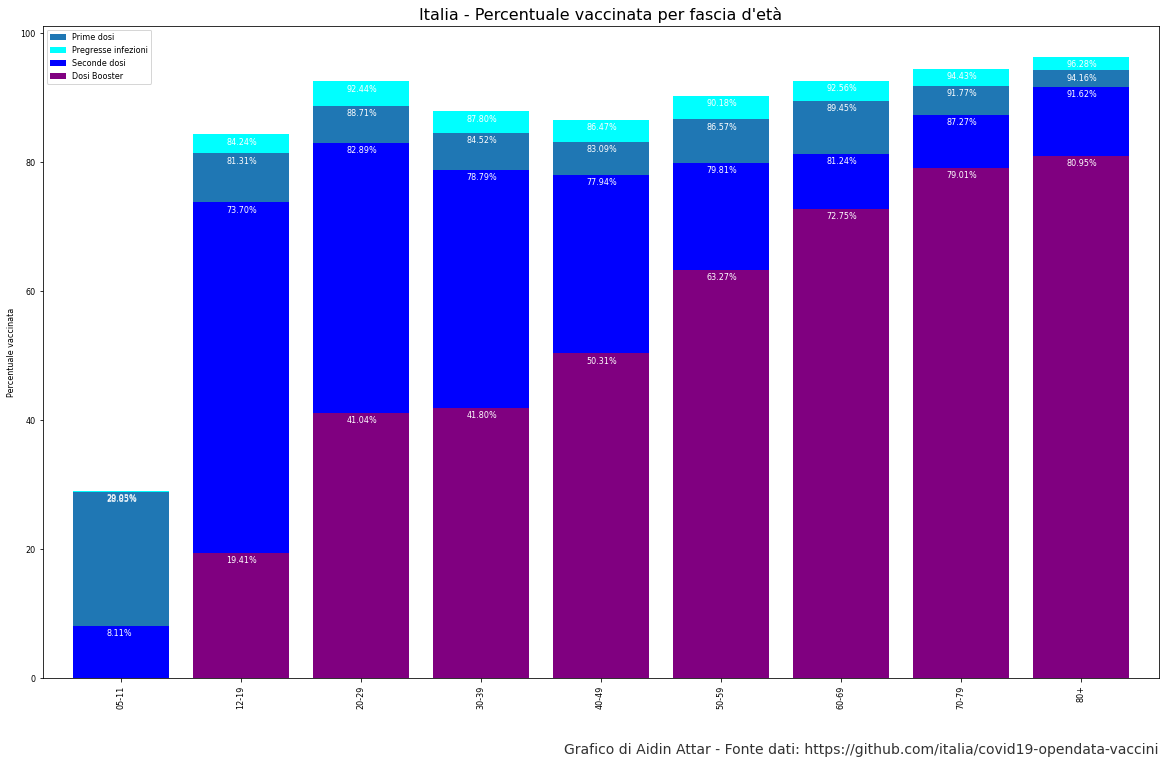

In [56]:
fig, ax = plt.subplots(figsize=(20,12))

labels=['Prime dosi', 'Pregresse infezioni', 'Seconde dosi', 'Dosi Booster']
PercentualiOggi[['prima_dose','pregressa_infezione']].plot.bar(ax=ax, stacked=True, color = ['C0', 'cyan'],width=.8)
PercentualiOggi['seconda_dose'].plot.bar(ax=ax, stacked=True, color='blue',width=0.8)
PercentualiOggi['dose_addizionale_booster'].plot.bar(ax=ax, stacked=True, color='purple',width=.8)
ax.legend(labels, loc='best')
ax.set_ylabel('Percentuale vaccinata')
ax.set_title("Italia - Percentuale vaccinata per fascia d'età", fontsize=16)
#ax.grid(linestyle='dotted')

for index,data in enumerate(PercentualiOggi['seconda_dose']):
    if data != 0:
        plt.text(x=index-0.12 , y =data-1.5 , s=str("{:.2%}".format(data/100)), color = 'w',fontdict=dict(fontsize=8))

for index,data in enumerate(PercentualiOggi['prima_dose']):
    if data != 0:
        plt.text(x=index-0.12 , y =data-1.5 , s=str("{:.2%}".format(data/100)), color = 'w',fontdict=dict(fontsize=8))

for index,data in enumerate(PercentualiOggi['dose_addizionale_booster']):
    if data != 0:
        plt.text(x=index-0.12 , y =data-1.5 , s=str("{:.2%}".format(data/100)), color = 'w',fontdict=dict(fontsize=8))

for index,data in enumerate(PercentualiOggi['prima_dose']+PercentualiOggi['pregressa_infezione']):
    if data != 0:
        plt.text(x=index-0.12 , y =data-1.5 , s=str("{:.2%}".format(data/100)), color = 'w',fontdict=dict(fontsize=8))

plt.text(0.9, 0.05, 'Grafico di Aidin Attar - Fonte dati: https://github.com/italia/covid19-opendata-vaccini',
         transform=plt.gcf().transFigure,
         fontsize=14, color='black', alpha=0.8,
         ha='right', va='top', rotation='0')

plt.show()

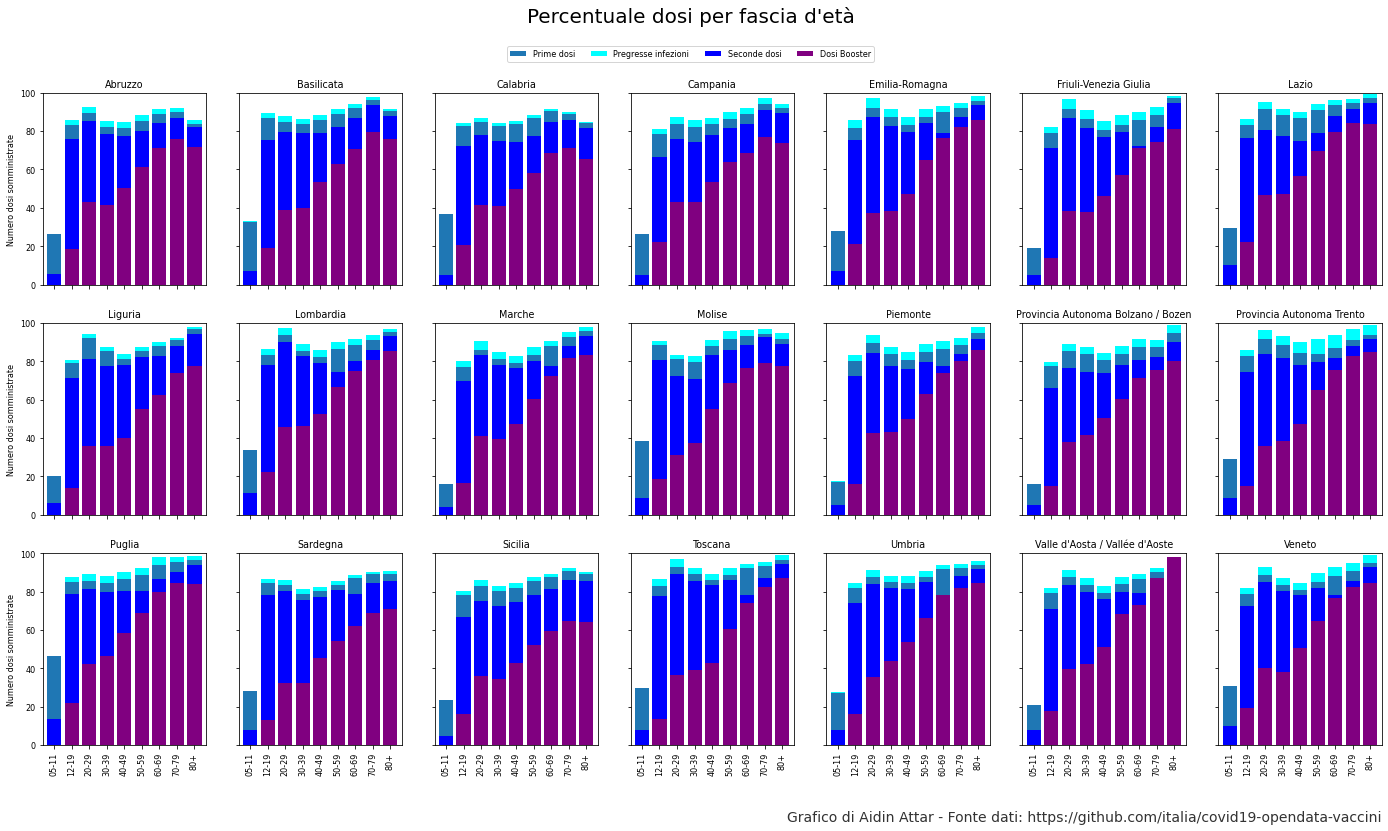

In [57]:
fig, ax = plt.subplots(nrows=3,ncols=7,figsize=(24,12), sharex=True,sharey=True)

colors=['red','violet','blue','orange','C0','violet','brown','yellow','green','black','purple']
x=0
y=0
for key1 in new_somministrazioni_fornitori.keys():
    PercentualiRegioni[key1][['prima_dose','pregressa_infezione']].plot.bar(ax=ax[y,x], stacked=True, color = ['C0', 'cyan'],width=.8, legend=False)
    PercentualiRegioni[key1]['seconda_dose'].plot.bar(ax=ax[y,x], stacked=True, color='blue',width=0.8)
    PercentualiRegioni[key1]['dose_addizionale_booster'].plot.bar(ax=ax[y,x], stacked=True, color='purple',width=.8)
    ax[y,x].set_title(str(key1))
    x+=1
    if x==7:
        x=0
        y+=1
ax[0,0].set_ylim(top=100)
fig.suptitle("Percentuale dosi per fascia d'età", fontsize=20)
plt.rcParams['font.size'] = '8'
ax[0,0].tick_params(axis='both', labelsize=8)
#ax.grid(alpha = 0.2,linestyle='dotted')
ax[0,0].set_ylabel('Numero dosi somministrate')
ax[1,0].set_ylabel('Numero dosi somministrate')
ax[2,0].set_ylabel('Numero dosi somministrate')

labels=['Prime dosi', 'Pregresse infezioni', 'Seconde dosi', 'Dosi Booster']
fig.legend(labels, loc='center',bbox_to_anchor=(.5,.925), ncol=len(labels), bbox_transform=fig.transFigure)

plt.text(0.9, 0.05, 'Grafico di Aidin Attar - Fonte dati: https://github.com/italia/covid19-opendata-vaccini',
         transform=plt.gcf().transFigure,
         fontsize=14, color='black', alpha=0.8,
         ha='right', va='top', rotation='0')

plt.show()

In [58]:
idx = pd.date_range('27/12/2020', yesterday)
NomiFornitori=cons.fornitore.unique()
consegne_fornitori={elem1:{elem2:pd.DataFrame for elem2 in NomiFornitori} for elem1 in NomiRegioni}

for key1 in consegne_fornitori.keys():
    for key2 in consegne_fornitori[key1].keys():
        consegne_fornitori[key1][key2]                          = cons[:][cons.nome_area==key1][cons.fornitore==key2]
        consegne_fornitori[key1][key2]['data_consegna']         = pd.to_datetime(consegne_fornitori[key1][key2]['data_consegna'], format='%Y-%m-%d', yearfirst=True)
        consegne_fornitori[key1][key2]                          = consegne_fornitori[key1][key2].set_index('data_consegna')
        consegne_fornitori[key1][key2].index                    = pd.DatetimeIndex(consegne_fornitori[key1][key2].index)
        consegne_fornitori[key1][key2].sort_index(inplace=True)
        consegne_fornitori[key1][key2]                          = consegne_fornitori[key1][key2].reindex(idx)
        consegne_fornitori[key1][key2].index                    = consegne_fornitori[key1][key2].index.strftime('%d/%m/%Y')
        consegne_fornitori[key1][key2].area.fillna(method='bfill',inplace=True)
        consegne_fornitori[key1][key2].codice_NUTS1.fillna(method='bfill',inplace=True)
        consegne_fornitori[key1][key2].codice_NUTS2.fillna(method='bfill',inplace=True)
        consegne_fornitori[key1][key2].codice_regione_ISTAT.fillna(method='bfill',inplace=True)
        consegne_fornitori[key1][key2].nome_area.fillna(key1,inplace=True)
        consegne_fornitori[key1][key2].fornitore.fillna(key2,inplace=True)
        consegne_fornitori[key1][key2].fillna(0,inplace=True)
        consegne_fornitori[key1][key2]['numero_dosi_per100']     = consegne_fornitori[key1][key2]['numero_dosi'] / DictRegioni[key1] * 100
        consegne_fornitori[key1][key2]['cumulativa_numero_dosi'] = consegne_fornitori[key1][key2]['numero_dosi'].cumsum()
        consegne_fornitori[key1][key2]['cumulativa_numero_dosi_per100']     = consegne_fornitori[key1][key2]['cumulativa_numero_dosi'] / DictRegioni[key1] * 100

consegne_italia_fornitori = copy.deepcopy(consegne_fornitori['Emilia-Romagna'])

for key1 in consegne_italia_fornitori.keys():
    consegne_italia_fornitori[key1][           'numero_dosi'] = sum(consegne_fornitori[key][key1]['numero_dosi'].fillna(0) for key in consegne_fornitori.keys())
    consegne_italia_fornitori[key1][     'media_numero_dosi'] = consegne_italia_fornitori[key1]['numero_dosi'].rolling(window=7, min_periods=1).mean()
    consegne_italia_fornitori[key1]['cumulativa_numero_dosi'] = consegne_italia_fornitori[key1]['numero_dosi'].cumsum()

for key1 in consegne_italia_fornitori.keys():
    consegne_italia_fornitori[key1].drop(columns=['codice_NUTS1','codice_NUTS2','codice_regione_ISTAT'], axis=1, inplace = True)
    consegne_italia_fornitori[key1][     'area'] =    'ITA'
    consegne_italia_fornitori[key1]['nome_area'] = 'italia'

/tmp/ipykernel_48802/1137327286.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  consegne_fornitori[key1][key2]                          = cons[:][cons.nome_area==key1][cons.fornitore==key2]


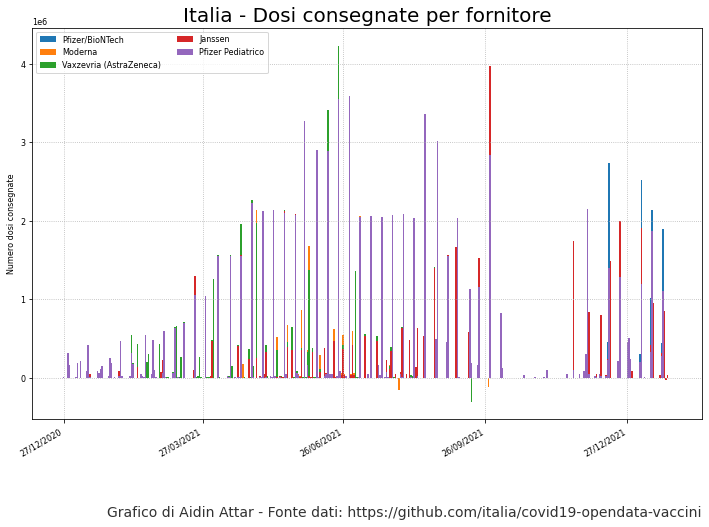

In [59]:
fig, ax = plt.subplots(figsize=(12,8))
colors=['red','violet','blue','orange','C0','violet','brown','yellow','green','black','purple']
i = len(consegne_italia_fornitori.keys())
for key in consegne_italia_fornitori.keys():
    ax.bar(consegne_italia_fornitori[key].index,sum(consegne_italia_fornitori[key1]['numero_dosi'] for key1 in list(consegne_italia_fornitori.keys())[:i]), width=1)
    i-=1

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
labels = [key for key in consegne_italia_fornitori.keys()]
ax.legend(labels, loc='upper left', ncol=2)
ax.set_title("Italia - Dosi consegnate per fornitore", fontsize=20)
plt.rcParams['font.size'] = '8'
ax.tick_params(axis='both', labelsize=8)
ax.grid(alpha = 1,linestyle='dotted')
ax.set_ylabel('Numero dosi consegnate')
ax.set_xlabel("")
fig.autofmt_xdate()

plt.text(0.9, 0.05, 'Grafico di Aidin Attar - Fonte dati: https://github.com/italia/covid19-opendata-vaccini',
         transform=plt.gcf().transFigure,
         fontsize=14, color='black', alpha=0.8,
         ha='right', va='top', rotation='0')

plt.show()

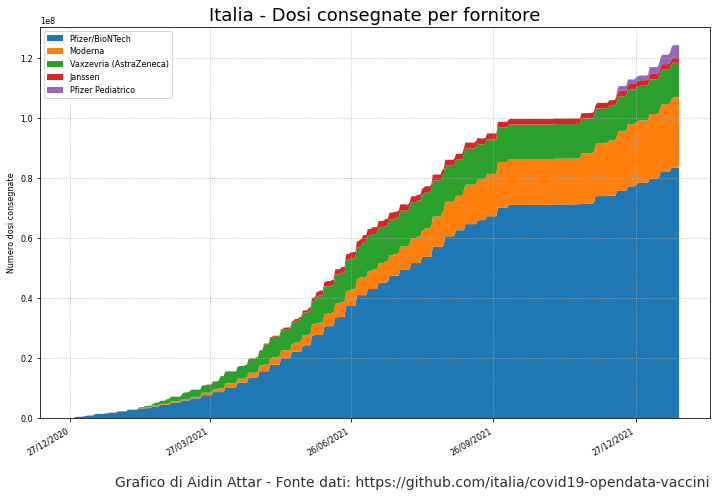

In [60]:
fig, ax = plt.subplots(figsize=(12,8))

colors=['red','violet','blue','orange','C0','violet','brown','yellow','green','black','purple']
ax.stackplot(consegne_italia_fornitori['Pfizer/BioNTech'].index,[consegne_italia_fornitori[key]['cumulativa_numero_dosi'] for key in consegne_italia_fornitori.keys()])

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
labels = [key for key in consegne_italia_fornitori.keys()]
ax.legend(labels, loc='upper left', ncol=1)
ax.set_title("Italia - Dosi consegnate per fornitore", fontsize=18)
plt.rcParams['font.size'] = '8'
ax.tick_params(axis='both', labelsize=8)
ax.grid(alpha = 1,linestyle='dotted')
ax.set_ylabel('Numero dosi consegnate')
ax.set_xlabel("")
fig.autofmt_xdate()

plt.text(0.9, 0.1, 'Grafico di Aidin Attar - Fonte dati: https://github.com/italia/covid19-opendata-vaccini',
         transform=plt.gcf().transFigure,
         fontsize=14, color='black', alpha=0.8,
         ha='right', va='top', rotation='0')

plt.show()

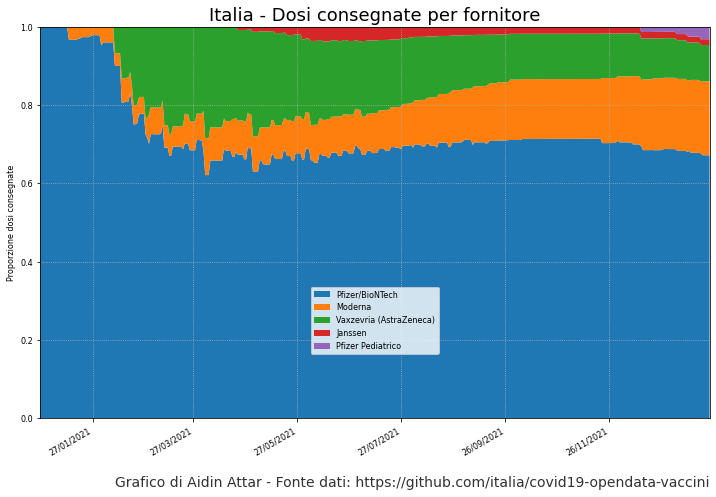

In [61]:
fig, ax = plt.subplots(figsize=(12,8))

colors=['red','violet','blue','orange','C0','violet','brown','yellow','green','black','purple']
ax.stackplot(consegne_italia_fornitori['Pfizer/BioNTech'].index,[consegne_italia_fornitori[key]['cumulativa_numero_dosi']/sum(consegne_italia_fornitori[key1]['cumulativa_numero_dosi'] for key1 in consegne_italia_fornitori.keys()) for key in consegne_italia_fornitori.keys()])

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax.set_title("Italia - Dosi consegnate per fornitore", fontsize=18)
plt.rcParams['font.size'] = '8'
ax.tick_params(axis='both', labelsize=8)
ax.grid(alpha = 1,linestyle='dotted')
ax.set_ylabel('Proporzione dosi consegnate')
ax.set_xlabel("")
fig.autofmt_xdate()
ax.set_ylim(top=1)
ax.set_xlim([date(2020, 12, 27).strftime('%d/%m/%Y'), yesterday.strftime('%d/%m/%Y')])
label = [key for key in consegne_italia_fornitori.keys()]
ax.legend(label, loc = 'center', bbox_to_anchor=(.5, .25))

plt.text(0.9, 0.1, 'Grafico di Aidin Attar - Fonte dati: https://github.com/italia/covid19-opendata-vaccini',
         transform=plt.gcf().transFigure,
         fontsize=14, color='black', alpha=0.8,
         ha='right', va='top', rotation='0')

plt.show()

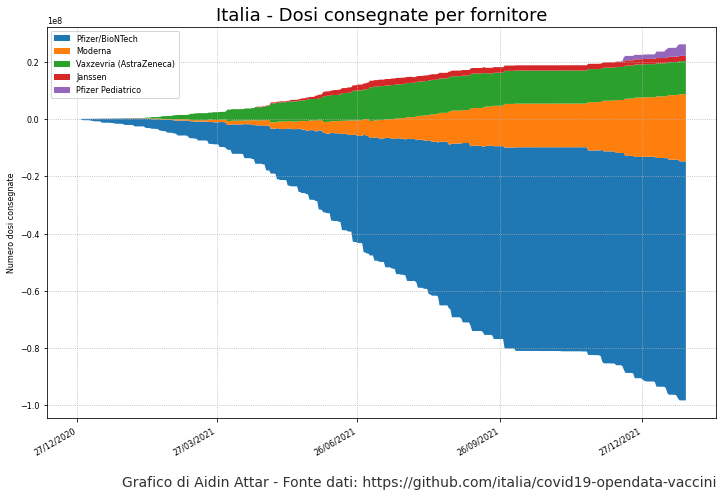

In [62]:
fig, ax = plt.subplots(figsize=(12,8))

colors=['red','violet','blue','orange','C0','violet','brown','yellow','green','black','purple']
ax.stackplot(consegne_italia_fornitori['Pfizer/BioNTech'].index,[consegne_italia_fornitori[key]['cumulativa_numero_dosi'] for key in consegne_italia_fornitori.keys()],
             baseline ='wiggle')

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
labels = [key for key in consegne_italia_fornitori.keys()]
ax.legend(labels, loc='upper left', ncol=1)
ax.set_title("Italia - Dosi consegnate per fornitore", fontsize=18)
plt.rcParams['font.size'] = '8'
ax.tick_params(axis='both', labelsize=8)
ax.grid(alpha = 1,linestyle='dotted')
ax.set_ylabel('Numero dosi consegnate')
ax.set_xlabel("")
fig.autofmt_xdate()

plt.text(0.9, 0.1, 'Grafico di Aidin Attar - Fonte dati: https://github.com/italia/covid19-opendata-vaccini',
         transform=plt.gcf().transFigure,
         fontsize=14, color='black', alpha=0.8,
         ha='right', va='top', rotation='0')

plt.show()

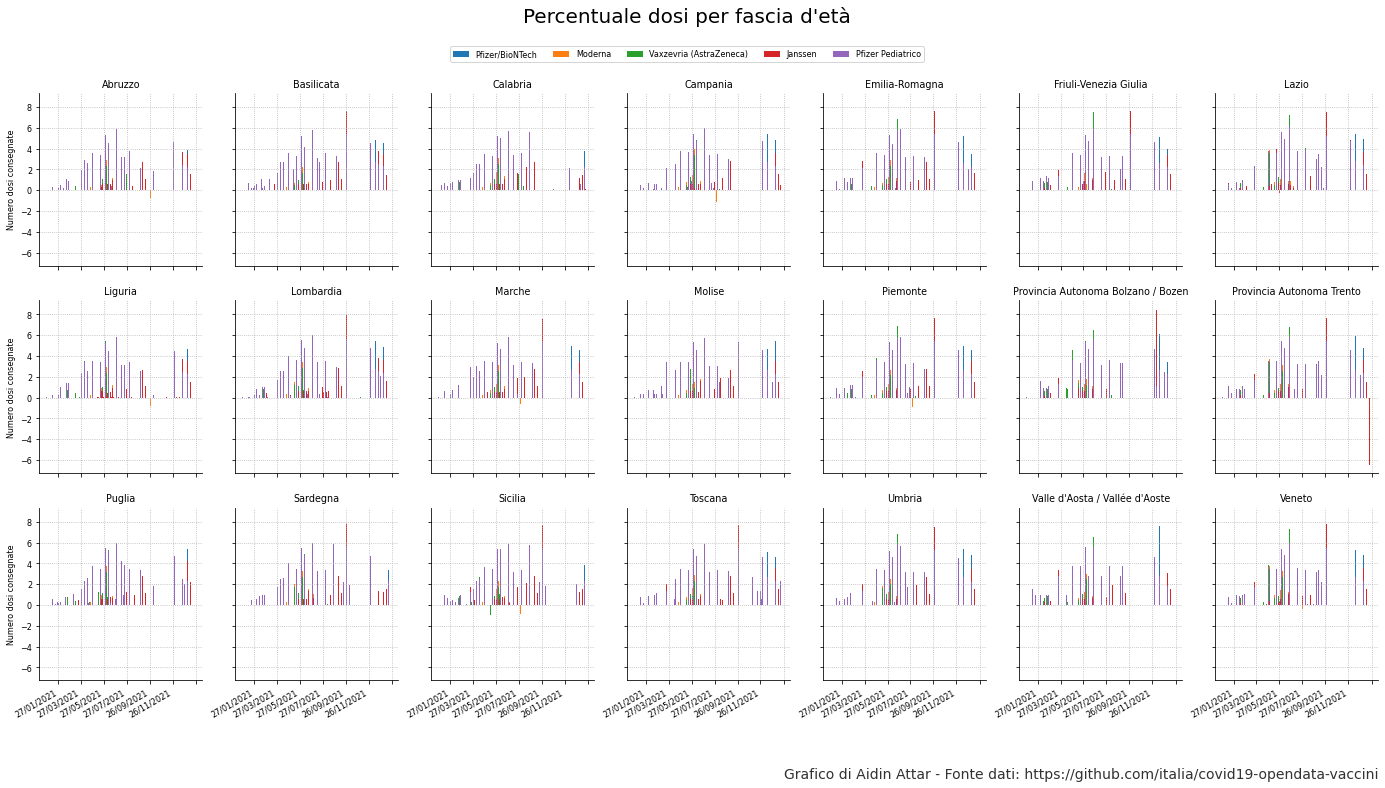

In [63]:
fig, ax = plt.subplots(nrows=3,ncols=7,figsize=(24,12), sharex=True, sharey=True)

colors=['red','violet','blue','orange','C0','violet','brown','yellow','green','black','purple']
x=0
y=0
for key1 in consegne_fornitori.keys():
    i = len(consegne_fornitori[key1].keys())
    for key2 in consegne_fornitori[key1].keys():
        ax[y,x].bar(consegne_fornitori[key1][key2].index,sum(consegne_fornitori[key1][key3]['numero_dosi_per100'] for key3 in list(consegne_fornitori[key1].keys())[:i]), width=1)
        i-=1
    ax[y,x].set_title(str(key1))
    ax[y,x].grid(linestyle='dotted')
    ax[y,x].spines['right'].set_visible(False)
    ax[y,x].spines['top'].set_visible(False)
    x+=1
    if x==7:
        x=0
        y+=1
ax[0,0].xaxis.set_major_locator(mdates.MonthLocator(interval=2))
#ax[0,0].yaxis.set_major_locator(MultipleLocator(10))
#ax[0,0].set_ylim(top=100)
fig.suptitle("Percentuale dosi per fascia d'età", fontsize=20)
plt.rcParams['font.size'] = '8'
ax[0,0].tick_params(axis='both', labelsize=8)
#ax.grid(alpha = 0.2,linestyle='dotted')
ax[0,0].set_ylabel('Numero dosi consegnate')
ax[1,0].set_ylabel('Numero dosi consegnate')
ax[2,0].set_ylabel('Numero dosi consegnate')
ax[0,0].set_xlabel("")
fig.autofmt_xdate()

labels = [key for key in consegne_fornitori['Emilia-Romagna'].keys()]
fig.legend(labels, loc='center',bbox_to_anchor=(.5,.925), ncol=len(labels), bbox_transform=fig.transFigure)

plt.text(0.9, 0.1, 'Grafico di Aidin Attar - Fonte dati: https://github.com/italia/covid19-opendata-vaccini',
         transform=plt.gcf().transFigure,
         fontsize=14, color='black', alpha=0.8,
         ha='right', va='top', rotation='0')

plt.show()

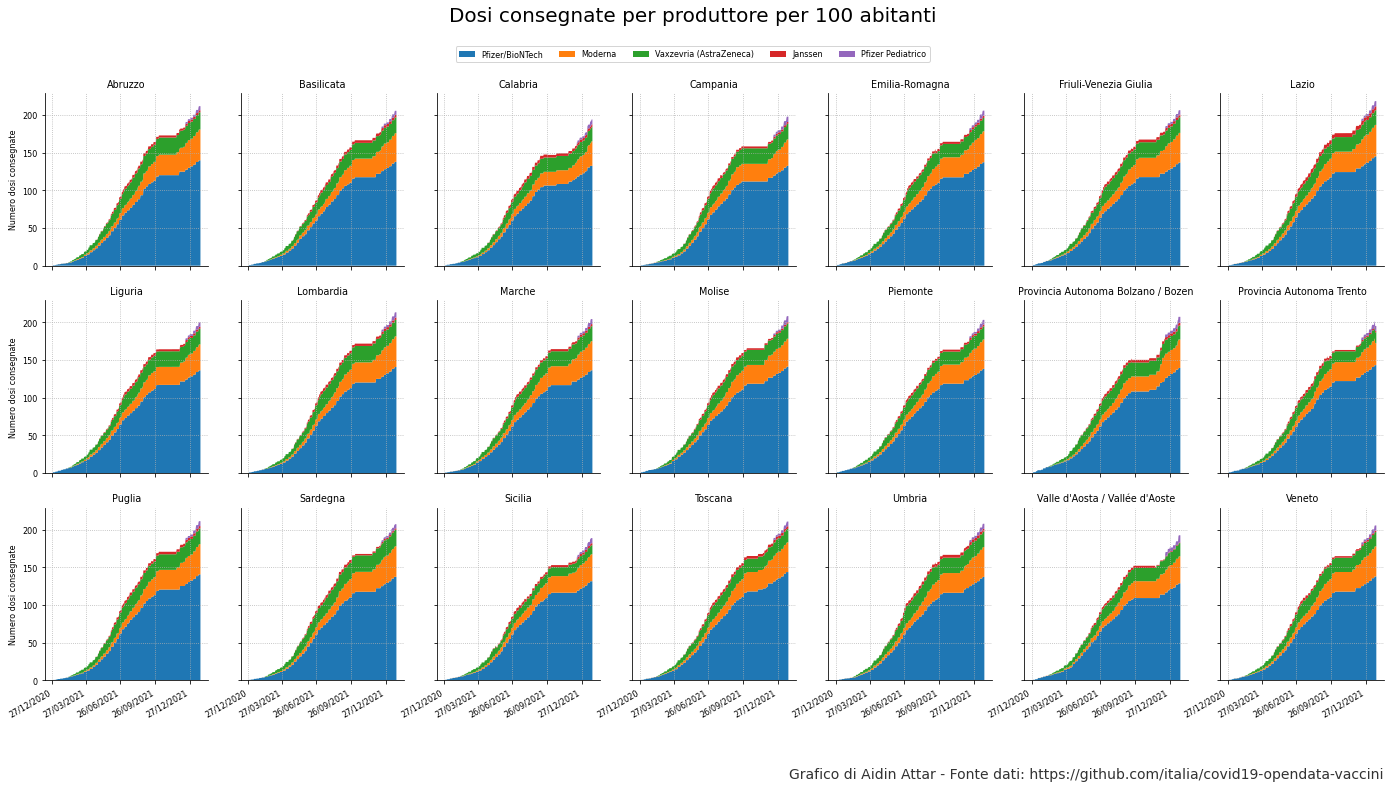

In [64]:
fig, ax = plt.subplots(nrows=3,ncols=7,figsize=(24,12), sharey=True, sharex=True)

colors=['red','violet','blue','orange','C0','violet','brown','black','plasma']
x=0
y=0
for key1 in consegne_fornitori.keys():
    ax[y,x].stackplot(consegne_fornitori[key1]['Pfizer/BioNTech'].index,[consegne_fornitori[key1][key]['cumulativa_numero_dosi_per100'] for key in consegne_fornitori[key1].keys()])
    ax[y,x].set_title(str(key1))
    ax[y,x].grid(linestyle='dotted')
    ax[y,x].spines['right'].set_visible(False)
    ax[y,x].spines['top'].set_visible(False)
    x+=1
    if x==7:
        x=0
        y+=1
ax[0,0].xaxis.set_major_locator(mdates.MonthLocator(interval=3))

fig.suptitle("Dosi consegnate per produttore per 100 abitanti", fontsize=20)
plt.rcParams['font.size'] = '8'
ax[0,0].tick_params(axis='both', labelsize=8)
#ax.grid(alpha = 0.2,linestyle='dotted')
ax[0,0].set_ylabel('Numero dosi consegnate')
ax[1,0].set_ylabel('Numero dosi consegnate')
ax[2,0].set_ylabel('Numero dosi consegnate')
ax[0,0].set_xlabel("")

labels = [key for key in consegne_fornitori['Emilia-Romagna'].keys()]
fig.legend(labels, loc='center',bbox_to_anchor=(.5,.925), ncol=len(labels), bbox_transform=fig.transFigure)

fig.autofmt_xdate()

plt.text(0.9, 0.1, 'Grafico di Aidin Attar - Fonte dati: https://github.com/italia/covid19-opendata-vaccini',
         transform=plt.gcf().transFigure,
         fontsize=14, color='black', alpha=0.8,
         ha='right', va='top', rotation='0')

plt.show()

In [65]:
for key in italia_età.keys():
    italia_età[key]['dosi_consegnate'] = consegne_italia_fornitori[key]['numero_dosi']
    italia_età[key]['cumulativa_dosi_consegnate'] = consegne_italia_fornitori[key]['cumulativa_numero_dosi']
    italia_età[key]['dosi_rimaste'] = italia_età[key]['cumulativa_dosi_consegnate'] - italia_età[key]['cumulativa_totale']

for key1 in consegne_fornitori.keys():
    for key2 in consegne_fornitori[key1].keys():
        somministrazioni_età[key1][key2]['dosi_consegnate'] = consegne_fornitori[key1][key2]['numero_dosi']
        somministrazioni_età[key1][key2]['cumulativa_dosi_consegnate'] = consegne_fornitori[key1][key2]['cumulativa_numero_dosi']
        somministrazioni_età[key1][key2]['dosi_rimaste'] = somministrazioni_età[key1][key2]['cumulativa_dosi_consegnate'] - somministrazioni_età[key1][key2]['cumulativa_totale']
        somministrazioni_età[key1][key2]['dosi_rimaste_per100'] = somministrazioni_età[key1][key2]['dosi_rimaste'] / DictRegioni[key1] * 100


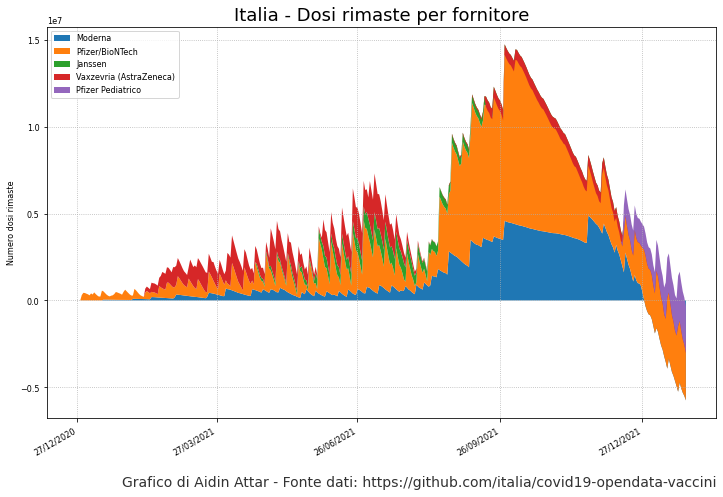

In [66]:
fig, ax = plt.subplots(figsize=(12,8))

colors=['red','violet','blue','orange','C0','violet','brown','yellow','green','black','purple']
ax.stackplot(italia_età['Pfizer/BioNTech'].index,[italia_età[key]['dosi_rimaste'] for key in italia_età.keys()])

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
labels = [key for key in italia_età.keys()]
ax.legend(labels, loc='upper left', ncol=1)
ax.set_title("Italia - Dosi rimaste per fornitore", fontsize=18)
plt.rcParams['font.size'] = '8'
ax.tick_params(axis='both', labelsize=8)
ax.grid(alpha = 1,linestyle='dotted')
ax.set_ylabel('Numero dosi rimaste')
ax.set_xlabel("")
fig.autofmt_xdate()

plt.text(0.9, 0.1, 'Grafico di Aidin Attar - Fonte dati: https://github.com/italia/covid19-opendata-vaccini',
         transform=plt.gcf().transFigure,
         fontsize=14, color='black', alpha=0.8,
         ha='right', va='top', rotation='0')

plt.show()

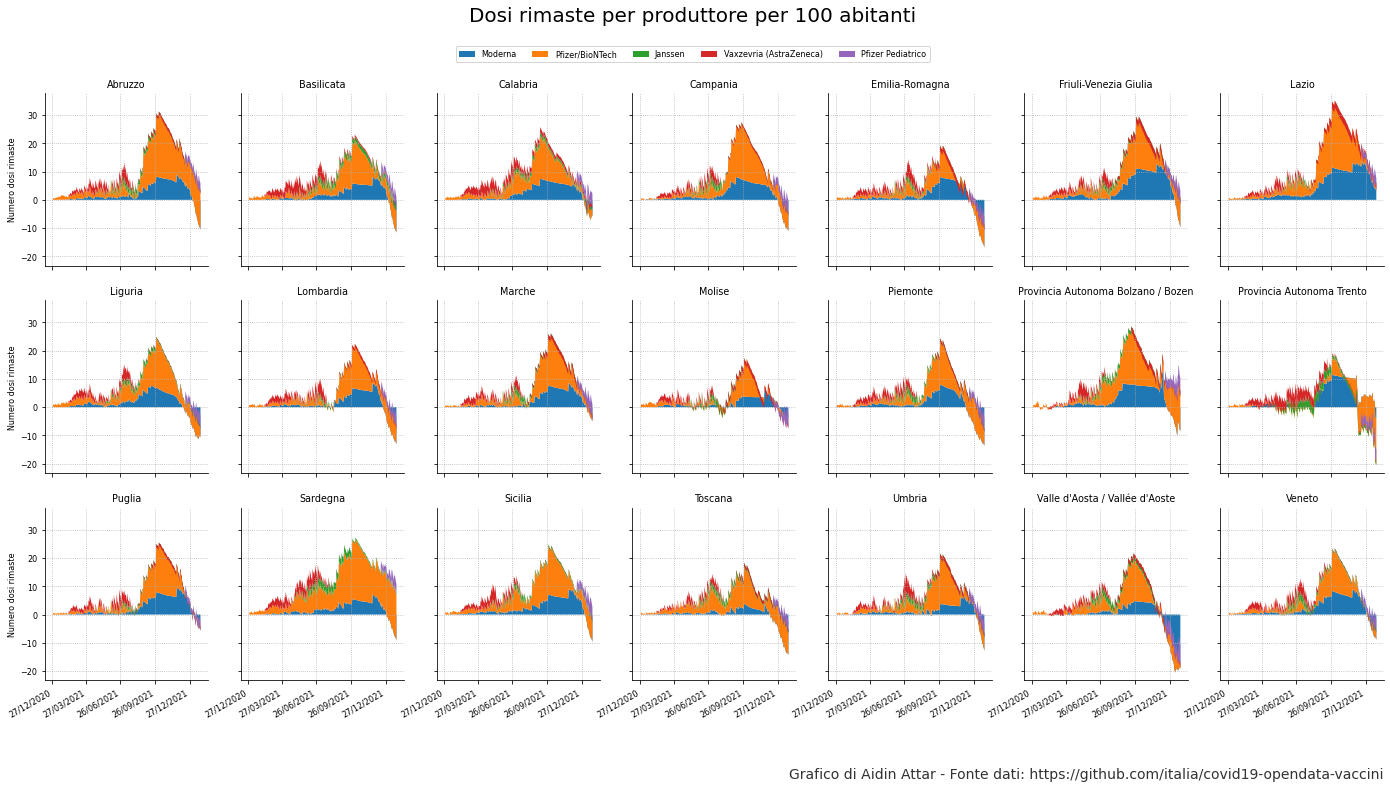

In [67]:
fig, ax = plt.subplots(nrows=3,ncols=7,figsize=(24,12), sharey=True, sharex=True)

colors=['red','violet','blue','orange','C0','violet','brown','black','plasma']
x=0
y=0
for key1 in somministrazioni_età.keys():
    ax[y,x].stackplot(somministrazioni_età[key1]['Pfizer/BioNTech'].index,[somministrazioni_età[key1][key]['dosi_rimaste_per100'] for key in somministrazioni_età[key1].keys()])
    ax[y,x].set_title(str(key1))
    ax[y,x].grid(linestyle='dotted')
    ax[y,x].spines['right'].set_visible(False)
    ax[y,x].spines['top'].set_visible(False)
    x+=1
    if x==7:
        x=0
        y+=1
ax[0,0].xaxis.set_major_locator(mdates.MonthLocator(interval=3))

fig.suptitle("Dosi rimaste per produttore per 100 abitanti", fontsize=20)
plt.rcParams['font.size'] = '8'
ax[0,0].tick_params(axis='both', labelsize=8)
#ax.grid(alpha = 0.2,linestyle='dotted')
ax[0,0].set_ylabel('Numero dosi rimaste')
ax[1,0].set_ylabel('Numero dosi rimaste')
ax[2,0].set_ylabel('Numero dosi rimaste')
ax[0,0].set_xlabel("")

labels = [key for key in somministrazioni_età['Emilia-Romagna'].keys()]
fig.legend(labels, loc='center',bbox_to_anchor=(.5,.925), ncol=len(labels), bbox_transform=fig.transFigure)

fig.autofmt_xdate()

plt.text(0.9, 0.1, 'Grafico di Aidin Attar - Fonte dati: https://github.com/italia/covid19-opendata-vaccini',
         transform=plt.gcf().transFigure,
         fontsize=14, color='black', alpha=0.8,
         ha='right', va='top', rotation='0')

plt.show()

Text(0.9, 0.05, 'Grafico di Aidin Attar - Fonte dati: https://github.com/italia/covid19-opendata-vaccini')

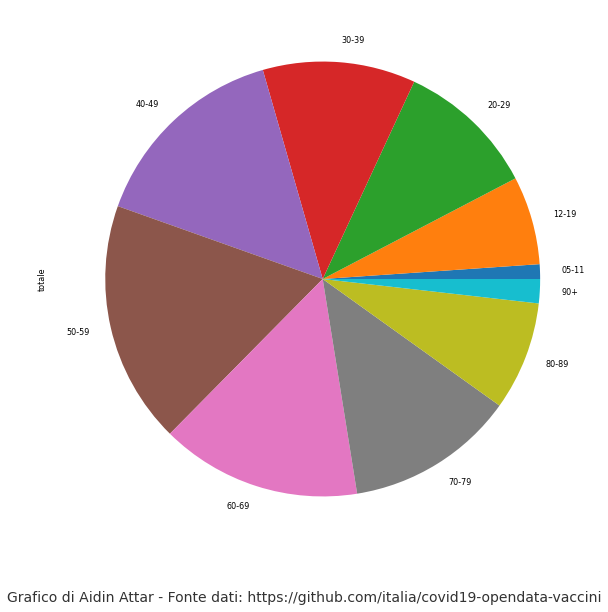

In [68]:
fig, ax = plt.subplots(figsize=(10,10))

anag.groupby(['fascia_anagrafica']).sum().plot(ax = ax, kind='pie', y='totale', legend = False)

plt.rcParams['font.size'] = '10'
plt.rcParams['xtick.labelsize'] = '8'
plt.rcParams['ytick.labelsize'] = '8'

plt.xticks(rotation=30)
plt.text(0.9, 0.05, 'Grafico di Aidin Attar - Fonte dati: https://github.com/italia/covid19-opendata-vaccini', transform=plt.gcf().transFigure,
        fontsize=14, color='black', alpha=0.8,
        ha='right', va='bottom', rotation='0')

/tmp/ipykernel_48802/1338212396.py:5: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  sum_ = total.reindex(['PAT', 'PAB', 'EMR', 'VEN',


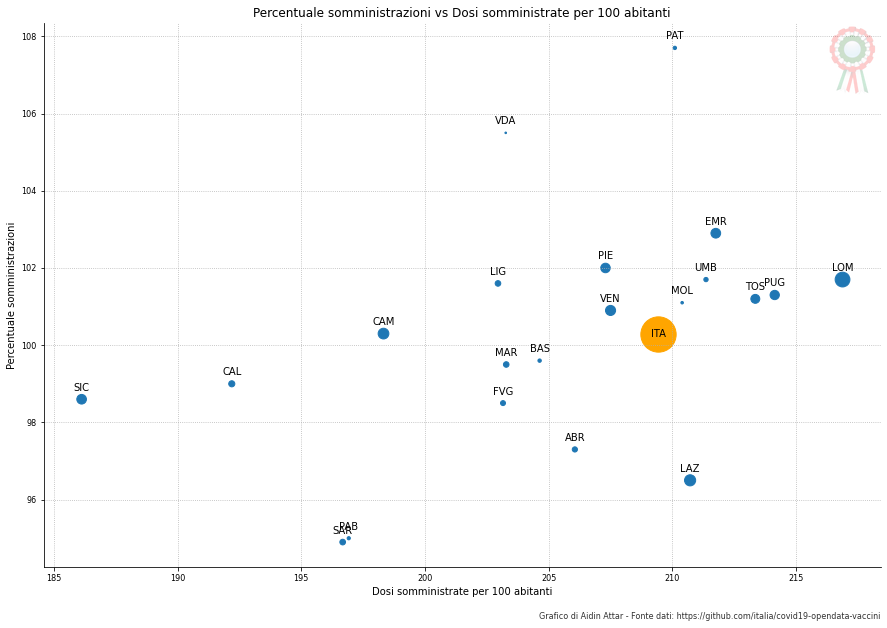

In [69]:
cum1     = cum.set_index('area')
vaccini1 = vaccini.set_index('area')
total = cum1.merge(vaccini1 , left_index=True, right_index=True, how='right')

sum_ = total.reindex(['PAT', 'PAB', 'EMR', 'VEN',
                      'VDA', 'UMB', 'ABR', 'BAS',
                      'SIC', 'SAR', 'CAL', 'CAM',
                      'PUG', 'PIE', 'LOM', 'MOL',
                      'LAZ', 'LIG', 'TOS', 'FVG', 'MAR']).sum().to_frame().transpose()
sum_ = sum_.rename(index={0: 'ITA'})
sum_['totale_per100']        = sum_['totale']     / PopoItalia * 100
sum_['cumulativa_totale_per100'] = sum_['cumulativa_totale'] / PopoItalia * 100
sum_['percentuale_somministrazione'] = sum_['dosi_somministrate'] / sum_['dosi_consegnate'] * 100

fig, ax=plt.subplots(figsize=(15,10))
total.plot.scatter(ax=ax,x='cumulativa_totale_per100', y='percentuale_somministrazione',
                        alpha=1, title='Percentuale somministrazioni vs Dosi somministrate per 100 abitanti',
                        color = 'C0', s=total['cumulativa_totale']/100000)
sum_.plot.scatter( ax=ax, x='cumulativa_totale_per100', y='percentuale_somministrazione',
                        alpha=1, color = 'orange', s=sum_.loc['ITA', 'cumulativa_totale']/100000)

for i, txt in enumerate(total.index):
    ax.annotate(txt, (total.cumulativa_totale_per100.iat[i], total.percentuale_somministrazione.iat[i]+0.3),ha='center', va='center')
txt = 'ITA'
ax.annotate(txt, (sum_.cumulativa_totale_per100.ITA, sum_.percentuale_somministrazione.ITA),ha='center', va='center')
ax.set(xlabel='Dosi somministrate per 100 abitanti', ylabel='Percentuale somministrazioni')
watermark2()

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.text(0.9, .05, 'Grafico di Aidin Attar - Fonte dati: https://github.com/italia/covid19-opendata-vaccini', transform=plt.gcf().transFigure,
        fontsize=8, color='black', alpha=0.8,
        ha='right', va='bottom', rotation='0')


plt.grid(alpha = 1, linestyle='dotted')

plt.show()

Text(0.9, 0.0, 'Grafico di Aidin Attar - Fonte dati: https://github.com/italia/covid19-opendata-vaccini')

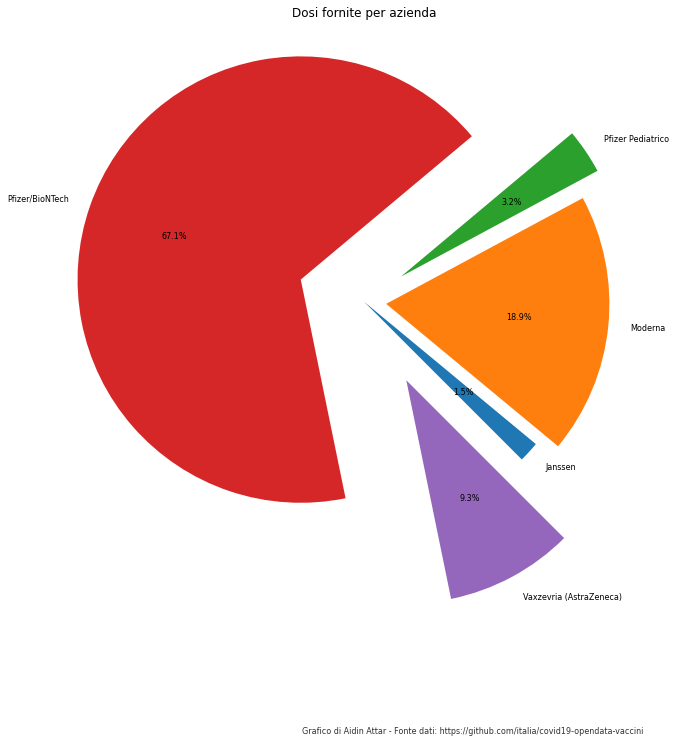

In [70]:
fig, ax = plt.subplots(figsize=(10,12))
cons.groupby('fornitore').sum().plot(ax=ax, kind = 'pie',
                                     y = 'numero_dosi', legend = False,
                                     ylabel = '', xlabel = '',
                                     fontsize = 8, title = 'Dosi fornite per azienda',
                                     autopct='%1.1f%%',startangle=-45,
                                     explode=[i/10 for i in range(len(consegne_italia_fornitori.keys()))] )
plt.text(0.9, 0., 'Grafico di Aidin Attar - Fonte dati: https://github.com/italia/covid19-opendata-vaccini', transform=plt.gcf().transFigure,
        fontsize=8, color='black', alpha=0.8,
        ha='right', va='bottom', rotation='0')

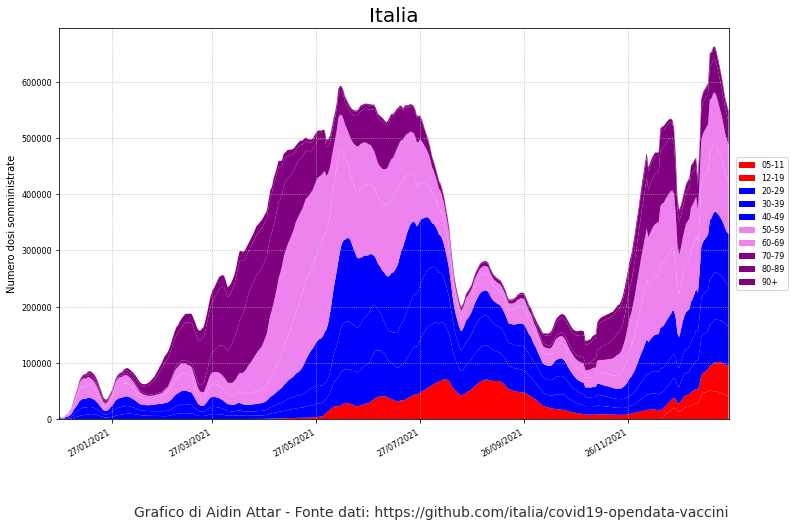

In [71]:
fig, ax = plt.subplots(figsize=(12,8))

colors=['red','red','blue','blue','blue','violet','violet','purple','purple','purple']
ax.stackplot(italia_fornitori['50-59'].index,[italia_fornitori[key]['media_totale'] for key in sorted(italia_fornitori.keys())], colors = colors)

label=[key for key in sorted(italia_fornitori.keys())]
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax.set_title("Italia", fontsize=20)
plt.rcParams['font.size'] = '8'
ax.tick_params(axis='both', labelsize=8)
ax.grid(alpha = 1,linestyle='dotted')
ax.set_ylabel('Numero dosi somministrate')
ax.set_xlabel("")
fig.autofmt_xdate()
#ax.set_ylim(top=1)
ax.set_xlim([date(2020, 12, 27).strftime('%d/%m/%Y'), yesterday.strftime('%d/%m/%Y')])
ax.legend(label, loc = 'center', bbox_to_anchor=(1.05, 0.5))

plt.text(0.9, 0.05, 'Grafico di Aidin Attar - Fonte dati: https://github.com/italia/covid19-opendata-vaccini',
         transform=plt.gcf().transFigure,
         fontsize=14, color='black', alpha=0.8,
         ha='right', va='top', rotation='0')

plt.show()

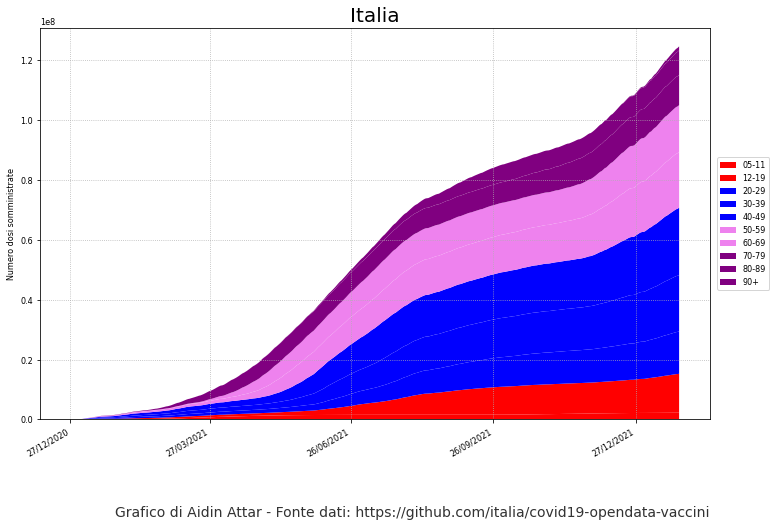

In [72]:
fig, ax = plt.subplots(figsize=(12,8))

colors=['red','red','blue','blue','blue','violet','violet','purple','purple','purple']
ax.stackplot(italia_fornitori['50-59'].index,[italia_fornitori[key]['cumulativa_totale'] for key in italia_fornitori.keys()], colors=colors)

label=[key for key in sorted(italia_fornitori.keys())]
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
ax.set_title("Italia", fontsize=20)
plt.rcParams['font.size'] = '8'
ax.tick_params(axis='both', labelsize=8)
ax.grid(alpha = 1,linestyle='dotted')
ax.set_ylabel('Numero dosi somministrate')
ax.set_xlabel("")
fig.autofmt_xdate()
ax.legend(label, loc = 'center', bbox_to_anchor=(1.05, 0.5))

plt.text(0.9, 0.05, 'Grafico di Aidin Attar - Fonte dati: https://github.com/italia/covid19-opendata-vaccini',
         transform=plt.gcf().transFigure,
         fontsize=14, color='black', alpha=0.8,
         ha='right', va='top', rotation='0')

plt.show()

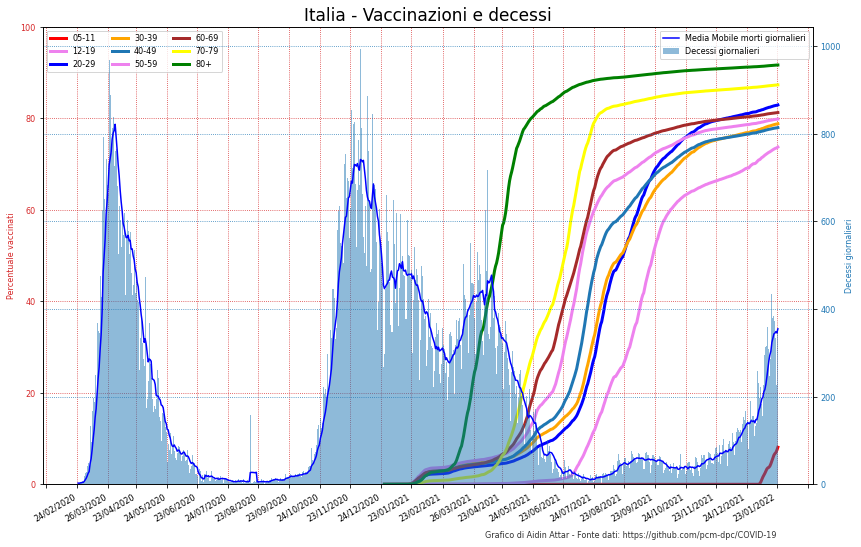

In [73]:
fig, ax1 = plt.subplots(figsize=(12, 8))

color = 'tab:red'
ax1.set_xlabel('')
ax1.set_ylabel('Percentuale vaccinati', color=color)
colors=['red','violet','blue','orange','C0','violet','brown','yellow','green','black','purple']
i=0
for key in sorted(new_italia_fornitori.keys()):
    ax1.plot(new_italia_fornitori[key].index,new_italia_fornitori[key]['perc_cumulativa_seconda_dose'], color=colors[i],label=str(key), lw=3)
    i+=1
ax1.set_ylim(bottom=0, top=100)
ax1.legend(loc='upper left', ncol=3)
fig.autofmt_xdate()

ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(linestyle='dotted',color=color)
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=1))

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('Decessi giornalieri', color=color)

ax2.bar(italia_contagio.index, italia_contagio.morti_giornalieri, color=color, width=1, alpha=0.5,label='Decessi giornalieri', zorder=1)
ax2.plot(italia_contagio.index, italia_contagio['media_morti_giorn'],
        color = 'blue', label = 'Media Mobile morti giornalieri',zorder=2)
ax1.set_title('Italia - Vaccinazioni e decessi', fontsize=17)
plt.rcParams['font.size'] = '8'
ax2.set_ylim(bottom=0)
ax2.set_xlabel('')
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(loc='upper right')

ax2.grid(linestyle='dotted', color=color)

plt.text(0.9, 0.075, 'Grafico di Aidin Attar - Fonte dati: https://github.com/pcm-dpc/COVID-19',
         transform=plt.gcf().transFigure,
         fontsize=8, color='black', alpha=0.8,
         ha='right', va='top', rotation='0')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()


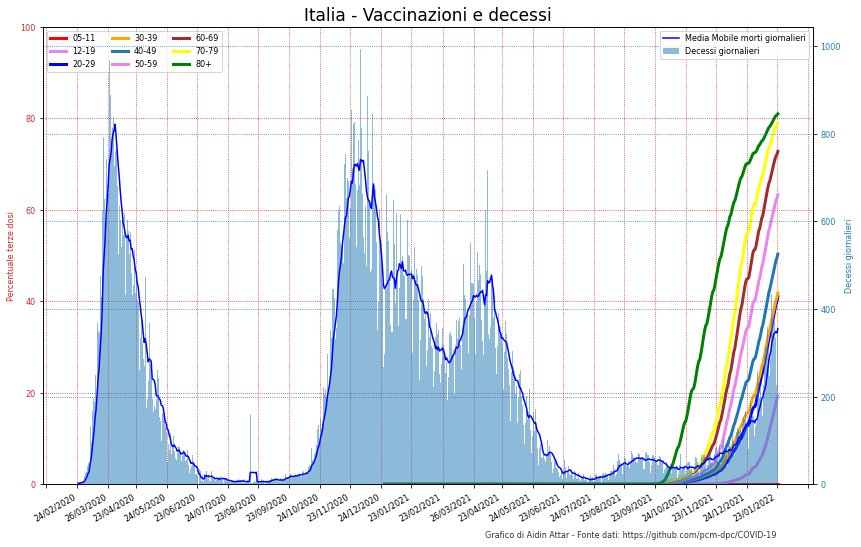

In [74]:
fig, ax1 = plt.subplots(figsize=(12, 8))

color = 'tab:red'
ax1.set_xlabel('')
ax1.set_ylabel('Percentuale terze dosi', color=color)
colors=['red','violet','blue','orange','C0','violet','brown','yellow','green','black','purple']
i=0
for key in sorted(new_italia_fornitori.keys()):
    ax1.plot(new_italia_fornitori[key].index,new_italia_fornitori[key]['perc_cumulativa_dose_addizionale_booster'], color=colors[i],label=str(key), lw=3)
    i+=1
ax1.set_ylim(bottom=0, top=100)
ax1.legend(loc='upper left', ncol=3)
fig.autofmt_xdate()

ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(linestyle='dotted',color=color)
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=1))

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('Decessi giornalieri', color=color)

ax2.bar(italia_contagio.index, italia_contagio.morti_giornalieri, color=color, width=1, alpha=0.5,label='Decessi giornalieri', zorder=1)
ax2.plot(italia_contagio.index, italia_contagio['media_morti_giorn'],
        color = 'blue', label = 'Media Mobile morti giornalieri',zorder=2)
ax1.set_title('Italia - Vaccinazioni e decessi', fontsize=17)
plt.rcParams['font.size'] = '8'
ax2.set_ylim(bottom=0)
ax2.set_xlabel('')
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(loc='upper right')

ax2.grid(linestyle='dotted', color=color)

plt.text(0.9, 0.075, 'Grafico di Aidin Attar - Fonte dati: https://github.com/pcm-dpc/COVID-19',
         transform=plt.gcf().transFigure,
         fontsize=8, color='black', alpha=0.8,
         ha='right', va='top', rotation='0')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()


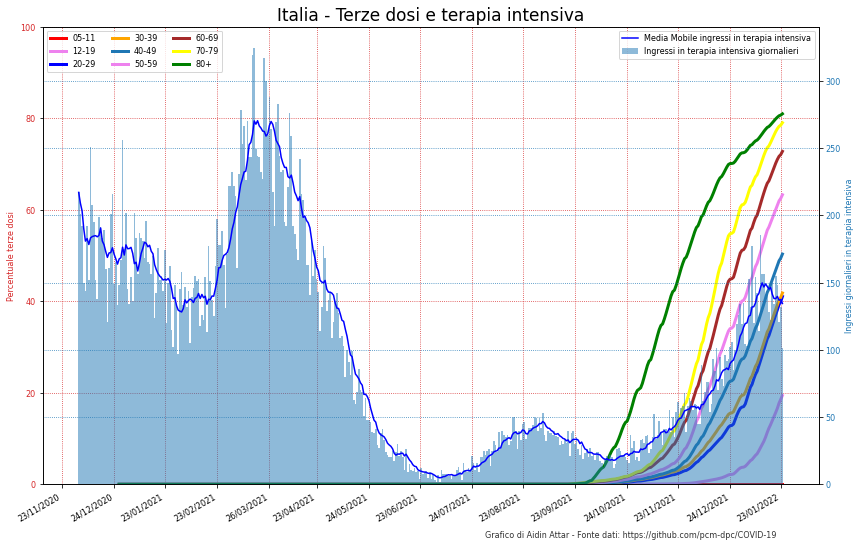

In [75]:
fig, ax1 = plt.subplots(figsize=(12, 8))

color = 'tab:red'
ax1.set_xlabel('')
ax1.set_ylabel('Percentuale terze dosi', color=color)
colors=['red','violet','blue','orange','C0','violet','brown','yellow','green','black','purple']
i=0
for key in sorted(new_italia_fornitori.keys()):
    ax1.plot(new_italia_fornitori[key].index,new_italia_fornitori[key]['perc_cumulativa_dose_addizionale_booster'], color=colors[i],label=str(key), lw=3)
    i+=1
ax1.set_ylim(bottom=0, top=100)
ax1.legend(loc='upper left', ncol=3)
fig.autofmt_xdate()

ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(linestyle='dotted',color=color)
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=1))

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('Ingressi giornalieri in terapia intensiva', color=color)

ax2.bar(italia_contagio.index, italia_contagio.ingressi_terapia_intensiva, color=color, width=1, alpha=0.5,label='Ingressi in terapia intensiva giornalieri', zorder=1)
ax2.plot(italia_contagio.index, italia_contagio['media_ingressi_terapia_intensiva'],
        color = 'blue', label = 'Media Mobile ingressi in terapia intensiva',zorder=2)
ax1.set_title('Italia - Terze dosi e terapia intensiva', fontsize=17)
plt.rcParams['font.size'] = '8'
ax2.set_ylim(bottom=0)
ax2.set_xlabel('')
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(loc='upper right')

ax2.grid(linestyle='dotted', color=color)

plt.text(0.9, 0.075, 'Grafico di Aidin Attar - Fonte dati: https://github.com/pcm-dpc/COVID-19',
         transform=plt.gcf().transFigure,
         fontsize=8, color='black', alpha=0.8,
         ha='right', va='top', rotation='0')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

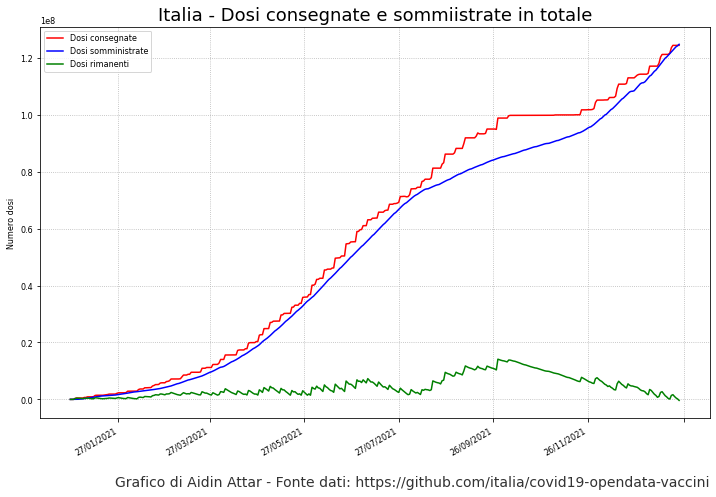

In [76]:
fig, ax = plt.subplots(figsize=(12,8))

#colors=['red','violet','blue','orange','C0','violet','brown','yellow','green','black','purple']
ax.plot(consegne_italia_fornitori['Pfizer/BioNTech'].index,sum(consegne_italia_fornitori[key]['cumulativa_numero_dosi'] for key in consegne_italia_fornitori.keys()), color='red')
ax.plot(italia.index,italia.cumulativa_totale, color='blue')
ax.plot(consegne_italia_fornitori['Pfizer/BioNTech'].index,sum(consegne_italia_fornitori[key]['cumulativa_numero_dosi'] for key in consegne_italia_fornitori.keys())-italia.cumulativa_totale, color='green')

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
labels = ['Dosi consegnate', 'Dosi somministrate', 'Dosi rimanenti']
ax.legend(labels, loc='upper left', ncol=1)
ax.set_title("Italia - Dosi consegnate e sommiistrate in totale", fontsize=18)
plt.rcParams['font.size'] = '8'
ax.tick_params(axis='both', labelsize=8)
ax.grid(alpha = 1,linestyle='dotted')
ax.set_ylabel('Numero dosi')
ax.set_xlabel("")
fig.autofmt_xdate()

plt.text(0.9, 0.1, 'Grafico di Aidin Attar - Fonte dati: https://github.com/italia/covid19-opendata-vaccini',
         transform=plt.gcf().transFigure,
         fontsize=14, color='black', alpha=0.8,
         ha='right', va='top', rotation='0')

plt.show()

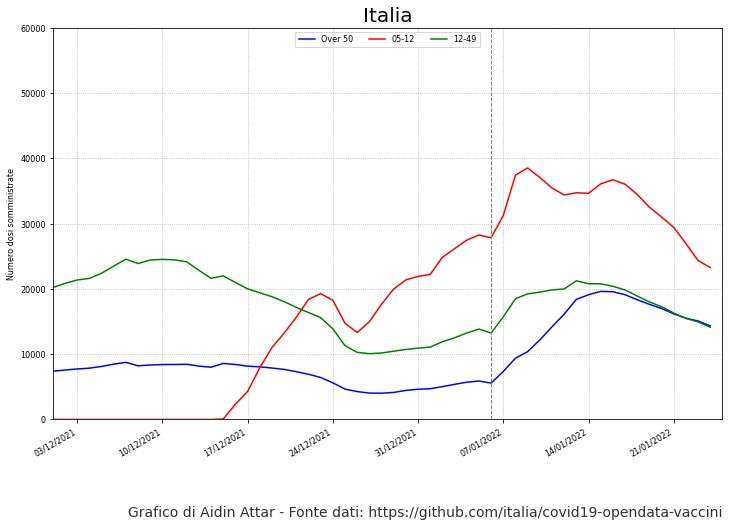

In [77]:
fig, ax = plt.subplots(figsize=(12,8))

ax.plot(italia_fornitori['50-59'].index,italia_fornitori['50-59']['media_prima_dose']+
                                        italia_fornitori['60-69']['media_prima_dose']+
                                        italia_fornitori['70-79']['media_prima_dose']+
                                        italia_fornitori['80-89']['media_prima_dose']+
                                        italia_fornitori[  '90+']['media_prima_dose'], color='blue')
ax.plot(italia_fornitori['50-59'].index,italia_fornitori['05-11']['media_prima_dose'], color='red')
ax.plot(italia_fornitori['50-59'].index,italia_fornitori['12-19']['media_prima_dose']+
                                        italia_fornitori['20-29']['media_prima_dose']+
                                        italia_fornitori['30-39']['media_prima_dose']+
                                        italia_fornitori['40-49']['media_prima_dose'], color='green')
ax.vlines(date(2022, 1, 6).strftime('%d/%m/%Y'),0,200000, linestyle='dashed', lw=1, color='grey')

label=['Over 50', '05-12', '12-49']
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
ax.set_title("Italia", fontsize=20)
plt.rcParams['font.size'] = '8'
ax.tick_params(axis='both', labelsize=8)
ax.grid(alpha = 1,linestyle='dotted')
ax.set_ylabel('Numero dosi somministrate')
ax.set_xlabel("")
fig.autofmt_xdate()
#ax.set_ylim(top=1)
ax.set_xlim([date(2021, 12, 1).strftime('%d/%m/%Y'), today.strftime('%d/%m/%Y')])
ax.set_ylim(bottom=0, top=6e4)
ax.legend(label, loc = 'upper center',ncol=3)

plt.text(0.9, 0.05, 'Grafico di Aidin Attar - Fonte dati: https://github.com/italia/covid19-opendata-vaccini',
         transform=plt.gcf().transFigure,
         fontsize=14, color='black', alpha=0.8,
         ha='right', va='top', rotation='0')

plt.show()

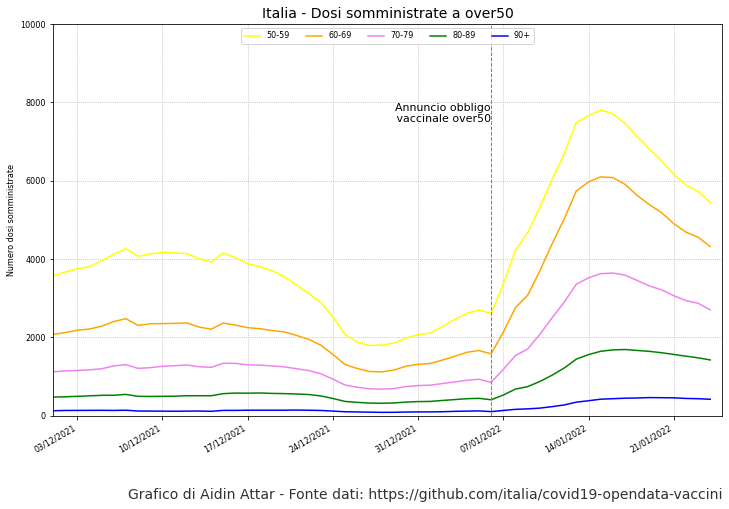

In [78]:
fig, ax = plt.subplots(figsize=(12,8))

ax.plot(italia_fornitori['50-59'].index,italia_fornitori['50-59']['media_prima_dose'], color='yellow')
ax.plot(italia_fornitori['50-59'].index,italia_fornitori['60-69']['media_prima_dose'], color='orange')
ax.plot(italia_fornitori['50-59'].index,italia_fornitori['70-79']['media_prima_dose'], color='violet')
ax.plot(italia_fornitori['50-59'].index,italia_fornitori['80-89']['media_prima_dose'], color='green')
ax.plot(italia_fornitori['50-59'].index,italia_fornitori[  '90+']['media_prima_dose'], color='blue')
ax.vlines(date(2022, 1, 6).strftime('%d/%m/%Y'),0,20000, linestyle='dashed', lw=1, color='grey')

label=['50-59', '60-69', '70-79', '80-89', '90+']
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
ax.set_title("Italia - Dosi somministrate a over50", fontsize=14)
plt.rcParams['font.size'] = '8'
ax.tick_params(axis='both', labelsize=8)
ax.grid(alpha = 1,linestyle='dotted')
ax.set_ylabel('Numero dosi somministrate')
ax.set_xlabel("")
fig.autofmt_xdate()
#ax.set_ylim(top=1)
ax.set_xlim([date(2021, 12, 1).strftime('%d/%m/%Y'), today.strftime('%d/%m/%Y')])
ax.set_ylim(bottom=0, top=1e4)
ax.legend(label, loc = 'upper center',ncol=5)

ax.annotate('Annuncio obbligo\n vaccinale over50', (date(2022, 1, 6).strftime('%d/%m/%Y'), 8000),fontsize=11,ha='right', va='top')

plt.text(0.9, 0.075, 'Grafico di Aidin Attar - Fonte dati: https://github.com/italia/covid19-opendata-vaccini',
         transform=plt.gcf().transFigure,
         fontsize=14, color='black', alpha=0.8,
         ha='right', va='top', rotation='0')

plt.show()

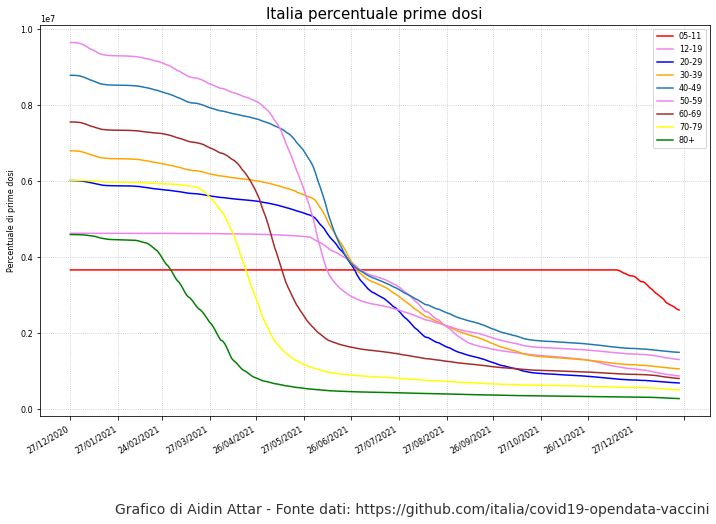

In [79]:
fig, ax = plt.subplots(figsize=(12,8))

colors=['red','violet','blue','orange','C0','violet','brown','yellow','green','black','purple']
i=0
for key in sorted(new_italia_fornitori.keys()):
    ax.plot(new_italia_fornitori[key].index,new_italia_fornitori[key]['rimasti_cumulativa_prima_dose'], color=colors[i],label=str(key))
    i+=1

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.legend(loc='best')
ax.set_title("Italia percentuale prime dosi", fontsize=15)
plt.rcParams['font.size'] = '8'
ax.tick_params(axis='both', labelsize=8)
ax.grid(alpha = 0.8,linestyle='dotted')
ax.set_ylabel('Percentuale di prime dosi')
ax.set_xlabel("")
fig.autofmt_xdate()

plt.text(0.9, 0.05, 'Grafico di Aidin Attar - Fonte dati: https://github.com/italia/covid19-opendata-vaccini',
         transform=plt.gcf().transFigure,
         fontsize=14, color='black', alpha=0.8,
         ha='right', va='top', rotation='0')

plt.show()

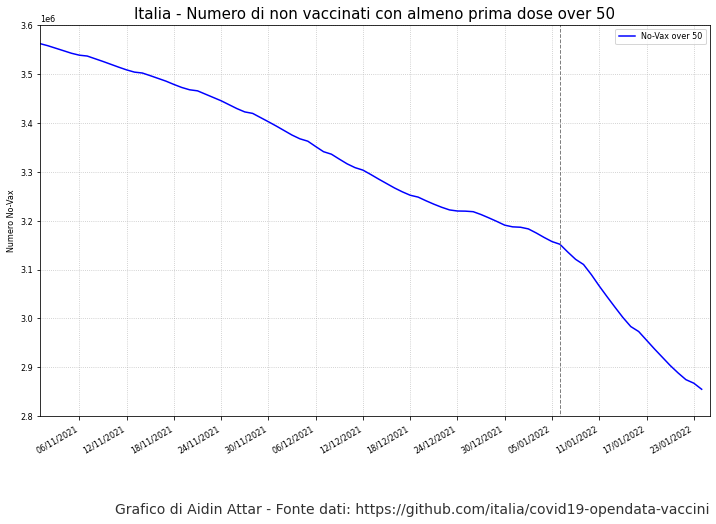

In [80]:
fig, ax = plt.subplots(figsize=(12,8))

colors=['red','violet','blue','orange','C0','violet','brown','yellow','green','black','purple']
ax.plot(new_italia_fornitori['50-59'].index,new_italia_fornitori['50-59']['rimasti_cumulativa_prima_dose']+
                                            new_italia_fornitori['60-69']['rimasti_cumulativa_prima_dose']+
                                            new_italia_fornitori['70-79']['rimasti_cumulativa_prima_dose']+
                                            new_italia_fornitori[  '80+']['rimasti_cumulativa_prima_dose'], color='blue',label='No-Vax over 50')
ax.vlines(date(2022, 1, 6).strftime('%d/%m/%Y'),0,4e6, linestyle='dashed', lw=1, color='grey')

ax.xaxis.set_major_locator(mdates.DayLocator(interval=6))
ax.set_xlim([date(2021, 11, 1).strftime('%d/%m/%Y'), today.strftime('%d/%m/%Y')])
ax.legend(loc='best')
ax.set_title("Italia - Numero di non vaccinati con almeno prima dose over 50", fontsize=15)
plt.rcParams['font.size'] = '8'
ax.tick_params(axis='both', labelsize=8)
ax.grid(alpha = 0.8,linestyle='dotted')
ax.set_ylabel('Numero No-Vax')
ax.set_xlabel("")
fig.autofmt_xdate()
ax.set_ylim(bottom=2.8e6, top=3.6e6)

plt.text(0.9, 0.05, 'Grafico di Aidin Attar - Fonte dati: https://github.com/italia/covid19-opendata-vaccini',
         transform=plt.gcf().transFigure,
         fontsize=14, color='black', alpha=0.8,
         ha='right', va='top', rotation='0')

plt.show()

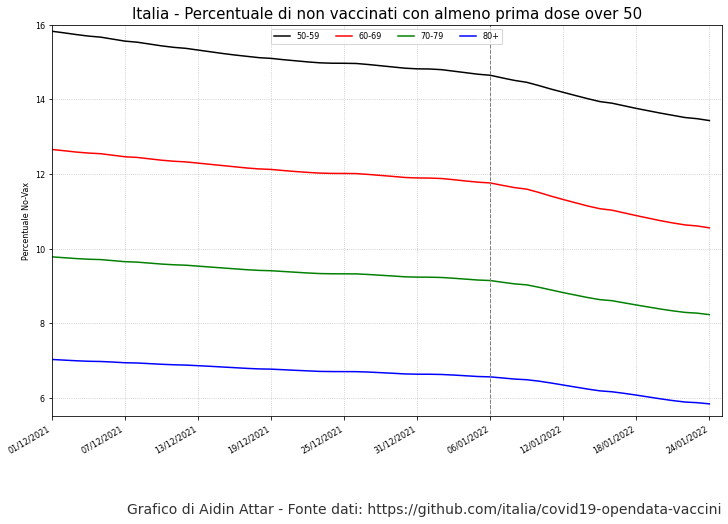

In [81]:
fig, ax = plt.subplots(figsize=(12,8))

colors=['red','violet','blue','orange','C0','violet','brown','yellow','green','black','purple']
ax.plot(new_italia_fornitori['50-59'].index,new_italia_fornitori['50-59']['rimasti_cumulativa_prima_dose']/Platea_Italia['50-59']*100, color='black',label='50-59')
ax.plot(new_italia_fornitori['60-69'].index,new_italia_fornitori['60-69']['rimasti_cumulativa_prima_dose']/Platea_Italia['60-69']*100, color='red',label='60-69')
ax.plot(new_italia_fornitori['70-79'].index,new_italia_fornitori['70-79']['rimasti_cumulativa_prima_dose']/Platea_Italia['70-79']*100, color='green',label='70-79')
ax.plot(new_italia_fornitori[  '80+'].index,new_italia_fornitori[  '80+']['rimasti_cumulativa_prima_dose']/Platea_Italia[  '80+']*100, color='blue',label='80+')
ax.vlines(date(2022, 1, 6).strftime('%d/%m/%Y'),0,20, linestyle='dashed', lw=1, color='grey')

ax.xaxis.set_major_locator(mdates.DayLocator(interval=6))
ax.set_xlim([date(2021, 12, 1).strftime('%d/%m/%Y'), today.strftime('%d/%m/%Y')])
ax.legend(loc='upper center', ncol=4)
ax.set_title("Italia - Percentuale di non vaccinati con almeno prima dose over 50", fontsize=15)
plt.rcParams['font.size'] = '8'
ax.tick_params(axis='both', labelsize=8)
ax.grid(alpha = 0.8,linestyle='dotted')
ax.set_ylabel('Percentuale No-Vax')
ax.set_xlabel("")
fig.autofmt_xdate()
ax.set_ylim(bottom=5.5, top=16)

plt.text(0.9, 0.05, 'Grafico di Aidin Attar - Fonte dati: https://github.com/italia/covid19-opendata-vaccini',
         transform=plt.gcf().transFigure,
         fontsize=14, color='black', alpha=0.8,
         ha='right', va='top', rotation='0')

plt.show()

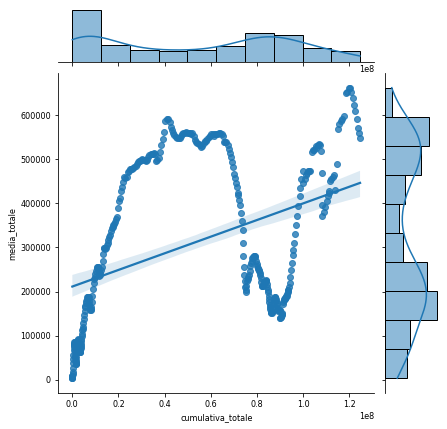

In [82]:
g = sns.jointplot(x='cumulativa_totale',
                  y='media_totale',
                  data=italia,
                  kind="reg")

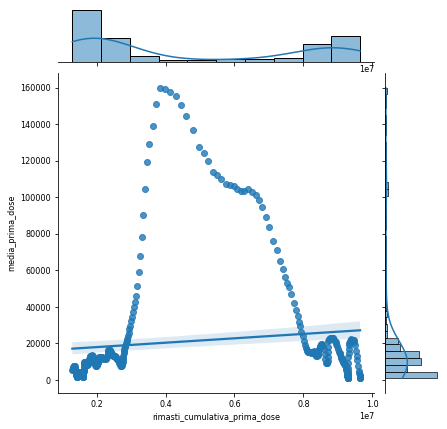

In [88]:
g = sns.jointplot(x='rimasti_cumulativa_prima_dose',
                  y='media_prima_dose',
                  data=new_italia_fornitori['50-59'],
                  kind="reg")